<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/BNP/BNP_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "bnp.pa"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open   High    Low  Close  Adj Close    Volume
Date                                                       
2009-01-02  30.50  32.70  29.92  32.70      21.03   4883545
2009-01-05  33.19  33.19  31.65  31.85      20.49   4973988
2009-01-06  31.77  34.40  31.68  34.10      21.93   7598070
2009-01-07  33.90  35.83  33.71  35.00      22.51   7347091
2009-01-08  34.50  35.29  33.82  34.84      22.41   3847637
...           ...    ...    ...    ...        ...       ...
2018-12-21  39.43  39.58  38.72  39.50      36.81  10927531
2018-12-24  39.17  39.22  38.71  38.79      36.14   1161447
2018-12-27  39.66  39.80  38.18  38.54      35.92   4383597
2018-12-28  38.76  39.58  38.67  39.38      36.69   3343656
2018-12-31  39.51  39.85  39.20  39.47      36.78   1055466

[2556 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2556.000000  2556.000000  2556.000000  2556.000000  2556.000000  2.556000e+03
mean     49.527954    50.192649    48.813576    49.492050    38.362711  4.827470e+06
std       9.921304     9.830955    10.006953     9.922939    10.127279  2.534107e+06
min      21.240000    22.690000    20.660000    21.380000    13.750000  0.000000e+00
25%      44.290000    44.850000    43.567500    44.175000    32.727500  3.217502e+06
50%      51.340000    52.000000    50.650000    51.310000    37.590000  4.207678e+06
75%      55.892500    56.525000    55.152500    55.780000    44.580000  5.675408e+06
max      68.710000    69.170000    68.500000    68.890000    60.800000  2.417537e+07

7

In [5]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [6]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open   High    Low  Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08     SMA_8     TEMA_8  TRIMA_8      WMA_8    MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2009-03-13  29.18  29.50  28.63  29.25      18.81   6675912   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  26.018139  25.145236  21.637792  27.806869  26.411186  25.200997      25.495      25.225  22.230368  25.40625  28.923981  24.9570  26.522222  25.40625  28.356667  24.736931               30.892068                 25.40625               19.920432               33.634976                 25.40625               17.177524               36.377885                 25.40625               14.434615               39.120794                 25.40625               11.691706  26.411186  28.217801  24.660263               31.897003                26.411186               20.925368               34.639912                26.411186               18.182459               37.382821                26.411186               15.439551               40.125729                26.411186   
2009-03-16  29.88  31.98  29.76  31.98      20.57   6925884   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  26.316232  25.174511  22.109524  29.696742  27.648700  26.255977      26.860      26.465  22.811939  26.31250  31.072998  26.2330  27.983056  26.31250  30.615000  24.928871               33.254220                 26.31250               19.370780               36.725080                 26.31250               15.899920               40.195940                 26.31250               12.429060               43.666800                 26.31250                8.958200  27.648700  30.911263  24.919042               34.590420                27.648700               20.706980               38.061280                27.648700               17.236120               41.532140                27.648700               13.765260               45.003000                27.648700   
2009-03-17  30.91  32.12  30.80  31.70   

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2.506000e+03  2506.000000  2506.000000  2506.000000    2506.000000   2506.000000     2506.000000     2506.000000       2506.000000  2506.000000  2506.000000  2506.000000  2506.000000   2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000  2506.000000  2506.000000  2506.000000             2506.000000              2506.000000             2506.000000             2506.000000              2506.000000             2506.000000             2506.000000   
mean     49.972666    50.628579    49.266492    49.934900    38.777889  4.776029e+06    15.766959     1.999202   186.043496      30.462889      0.032721        0.028332        0.009976          0.007981     6.619314     2.538707    27.001197     1.999202      2.015563    27.001197    49.897817    49.814821    -1.307366    49.937352    49.915254    49.915555    49.879757    49.855110    49.740190    49.916055    49.936133    49.916561    49.922945    49.916055    49.933240    49.869838               51.924281                49.916055               47.907829               52.928393                49.916055               46.903716               53.932506                49.916055               45.899604               54.936619                49.916055               44.895491    49.915254    49.932627    49.877014               51.923479                49.915254               47.907028               52.927592                49.915254               46.902915               53.931705   
std       9.487455     9.412606     9.559453     9.493108     9.781472  2.484233e+06     8.737921     1.407706   103.562746       0.785865      0.177942        0.165953        0.099401          0.088996     3.394067     1.106097    14.812238     1.407706      1.412857    14.812238     9.441652     9.412197    50.696476     9.504056     9.432115     9.408185     9.456973     9.429264     9.610635     9.458716     9.501008     9.471990     9.456102     9.458716     9.479689     9.438730                9.267284                 9.458716                9.773910                9.220582                 9.458716                9.974431                9.207336                 9.458716               10.201400                9.227689                 9.458716               10.453093     9.432115     9.470205     9.441150                9.244015                 9.432115                9.744487                9.199146                 9.432115                9.943797                9.187822   
min      23.500000    24.160000    22.

36

In [7]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [8]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.125636  0.118640  0.129096  0.135064   0.057464   6675912   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000000  0.666675  0.086855  0.010797  0.000000    0.000000    0.000000  0.000000  0.000000  0.118816  0.000000  0.026222  0.000000  0.094519  0.000000                0.089742                 0.000000                0.011470                0.136508                 0.000000                0.025067                0.177098                 0.000000                0.037128                0.212443                 0.000000                0.047900  0.010797  0.090178  0.000000                0.109878                 0.010797                0.004703                0.152882                 0.010797                0.019146                0.190968                 0.010797                0.031897                0.224199                 0.010797   
2009-03-16  0.141119  0.173739  0.153779  0.194632   0.096970   6925884   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.007119  0.000700  0.670138  0.129204  0.040157  0.024858    0.032038    0.028986  0.012390  0.021210  0.166184  0.029538  0.060306  0.021210  0.145181  0.004487                0.144795                 0.021210                0.000000                0.203435                 0.021210                0.000000                0.254332                 0.021210                0.000000                0.298620                 0.021210                0.000000  0.040157  0.150733  0.006033                0.171450                 0.040157                0.000000                0.225482                 0.040157                0.000000                0.273021                 0.040157                0.000000                0.314501                 0.040157   
2009-03-17  0.163902  0.176850  0.176496  0.1885

140416

In [9]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         2 hours 15 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 8 days
H2O cluster name:           H2O_from_python_unknownUser_5y448z
H2O cluster total nodes:    1
H2O cluster free memory:    8.98 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_152639_mod...  0.548585  3.411084              0.492481  0.662119  0.438402
1              DeepLearning_1_AutoML_20190827_152639  0.504620  3.572541              0.500000  0.630880  0.398010
2  DeepLearning_grid_1_AutoML_20190827_152639_mod...  0.501975  3.380175              0.500000  0.672852  0.452729
3  DeepLearning_grid_1_AutoML_20190827_152639_mod...  0.491175  9.292943              0.500000  0.735535  0.541012
4  DeepLearning_grid_1_AutoML_20190827_152639_mod...  0.485791  0.942161              0.500000  0.519978  0.270377
5  DeepLearning_grid_1_AutoML_20190827_152639_mod...  0.484739  0.696290              0.500000  0.501568  0.251570
6  DeepLearning_grid_1_AutoML_20190827_152639_mod...  0.482669  2.845804              0.500000  0.624985  0.390606
7  DeepLearning_grid_1_AutoML_20190827_152639_mod...  0.479833  0.822852              0.496241  0.523263  0.273804
8  DeepLearning_grid_1_AutoML_20190827_152639_mod...  0.466866  3.251788              0.500000  0.589671  0.347711
9  DeepLearning_grid_1_AutoML_20190827_152639_mod...  0.452785  0.727296              0.500000  0.513329  0.263506

variable  relative_importance  scaled_importance  percentage
0             CDLLADDERBOTTOM             1.000000           1.000000    0.003708
1              CDLMORNINGSTAR             0.954994           0.954994    0.003541
2             CDLADVANCEBLOCK             0.952999           0.952999    0.003534
3         CDLGAPSIDESIDEWHITE             0.948061           0.948061    0.003515
4          CDLMORNINGDOJISTAR             0.943227           0.943227    0.003497
...                       ...                  ...                ...         ...
1037                  MA_24_3             0.193715           0.193715    0.000718
1038                   MIN_24             0.189695           0.189695    0.000703
1039                MAVP_14_5             0.188135           0.188135    0.000698
1040  BBANDS_lowerband_12_3_5             0.181005           0.181005    0.000671
1041           CDL3LINESTRIKE             0.174924           0.174924    0.000649

[1042 rows x 4 columns]

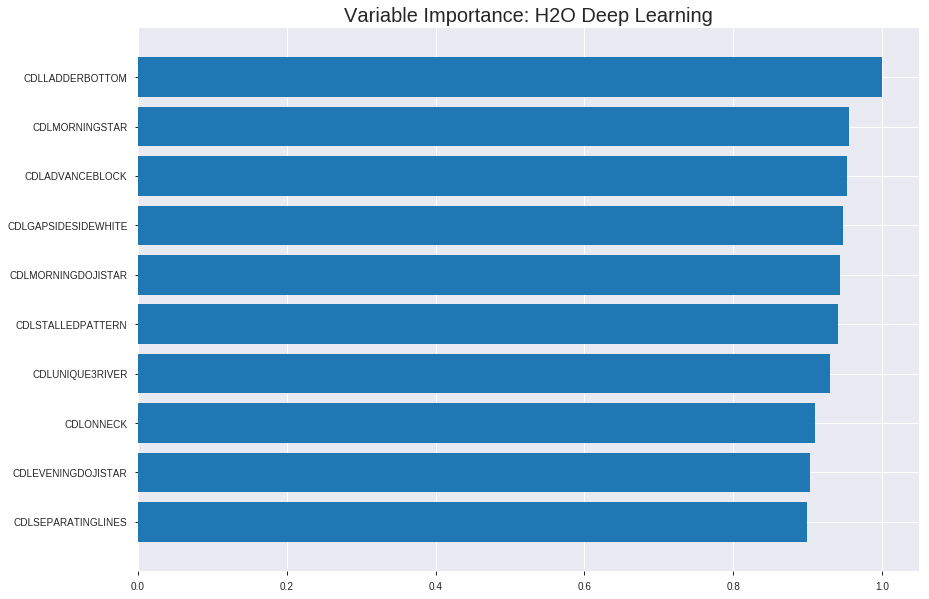

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_152639_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.3224794248119245
RMSE: 0.5678727188480923
LogLoss: 0.9194882482635591
Mean Per-Class Error: 0.44082349967821866
AUC: 0.5780033142175242
pr_auc: 0.5860974035517855
Gini: 0.1560066284350483
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5579698361315286: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      52   799   0.9389   (799.0/851.0)
1      13   889   0.0144   (13.0/902.0)
Total  65   1688  0.4632   (812.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.55797      0.686486  355
max f2                       0.435034     0.842991  389
max f0point5                 0.703995     0.586449  256
max accuracy                 0.757678     0.563035  209
max precision                0.947529     0.747368  26
max recall                   0.435034     1         389
max specificity              0.990055     0.99765   0
max absolute_mcc             0.922874     0.130038  50
max min_per_class_accuracy   0.805022     0.547591  164
max mean_per_class_accuracy  0.757678     0.559177  209

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 79.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.975786           1.18767   1.18767            0.611111         0.983796  0.611111                    0.983796            0.0121951       0.0121951                  18.7669    18.7669
    2        0.0205362                   0.966147           1.51158   1.34962            0.777778         0.970381  0.694444                    0.977088            0.0155211       0.0277162                  51.1579    34.9624
    3        0.0302339                   0.961255           1.37185   1.35675            0.705882         0.96338   0.698113                    0.972691            0.0133038       0.04102                    37.1853    35.6754
    4        0.040502                    0.95489            1.51158   1.39601            0.777778         0.958     0.71831                     0.968967            0.0155211       0.056541                   51.1579    39.6006
    5        0.0501997                   0.948348           1.71482   1.45759            0.882353         0.950963  0.75                        0.965489            0.0166297       0.0731707                  71.4817    45.7594
    6        0.100399                    0.930254           1.17049   1.31404            0.602273         0.938795  0.676136                    0.952142            0.0587583       0.131929                   17.0492    31.4043
    7        0.150029                    0.914664           1.22862   1.28579            0.632184         0.922235  0.661597                    0.942249            0.0609756       0.192905                   22.8623    28.5787
    8        0.200228                    0.901056           0.993814  1.21259            0.511364         0.90836   0.623932                    0.933752            0.0498891       0.242794                   -0.618575  21.2586
    9        0.300057                    0.872942           0.966177  1.13061            0.497143         0.888166  0.581749                    0.918586            0.0964523       0.339246                   -3.38232   13.0605
    10       0.399886                    0.840568           0.955071  1.08678            0.491429         0.856815  0.559201                    0.903165            0.0953437       0.43459                    -4.49287   8.67845
    11       0.500285                    0.805173           1.10424   1.09029            0.568182         0.82248   0.561003                    0.886973            0.110865        0.545455                   10.4238    9.02871
    12       0.600114                    0.772399           1.0106    1.07703            0.52             0.78767   0.554183                    0.870454            0.100887        0.646341                   1.05987    7.7031
    13       0.699943                    0.730269           1.0106    1.06756            0.52             0.750321  0.549307                    0.85332             0.100887        0.747228                   1.05987    6.75561
    14       0.799772                    0.687702           0.899544  1.04658            0.462857         0.71003   0.538516                    0.835434            0.0898004       0.837029                   -10.0456   4.65845
    15       0.899601                    0.622449           0.921755  1.03273            0.474286         0.661254  0.531389                    0.816106            0.0920177       0.929047                   -7.82452   3.27322
    16       1                           0.379912           0.706712  1                  0.363636         0.555806  0.514546                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.39928009369963874
RMSE: 0.6318861398223882
LogLoss: 4.822266409330902
Mean Per-Class Error: 0.49006184449615864
AUC: 0.4722098249864516
pr_auc: 0.39253790843898184
Gini: -0.055580350027096825
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4599451440513175: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    245  0.9919   (245.0/247.0)
1      0    254  0        (0.0/254.0)
Total  2    499  0.489    (245.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.459945     0.674635   391
max f2                       0.459945     0.838284   391
max f0point5                 0.459945     0.564444   391
max accuracy                 0.626895     0.51497    323
max precision                0.626895     0.512761   323
max recall                   0.459945     1          391
max specificity              1            0.785425   0
max absolute_mcc             0.997717     0.0744328  43
max min_per_class_accuracy   0.92785      0.480315   142
max mean_per_class_accuracy  0.626895     0.509938   323

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 84.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.169661                    1                  0.997823  0.997823           0.505882         1         0.505882                    1                   0.169291        0.169291                   -0.217693  -0.217693
    2        0.201597                    1                  0.616388  0.937398           0.3125           1         0.475248                    1                   0.019685        0.188976                   -38.3612   -6.26023
    3        0.301397                    0.997717           0.788976  0.888252           0.4              0.999447  0.450331                    0.999817            0.0787402       0.267717                   -21.1024   -11.1748
    4        0.401198                    0.967338           1.02567   0.922435           0.52             0.983028  0.467662                    0.995641            0.102362        0.370079                   2.56693    -7.75649
    5        0.500998                    0.927604           1.10457   0.958716           0.56             0.946783  0.486056                    0.985908            0.110236        0.480315                   10.4567    -4.12837
    6        0.600798                    0.837143           1.06512   0.976391           0.54             0.88799   0.495017                    0.969643            0.106299        0.586614                   6.51181    -2.3609
    7        0.700599                    0.735123           0.907323  0.966552           0.46             0.779984  0.490028                    0.942626            0.0905512       0.677165                   -9.26772   -3.34477
    8        0.800399                    0.668054           1.02567   0.973923           0.52             0.704554  0.493766                    0.912941            0.102362        0.779528                   2.56693    -2.60765
    9        0.9002                      0.607448           1.26236   1.0059             0.64             0.63459   0.509978                    0.882082            0.125984        0.905512                   26.2362    0.590115
    10       1                           0.383986           0.946772  1                  0.48             0.545545  0.506986                    0.848495            0.0944882       1                          -5.32283   0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 15:29:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 15:29:29  2 min 47.087 sec  413 obs/sec       0.383913  1             673        0.679303         4.94219             -0.847376      0.507949        0.342809           1.04371          0.482601                         0.643892           7.56092               -0.65871         0.563693          0.527765             1.6437             0.493014
    2019-08-27 15:29:40  2 min 58.378 sec  510 obs/sec       3.45579   9             6058       0.618799         2.23984             -0.532946      0.574813        0.46648            1.51158          0.485454                         0.664004           7.46387               -0.763949        0.553006          0.558691             1.97244            0.493014
    2019-08-27 15:29:51  3 min  9.428 sec  521 obs/sec       6.49344   17            11383      0.605805         1.9591              -0.469243      0.5754          0.56811            1.61955          0.485454                         0.649268           7.52219               -0.686524        0.545993          0.526857             0.65748            0.493014
    2019-08-27 15:30:03  3 min 21.354 sec  531 obs/sec       9.90816   26            17369      0.569218         2.8837              -0.297136      0.572356        0.417596           1.29564          0.452938                         0.636916           7.58488               -0.622967        0.554943          0.558284             1.6437             0.493014
    2019-08-27 15:30:15  3 min 33.068 sec  536 obs/sec       13.2647   35            23253      0.539409         0.92095             -0.164832      0.614573        0.596523           1.61955          0.444381                         0.613303           6.81725               -0.504857        0.55727           0.55566              1.6437             0.493014
    2019-08-27 15:30:25  3 min 43.864 sec  537 obs/sec       16.2624   43            28508      0.510949         0.728287            -0.0451589     0.615553        0.623041           1.61955          0.469481                         0.590711           6.17772               -0.39603         0.554544          0.548608             1.31496            0.493014
    2019-08-27 15:30:36  3 min 54.535 sec  539 obs/sec       19.2847   51            33806      0.509866         0.732748            -0.0407331     0.59388         0.597217           1.29564          0.464917                         0.608683           6.14723               -0.482272        0.55193           0.547186             1.31496            0.493014
    2019-08-27 15:30:48  4 min  6.199 sec  542 obs/sec       22.6583   60            39720      0.517926         0.763303            -0.0738968     0.585647        0.584617           1.51158          0.462065                         0.585723           5.53721               -0.372553        0.552209          0.547001             1.31496            0.493014
    2019-08-27 15:30:59

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLLADDERBOTTOM          1.0                    1.0                  0.003707981129214176
CDLMORNINGSTAR           0.9549943804740906     0.9549943804740906   0.003541101141303511
CDLADVANCEBLOCK          0.952999472618103      0.952999472618103    0.003533704060618988
CDLGAPSIDESIDEWHITE      0.9480609893798828     0.9480609893798828   0.003515392257964727
CDLMORNINGDOJISTAR       0.9432265162467957     0.9432265162467957   0.003497466122817547
---                      ---                    ---                  ---
MA_24_3                  0.1937149316072464     0.1937149316072464   0.0007182913108466844
MIN_24                   0.18969514966011047    0.18969514966011047  0.0007033860352431485
MAVP_14_5                0.18813492357730865    0.18813492357730865  0.0006976007463708117
BBANDS_lowerband_12_3_5  0.18100549280643463    0.18100549280643463  0.0006711649516103719
CDL3LINESTRIKE           0.17492355406284332    0.17492355406284332  0.0006486132375200988


See the whole table with table.as_data_frame()


('accuracy', 0.5697211155378487)

('F1', 0.6430517711171662)

('auc', 0.5485854466675163)

('logloss', 3.4110844206376885)

('mean_per_class_error', 0.4284758506435581)

('rmse', 0.6621193964443931)

('mse', 0.43840209514788736)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


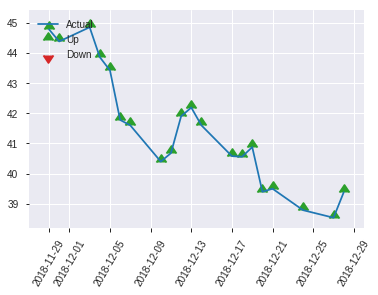


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.43840209514788736
RMSE: 0.6621193964443931
LogLoss: 3.4110844206376885
Mean Per-Class Error: 0.4284758506435581
AUC: 0.5485854466675163
pr_auc: 0.43957983082901203
Gini: 0.0971708933350326
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6979316461746918: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    131  0.985    (131.0/133.0)
1      0    118  0        (0.0/118.0)
Total  2    249  0.5219   (131.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.697932     0.643052  217
max f2                       0.697932     0.818308  217
max f0point5                 0.922843     0.549536  100
max accuracy                 0.924553     0.569721  98
max precision                0.986744     0.565217  37
max recall                   0.697932     1         217
max specificity              1            0.879699  0
max absolute_mcc             0.922843     0.142985  100
max min_per_class_accuracy   0.9357       0.548872  93
max mean_per_class_accuracy  0.922843     0.571524  100

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 90.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0876494                   1                  1.16025   1.16025            0.545455         1         0.545455                    1                   0.101695        0.101695                   16.0247   16.0247
    2        0.103586                    1                  1.06356   1.14537            0.5              1         0.538462                    1                   0.0169492       0.118644                   6.35593   14.5372
    3        0.151394                    0.999914           0.886299  1.06356            0.416667         0.99999   0.5                         0.999997            0.0423729       0.161017                   -11.3701  6.35593
    4        0.203187                    0.996938           0.981747  1.04271            0.461538         0.998781  0.490196                    0.999687            0.0508475       0.211864                   -1.82529  4.27052
    5        0.302789                    0.983371           1.36136   1.14752            0.64             0.989698  0.539474                    0.996401            0.135593        0.347458                   36.1356   14.7525
    6        0.40239                     0.966655           1.02102   1.11621            0.48             0.972595  0.524752                    0.990509            0.101695        0.449153                   2.10169   11.6211
    7        0.501992                    0.932705           1.1061    1.11421            0.52             0.950934  0.52381                     0.982657            0.110169        0.559322                   10.6102   11.4205
    8        0.601594                    0.896388           1.02102   1.09878            0.48             0.911425  0.516556                    0.970863            0.101695        0.661017                   2.10169   9.87765
    9        0.701195                    0.845227           0.680678  1.03939            0.32             0.867013  0.488636                    0.956112            0.0677966       0.728814                   -31.9322  3.93875
    10       0.800797                    0.816454           0.765763  1.00535            0.36             0.830712  0.472637                    0.940515            0.0762712       0.805085                   -23.4237  0.535458
    11       0.900398                    0.770364           1.02102   1.00709            0.48             0.789919  0.473451                    0.923856            0.101695        0.90678                    2.10169   0.708715
    12       1                           0.675249           0.935932  1                  0.44             0.730721  0.47012                     0.90462             0.0932203       1                          -6.40678  0

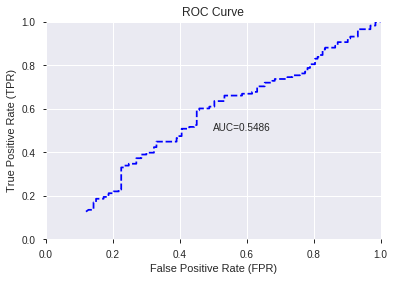

This function is available for GLM models only


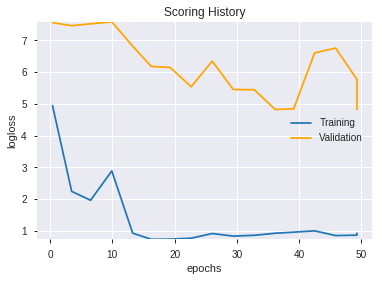

--2019-08-27 16:01:27--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_152639_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_152639_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [11]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_160139_model_3  0.486874  6.483334              0.500000  0.612156  0.374735
1  DeepLearning_grid_1_AutoML_20190827_160139_model_4  0.484007  3.911047              0.500000  0.619722  0.384055
2  DeepLearning_grid_1_AutoML_20190827_160139_model_8  0.480502  1.326857              0.496241  0.541070  0.292756
3               DeepLearning_1_AutoML_20190827_160139  0.473748  3.673875              0.500000  0.597423  0.356915
4  DeepLearning_grid_1_AutoML_20190827_160139_model_6  0.468873  2.542229              0.500000  0.563048  0.317023
5  DeepLearning_grid_1_AutoML_20190827_160139_model_7  0.468427  2.940959              0.496241  0.624797  0.390372
6  DeepLearning_grid_1_AutoML_20190827_160139_model_5  0.465305  2.634866              0.500000  0.574517  0.330069
7  DeepLearning_grid_1_AutoML_20190827_160139_model_2  0.464063  6.189349              0.500000  0.627339  0.393554
8  DeepLearning_grid_1_AutoML_20190827_160139_model_1  0.463171  6.540914              0.500000  0.633544  0.401378
9  DeepLearning_grid_1_AutoML_20190827_160139_model_9  0.461928  2.051189              0.500000  0.542635  0.294453

variable  relative_importance  scaled_importance  percentage
0    CDLMORNINGDOJISTAR             1.000000           1.000000    0.035298
1     CDLSTALLEDPATTERN             0.985703           0.985703    0.034793
2       CDLLADDERBOTTOM             0.911176           0.911176    0.032163
3    CDLEVENINGDOJISTAR             0.870373           0.870373    0.030722
4             CDL2CROWS             0.859870           0.859870    0.030352
5    CDLSEPARATINGLINES             0.843171           0.843171    0.029762
6      CDLSTICKSANDWICH             0.832638           0.832638    0.029390
7       CDLADVANCEBLOCK             0.820692           0.820692    0.028969
8   CDLGAPSIDESIDEWHITE             0.795941           0.795941    0.028095
9             CDLINNECK             0.788973           0.788973    0.027849
10     CDLABANDONEDBABY             0.780786           0.780786    0.027560
11   CDLUPSIDEGAP2CROWS             0.769499           0.769499    0.027162
12      CDLUNIQUE3RIVER             0.762522           0.762522    0.026915
13          CDLPIERCING             0.754819           0.754819    0.026644
14            CDLONNECK             0.742652           0.742652    0.026214
15       CDLMORNINGSTAR             0.699665           0.699665    0.024697
16      CDLSHOOTINGSTAR             0.661873           0.661873    0.023363
17         CDLBREAKAWAY             0.595716           0.595716    0.021028
18       CDLEVENINGSTAR             0.579949           0.579949    0.020471
19       CDLMATCHINGLOW             0.548301           0.548301    0.019354
20     CDLCOUNTERATTACK             0.538439           0.538439    0.019006
21     is_quarter_start             0.520463           0.520463    0.018371
22            CDLTAKURI             0.517385           0.517385    0.018263
23    CDLGRAVESTONEDOJI             0.514162           0.514162    0.018149
24     CDLDRAGONFLYDOJI             0.509919           0.509919    0.017999
25                  SIN             0.508040           0.508040    0.017933
26       STOCHRSI_fastk             0.487932           0.487932    0.017223
27         CDLTHRUSTING             0.486692           0.486692    0.017179
28                  COS             0.484940           0.484940    0.017117
29    CDLINVERTEDHAMMER             0.478283           0.478283    0.016882
30               SAREXT             0.475247           0.475247    0.016775
31          aroondown_8             0.474032           0.474032    0.016732
32      CDLHOMINGPIGEON             0.471592           0.471592    0.016646
33                 SINH             0.468399           0.468399    0.016534
34                 COSH             0.451922           0.451922    0.015952
35                  EXP             0.450319           0.450319    0.015895
36       is_quarter_end             0.430127           0.430127    0.015183
37         weekday_name             0.400937           0.400937    0.014152
38            CORREL_12             0.391801           0.391801    0.013830
39        days_in_month             0.387447           0.387447    0.013676
40        CDLHANGINGMAN             0.369292           0.369292    0.013035
41            CDLHAMMER             0.348759           0.348759    0.012310
42       is_month_start             0.345574           0.345574    0.012198
43             CORREL_8             0.343628           0.343628    0.012129
44                  SUB             0.338688           0.338688    0.011955
45         HT_TRENDMODE             0.336091           0.336091    0.011863
46    CDLDARKCLOUDCOVER             0.330819           0.330819    0.011677
47       CDLRICKSHAWMAN             0.302322           0.302322    0.010671
48              CDLDOJI             0.291056           0.291056    0.010274
49         is_month_end             0.271647           0.271647    0.009589

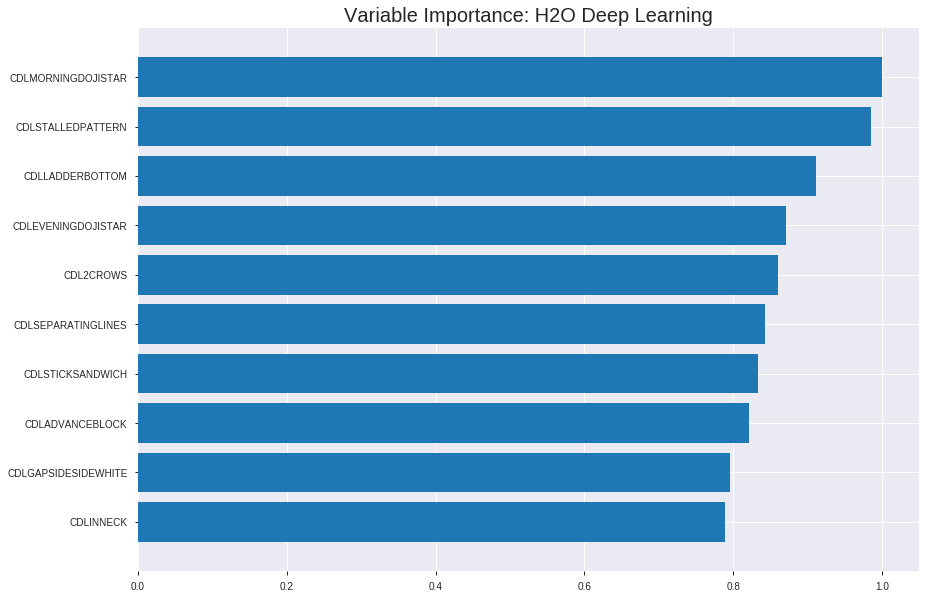

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_160139_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24635740401626502
RMSE: 0.49634403795781107
LogLoss: 0.7292729264047941
Mean Per-Class Error: 0.39122031990536765
AUC: 0.634260984207962
pr_auc: 0.6122339953300512
Gini: 0.2685219684159239
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4449936569284128: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      169  682   0.8014   (682.0/851.0)
1      74   828   0.082    (74.0/902.0)
Total  243  1510  0.4313   (756.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444994     0.686567  297
max f2                       0.000446444  0.841261  399
max f0point5                 0.555462     0.617298  205
max accuracy                 0.580405     0.606389  186
max precision                0.9998       0.826087  0
max recall                   0.000446444  1         399
max specificity              0.9998       0.9953    0
max absolute_mcc             0.580405     0.220234  186
max min_per_class_accuracy   0.553461     0.60282   207
max mean_per_class_accuracy  0.580405     0.60878   186

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 57.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.999547           1.72752   1.72752            0.888889         0.999932  0.888889                    0.999932            0.0177384       0.0177384                  72.7519   72.7519
    2        0.0205362                   0.991653           1.29564   1.51158            0.666667         0.99653   0.777778                    0.998231            0.0133038       0.0310421                  29.5639   51.1579
    3        0.0302339                   0.959257           1.37185   1.46676            0.705882         0.978512  0.754717                    0.991906            0.0133038       0.0443459                  37.1853   46.6761
    4        0.040502                    0.935902           1.18767   1.39601            0.611111         0.945449  0.71831                     0.980128            0.0121951       0.056541                   18.7669   39.6006
    5        0.0501997                   0.906935           1.6005    1.43551            0.823529         0.920044  0.738636                    0.968521            0.0155211       0.0720621                  60.0496   43.5509
    6        0.100399                    0.805637           1.28092   1.35821            0.659091         0.853923  0.698864                    0.911222            0.0643016       0.136364                   28.0916   35.8213
    7        0.150029                    0.726055           1.18395   1.30057            0.609195         0.759372  0.669202                    0.86099             0.0587583       0.195122                   18.3946   30.0566
    8        0.200228                    0.684398           1.32509   1.30671            0.681818         0.703255  0.672365                    0.821444            0.0665188       0.261641                   32.5086   30.6713
    9        0.300057                    0.630087           1.07723   1.23036            0.554286         0.656282  0.63308                     0.766495            0.107539        0.36918                    7.72315   23.0365
    10       0.399886                    0.587331           1.26602   1.23927            0.651429         0.608618  0.63766                     0.727082            0.126386        0.495565                   26.6025   23.9267
    11       0.500285                    0.554283           1.04903   1.20109            0.539773         0.569888  0.618016                    0.695535            0.105322        0.600887                   4.90262   20.1089
    12       0.600114                    0.524796           0.955071  1.16016            0.491429         0.539194  0.596958                    0.669528            0.0953437       0.696231                   -4.49287  16.0164
    13       0.699943                    0.496947           0.899544  1.12299            0.462857         0.508978  0.577832                    0.64663             0.0898004       0.786031                   -10.0456  12.2993
    14       0.799772                    0.467377           0.788489  1.08124            0.405714         0.483209  0.556348                    0.626231            0.078714        0.864745                   -21.1511  8.12397
    15       0.899601                    0.415475           0.755173  1.04506            0.388571         0.447651  0.53773                     0.606414            0.075388        0.940133                   -24.4827  4.50559
    16       1                           1.96097e-05        0.596289  1                  0.306818         0.252672  0.514546                    0.570899         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.36471124133284916
RMSE: 0.6039132730225832
LogLoss: 6.85672445010414
Mean Per-Class Error: 0.43391564920781667
AUC: 0.5440562338614555
pr_auc: 0.526454453428482
Gini: 0.08811246772291104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.3634605920403286e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    254  0        (0.0/254.0)
Total  0    501  0.493    (247.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.36346e-48  0.672848  354
max f2                       1.36346e-48  0.837179  354
max f0point5                 0.000444643  0.577201  282
max accuracy                 0.00103566   0.566866  278
max precision                0.999823     1         0
max recall                   1.36346e-48  1         354
max specificity              0.999823     1         0
max absolute_mcc             0.000444643  0.133057  282
max min_per_class_accuracy   0.178036     0.547244  247
max mean_per_class_accuracy  0.00103566   0.566084  278

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 28.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.93757            0.32874   0.32874            0.166667         0.984706     0.166667                    0.984706            0.00393701      0.00393701                 -67.126   -67.126
    2        0.0219561                   0.912682           1.18346   0.717251           0.6              0.921467     0.363636                    0.955961            0.011811        0.015748                   18.3465   -28.2749
    3        0.0319361                   0.865467           1.97244   1.1095             1                0.885788     0.5625                      0.934032            0.019685        0.0354331                  97.2441   10.9498
    4        0.0419162                   0.840664           0.788976  1.03318            0.4              0.854365     0.52381                     0.915063            0.00787402      0.0433071                  -21.1024  3.31834
    5        0.0518962                   0.788961           1.18346   1.06208            0.6              0.804233     0.538462                    0.89375             0.011811        0.0551181                  18.3465   6.20836
    6        0.101796                    0.655729           1.02567   1.04423            0.52             0.702583     0.529412                    0.800041            0.0511811       0.106299                   2.56693   4.42334
    7        0.151697                    0.613633           0.946772  1.01217            0.48             0.629719     0.513158                    0.744014            0.0472441       0.153543                   -5.32283  1.21736
    8        0.201597                    0.586296           0.946772  0.995985           0.48             0.598515     0.50495                     0.707999            0.0472441       0.200787                   -5.32283  -0.401497
    9        0.301397                    0.529579           1.10457   1.03194            0.56             0.555439     0.523179                    0.657483            0.110236        0.311024                   10.4567   3.19393
    10       0.401198                    0.465725           1.22291   1.07945            0.62             0.499118     0.547264                    0.618088            0.122047        0.433071                   22.2913   7.94453
    11       0.500998                    0.118524           1.14402   1.09231            0.58             0.384033     0.553785                    0.571464            0.114173        0.547244                   14.4016   9.23079
    12       0.600798                    3.49696e-07        0.907323  1.06158            0.46             0.0189987    0.538206                    0.479692            0.0905512       0.637795                   -9.26772  6.15795
    13       0.700599                    5.49036e-42        0.98622   1.05084            0.5              1.49741e-08  0.532764                    0.41136             0.0984252       0.73622                    -1.37795  5.08446
    14       0.800399                    2.61066e-222       0.749528  1.01327            0.38             1.78021e-45  0.513716                    0.360068            0.0748031       0.811024                   -25.0472  1.32739
    15       1                           0                  0.946772  1                  0.48             2.1768e-240  0.506986                    0.288198            0.188976        1                          -5.32283  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:02:51  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:02:54  1 min 13.177 sec  5133 obs/sec      7.79293   1             13661      0.530456         0.898033            -0.126486      0.570014        0.55866            1.51158          0.478608                         0.605385           6.97136               -0.46625         0.557947          0.558799             1.31496            0.493014
    2019-08-27 16:03:00  1 min 19.404 sec  6232 obs/sec      31.227    4             54741      0.496546         0.74476             0.0129322      0.628576        0.61629            1.72752          0.429549                         0.607863           7.15051               -0.478281        0.541235          0.526423             0.32874            0.493014
    2019-08-27 16:03:06  1 min 25.715 sec  7305 obs/sec      62.4404   8             109458     0.496344         0.729273            0.0137356      0.634261        0.612234           1.72752          0.431261                         0.603913           6.85672               -0.45913         0.544056          0.526454             0.32874            0.493014
    2019-08-27 16:03:12  1 min 31.315 sec  8014 obs/sec      93.6383   12            164148     0.490425         0.704662            0.0371199      0.6557          0.636515           1.83549          0.411865                         0.600842           6.93098               -0.444327        0.548248          0.531951             0.65748            0.493014
    2019-08-27 16:03:17  1 min 36.605 sec  8526 obs/sec      124.853   16            218868     0.48778          0.694477            0.0474782      0.659579        0.64964            1.72752          0.41757                          0.603208           6.97228               -0.455723        0.546614          0.530436             0.65748            0.493014
    2019-08-27 16:03:23  1 min 41.778 sec  8902 obs/sec      156.066   20            273584     0.488004         0.695057            0.0466001      0.659662        0.659919           1.61955          0.472333                         0.605171           6.9591                -0.465216        0.544949          0.524629             0.98622            0.493014
    2019-08-27 16:03:23  1 min 41.919 sec  8898 obs/sec      156.066   20            273584     0.496344         0.729273            0.0137356      0.634261        0.612234           1.72752          0.431261                         0.603913           6.85672               -0.45913         0.544056          0.526454             0.32874            0.493014

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLMORNINGDOJISTAR  1.0                    1.0                  0.03529793149831021
CDLSTALLEDPATTERN   0.9857031106948853     0.9857031106948853   0.034793280878979344
CDLLADDERBOTTOM     0.9111762642860413     0.9111762642860413   0.03216263735965488
CDLEVENINGDOJISTAR  0.8703726530075073     0.8703726530075073   0.030722354283861514
CDL2CROWS           0.859869658946991      0.859869658946991    0.030351620318986246
---                 ---                    ---                  ---
HT_TRENDMODE        0.3360905349254608     0.3360905349254608   0.01186330067902935
CDLDARKCLOUDCOVER   0.3308190405368805     0.3308190405368805   0.011677227831207514
CDLRICKSHAWMAN      0.30232155323028564    0.30232155323028564  0.010671325476385366
CDLDOJI             0.29105567932128906    0.29105567932128906  0.010273663430877005
is_month_end        0.27164673805236816    0.27164673805236816  0.009588567951511908


See the whole table with table.as_data_frame()


('accuracy', 0.5617529880478087)

('F1', 0.6395663956639567)

('auc', 0.48687396457244814)

('logloss', 6.483334367560457)

('mean_per_class_error', 0.46180068816108066)

('rmse', 0.6121563009049108)

('mse', 0.37473533673758364)

deeplearning prediction progress: |███████████████████████████████████████| 100%


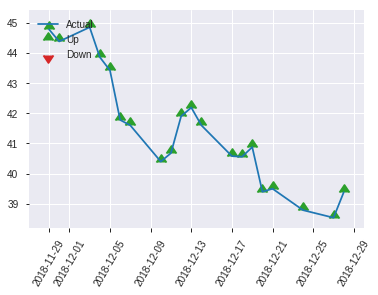


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.37473533673758364
RMSE: 0.6121563009049108
LogLoss: 6.483334367560457
Mean Per-Class Error: 0.46180068816108066
AUC: 0.48687396457244814
pr_auc: 0.483821702731964
Gini: -0.026252070855103726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.465588369872994e-52: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    118  0        (0.0/118.0)
Total  0    251  0.5299   (133.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.46559e-52  0.639566  202
max f2                       3.46559e-52  0.816044  202
max f0point5                 3.46559e-52  0.525847  202
max accuracy                 0.764634     0.561753  25
max precision                0.999923     1         0
max recall                   3.46559e-52  1         202
max specificity              0.999923     1         0
max absolute_mcc             0.764634     0.125134  25
max min_per_class_accuracy   0.501638     0.5       117
max mean_per_class_accuracy  0.764634     0.538199  25

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 36.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.989781           1.41808   1.41808            0.666667         0.996471      0.666667                    0.996471            0.0169492       0.0169492                  41.8079   41.8079
    2        0.0239044                   0.956457           0.70904   1.06356            0.333333         0.975282      0.5                         0.985877            0.00847458      0.0254237                  -29.096   6.35593
    3        0.0318725                   0.917839           2.12712   1.32945            1                0.932733      0.625                       0.972591            0.0169492       0.0423729                  112.712   32.9449
    4        0.0438247                   0.880816           1.41808   1.35362            0.666667         0.894197      0.636364                    0.951211            0.0169492       0.059322                   41.8079   35.3621
    5        0.0517928                   0.841209           1.06356   1.309              0.5              0.849179      0.615385                    0.935513            0.00847458      0.0677966                  6.35593   30.8996
    6        0.103586                    0.764634           1.47262   1.39081            0.692308         0.800199      0.653846                    0.867856            0.0762712       0.144068                   47.2621   39.0808
    7        0.151394                    0.696765           0.53178   1.11954            0.25             0.72899       0.526316                    0.824004            0.0254237       0.169492                   -46.822   11.9536
    8        0.203187                    0.653754           0.818123  1.04271            0.384615         0.674682      0.490196                    0.785942            0.0423729       0.211864                   -18.1877  4.27052
    9        0.302789                    0.580179           0.850847  0.979594           0.4              0.612746      0.460526                    0.728969            0.0847458       0.29661                    -14.9153  -2.04059
    10       0.40239                     0.531951           1.27627   1.05303            0.6              0.548383      0.49505                     0.68427             0.127119        0.423729                   27.6271   5.3029
    11       0.501992                    0.477853           0.765763  0.996032           0.36             0.507728      0.468254                    0.649242            0.0762712       0.5                        -23.4237  -0.396825
    12       0.601594                    0.180534           0.595593  0.929734           0.28             0.406364      0.437086                    0.60903             0.059322        0.559322                   -40.4407  -7.0266
    13       0.701195                    7.39887e-11        1.1061    0.954786           0.52             0.0213939     0.448864                    0.525559            0.110169        0.669492                   10.6102   -4.52138
    14       0.800797                    6.83713e-40        1.02102   0.963024           0.48             2.58937e-13   0.452736                    0.460191            0.101695        0.771186                   2.10169   -3.69761
    15       0.900398                    5.70809e-274       1.19119   0.988263           0.56             1.57905e-43   0.464602                    0.409285            0.118644        0.889831                   19.1186   -1.17369
    16       1                           0                  1.1061    1                 

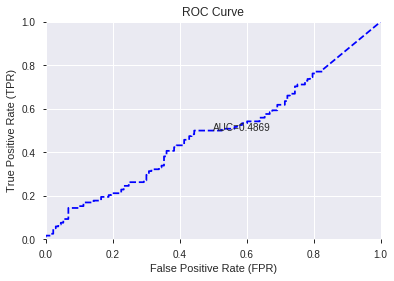

This function is available for GLM models only


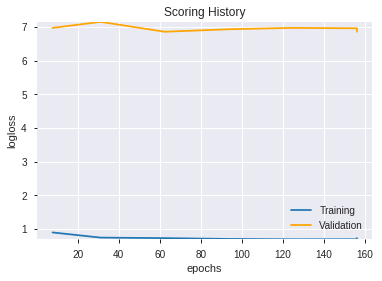

--2019-08-27 16:12:49--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_160139_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_160139_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLMORNINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'CDL2CROWS',
 'CDLSEPARATINGLINES',
 'CDLSTICKSANDWICH',
 'CDLADVANCEBLOCK',
 'CDLGAPSIDESIDEWHITE',
 'CDLINNECK',
 'CDLABANDONEDBABY',
 'CDLUPSIDEGAP2CROWS',
 'CDLUNIQUE3RIVER',
 'CDLPIERCING',
 'CDLONNECK',
 'CDLMORNINGSTAR',
 'CDLSHOOTINGSTAR',
 'CDLBREAKAWAY',
 'CDLEVENINGSTAR',
 'CDLMATCHINGLOW',
 'CDLCOUNTERATTACK',
 'is_quarter_start',
 'CDLTAKURI',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'SIN',
 'STOCHRSI_fastk',
 'CDLTHRUSTING',
 'COS',
 'CDLINVERTEDHAMMER',
 'SAREXT',
 'aroondown_8',
 'CDLHOMINGPIGEON',
 'SINH',
 'COSH',
 'EXP',
 'is_quarter_end',
 'weekday_name',
 'CORREL_12',
 'days_in_month',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'is_month_start',
 'CORREL_8',
 'SUB',
 'HT_TRENDMODE',
 'CDLDARKCLOUDCOVER',
 'CDLRICKSHAWMAN',
 'CDLDOJI',
 'is_month_end']

In [12]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190827_161345_model_1  0.459889  2.663354                   0.5  0.56349  0.317521

variable  relative_importance  scaled_importance  percentage
0             CORREL_12             0.009057           1.000000    0.047956
1    CDLMORNINGDOJISTAR             0.008065           0.890473    0.042703
2     CDLSTALLEDPATTERN             0.007969           0.879874    0.042195
3           aroondown_8             0.007558           0.834505    0.040019
4         days_in_month             0.007474           0.825221    0.039574
5          CDLBREAKAWAY             0.007086           0.782348    0.037518
6          weekday_name             0.006662           0.735621    0.035277
7                SAREXT             0.006576           0.726122    0.034822
8       CDLLADDERBOTTOM             0.006328           0.698743    0.033509
9        STOCHRSI_fastk             0.005963           0.658392    0.031574
10            CDLTAKURI             0.005694           0.628680    0.030149
11     CDLDRAGONFLYDOJI             0.005683           0.627460    0.030090
12      CDLADVANCEBLOCK             0.005468           0.603728    0.028952
13            CDLONNECK             0.005416           0.598005    0.028678
14                  EXP             0.005394           0.595592    0.028562
15                 SINH             0.005385           0.594574    0.028513
16                 COSH             0.005382           0.594263    0.028498
17       CDLMATCHINGLOW             0.005338           0.589351    0.028263
18      CDLSHOOTINGSTAR             0.005263           0.581133    0.027869
19    CDLGRAVESTONEDOJI             0.005136           0.567066    0.027194
20                  SUB             0.005106           0.563755    0.027035
21         is_month_end             0.004406           0.486500    0.023331
22   CDLUPSIDEGAP2CROWS             0.004254           0.469734    0.022527
23       is_quarter_end             0.003913           0.432011    0.020718
24     CDLABANDONEDBABY             0.003811           0.420821    0.020181
25       CDLMORNINGSTAR             0.003688           0.407167    0.019526
26     is_quarter_start             0.003663           0.404436    0.019395
27       CDLEVENINGSTAR             0.003226           0.356209    0.017082
28      CDLHOMINGPIGEON             0.002865           0.316359    0.015171
29         HT_TRENDMODE             0.002787           0.307735    0.014758
30     CDLCOUNTERATTACK             0.002471           0.272851    0.013085
31            CDL2CROWS             0.002241           0.247425    0.011865
32       is_month_start             0.002226           0.245743    0.011785
33   CDLEVENINGDOJISTAR             0.001986           0.219250    0.010514
34              CDLDOJI             0.001822           0.201159    0.009647
35   CDLSEPARATINGLINES             0.001749           0.193082    0.009259
36             CORREL_8             0.001701           0.187851    0.009009
37      CDLUNIQUE3RIVER             0.001572           0.173577    0.008324
38                  SIN             0.001372           0.151519    0.007266
39         CDLTHRUSTING             0.001281           0.141409    0.006781
40          CDLPIERCING             0.001166           0.128796    0.006177
41            CDLHAMMER             0.001073           0.118528    0.005684
42        CDLHANGINGMAN             0.001028           0.113509    0.005443
43    CDLINVERTEDHAMMER             0.000784           0.086556    0.004151
44       CDLRICKSHAWMAN             0.000675           0.074482    0.003572
45    CDLDARKCLOUDCOVER             0.000663           0.073204    0.003511
46     CDLSTICKSANDWICH             0.000214           0.023609    0.001132
47                  COS             0.000084           0.009229    0.000443
48            CDLINNECK             0.000075           0.008286    0.000397
49  CDLGAPSIDESIDEWHITE             0.000059           0.006512    0.000312

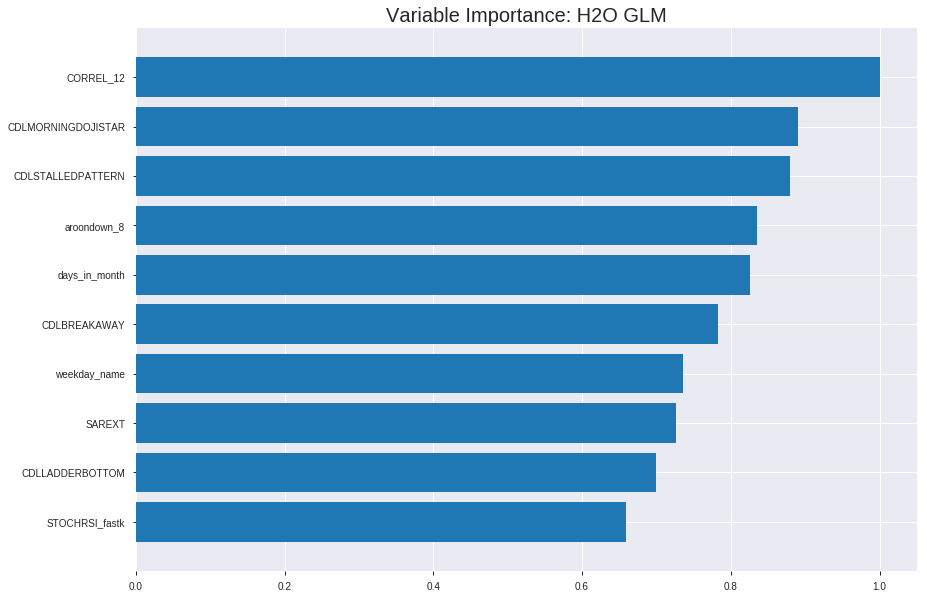

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_161345_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24833435904143594
RMSE: 0.4983315754007927
LogLoss: 0.6898097924392768
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2428.6900635089887
Residual deviance: 2418.4731322921043
AIC: 2520.4731322921043
AUC: 0.584003819687807
pr_auc: 0.5970888939703055
Gini: 0.16800763937561403
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49578473080925944: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      34   817   0.96     (817.0/851.0)
1      11   891   0.0122   (11.0/902.0)
Total  45   1708  0.4723   (828.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495785     0.682759  362
max f2                       0.459302     0.842046  394
max f0point5                 0.512335     0.582863  234
max accuracy                 0.512335     0.563035  234
max precision                0.571278     1         0
max recall                   0.459302     1         394
max specificity              0.571278     1         0
max absolute_mcc             0.519888     0.1346    134
max min_per_class_accuracy   0.514342     0.558758  205
max mean_per_class_accuracy  0.514463     0.561012  203

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.541034           1.40361   1.40361            0.722222         0.549304  0.722222                    0.549304            0.0144124       0.0144124                  40.3609   40.3609
    2        0.0205362                   0.534478           1.40361   1.40361            0.722222         0.536618  0.722222                    0.542961            0.0144124       0.0288248                  40.3609   40.3609
    3        0.0302339                   0.531538           1.48617   1.43009            0.764706         0.532823  0.735849                    0.539709            0.0144124       0.0432373                  48.6175   43.0092
    4        0.040502                    0.529596           1.29564   1.39601            0.666667         0.53049   0.71831                     0.537372            0.0133038       0.056541                   29.5639   39.6006
    5        0.0501997                   0.527961           1.37185   1.39134            0.705882         0.528805  0.715909                    0.535717            0.0133038       0.0698448                  37.1853   39.134
    6        0.100399                    0.524502           1.25883   1.32509            0.647727         0.52584   0.681818                    0.530779            0.0631929       0.133038                   25.8831   32.5086
    7        0.150029                    0.522556           1.04991   1.23406            0.54023          0.523502  0.634981                    0.528372            0.0521064       0.185144                   4.99146   23.406
    8        0.200228                    0.520914           1.17049   1.21812            0.602273         0.521657  0.626781                    0.526688            0.0587583       0.243902                   17.0492   21.8122
    9        0.300057                    0.51849            1.06613   1.16755            0.548571         0.519651  0.60076                     0.524347            0.10643         0.350333                   6.61261   16.7553
    10       0.399886                    0.516371           1.06613   1.14223            0.548571         0.517362  0.587732                    0.522603            0.10643         0.456763                   6.61261   14.2233
    11       0.500285                    0.514326           1.0159    1.11688            0.522727         0.515254  0.574686                    0.521128            0.101996        0.558758                   1.5899    11.688
    12       0.600114                    0.512745           0.966177  1.09181            0.497143         0.513502  0.561787                    0.51986             0.0964523       0.655211                   -3.38232  9.18101
    13       0.699943                    0.510864           0.888438  1.0628             0.457143         0.511879  0.546862                    0.518721            0.0886918       0.743902                   -11.1562  6.28044
    14       0.799772                    0.50905            0.888438  1.04104            0.457143         0.510001  0.535663                    0.517633            0.0886918       0.832594                   -11.1562  4.10397
    15       0.899601                    0.506061           0.977282  1.03396            0.502857         0.507813  0.532023                    0.516543            0.097561        0.930155                   -2.27178  3.39645
    16       1                           0.42641            0.69567   1                  0.357955         0.496655  0.514546                    0.514546            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.31661639459929464
RMSE: 0.5626867641941604
LogLoss: 3.9100028679586276
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 694.5502849840166
Residual deviance: 15373.11965766335
AIC: 15475.11965766335
AUC: 0.5488220854984219
pr_auc: 0.5392070000896039
Gini: 0.09764417099684386
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.724234237751038e-09: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    254  0        (0.0/254.0)
Total  0    501  0.493    (247.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.72423e-09  0.672848  399
max f2                       2.72423e-09  0.837179  399
max f0point5                 0.460209     0.576923  278
max accuracy                 0.468187     0.566866  272
max precision                0.539716     1         0
max recall                   2.72423e-09  1         399
max specificity              0.539716     1         0
max absolute_mcc             0.460209     0.133034  278
max min_per_class_accuracy   0.498922     0.550607  248
max mean_per_class_accuracy  0.468187     0.566196  272

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 32.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.535907           0.98622   0.98622            0.5              0.537441     0.5                         0.537441            0.011811        0.011811                   -1.37795  -1.37795
    2        0.0219561                   0.530672           0.788976  0.896564           0.4              0.533935     0.454545                    0.535847            0.00787402      0.019685                   -21.1024  -10.3436
    3        0.0319361                   0.528752           0.788976  0.862943           0.4              0.529113     0.4375                      0.533743            0.00787402      0.0275591                  -21.1024  -13.7057
    4        0.0419162                   0.527607           1.57795   1.03318            0.8              0.528048     0.52381                     0.532387            0.015748        0.0433071                  57.7953   3.31834
    5        0.0518962                   0.526269           1.57795   1.13795            0.8              0.526526     0.576923                    0.53126             0.015748        0.0590551                  57.7953   13.7947
    6        0.101796                    0.522031           0.946772  1.04423            0.48             0.523848     0.529412                    0.527627            0.0472441       0.106299                   -5.32283  4.42334
    7        0.151697                    0.518785           0.946772  1.01217            0.48             0.520203     0.513158                    0.525185            0.0472441       0.153543                   -5.32283  1.21736
    8        0.201597                    0.516909           1.26236   1.0741             0.64             0.51775      0.544554                    0.523344            0.0629921       0.216535                   26.2362   7.41015
    9        0.301397                    0.513643           1.26236   1.13644            0.64             0.515348     0.576159                    0.520696            0.125984        0.34252                    26.2362   13.6439
    10       0.401198                    0.510266           0.907323  1.07945            0.46             0.511865     0.547264                    0.518499            0.0905512       0.433071                   -9.26772  7.94453
    11       0.500998                    0.498922           1.18346   1.10017            0.6              0.506832     0.557769                    0.516175            0.11811         0.551181                   18.3465   10.0166
    12       0.600798                    0.406079           0.867874  1.06158            0.44             0.463513     0.538206                    0.507427            0.0866142       0.637795                   -13.2126  6.15795
    13       0.700599                    0.0727655          0.98622   1.05084            0.5              0.220553     0.532764                    0.466562            0.0984252       0.73622                    -1.37795  5.08446
    14       0.800399                    7.61152e-07        0.749528  1.01327            0.38             0.0144224    0.513716                    0.410186            0.0748031       0.811024                   -25.0472  1.32739
    15       0.9002                      1.00113e-34        0.98622   1.01027            0.5              2.34209e-08  0.512195                    0.36471             0.0984252       0.909449                   -1.37795  1.02746
    16       1                           0                  0.907323  1                  0.46             1


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:13:46  0.000 sec   2            2.7       51            1.37962           30.6849
    2019-08-27 16:13:46  0.029 sec   4            1.7       51            1.37702           40.1807
    2019-08-27 16:13:46  0.053 sec   6            1         51            1.37375           48.2577
    2019-08-27 16:13:46  0.077 sec   8            0.64      51            1.36999           55.9585
    2019-08-27 16:13:46  0.100 sec   10           0.4       51            1.36606           62.854

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6395663956639567)

('auc', 0.45988912960367023)

('logloss', 2.6633537535663674)

('mean_per_class_error', 0.4829234102204665)

('rmse', 0.5634896594510402)

('mse', 0.3175205963082493)

glm prediction progress: |████████████████████████████████████████████████| 100%


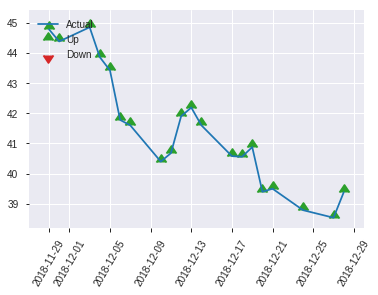


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.3175205963082493
RMSE: 0.5634896594510402
LogLoss: 2.6633537535663674
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 349.04545729516275
Residual deviance: 4970.139219496552
AIC: 5072.139219496552
AUC: 0.45988912960367023
pr_auc: 0.45460557774582494
Gini: -0.08022174079265953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.5134666200653143e-61: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    118  0        (0.0/118.0)
Total  0    251  0.5299   (133.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.51347e-61  0.639566  239
max f2                       2.51347e-61  0.816044  239
max f0point5                 2.51347e-61  0.525847  239
max accuracy                 0.525145     0.541833  12
max precision                0.542372     1         0
max recall                   2.51347e-61  1         239
max specificity              0.542372     1         0
max absolute_mcc             0.511222     0.158971  118
max min_per_class_accuracy   0.510115     0.432203  124
max mean_per_class_accuracy  0.521041     0.517077  37

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 37.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.533664           0.70904   0.70904            0.333333         0.537699     0.333333                    0.537699            0.00847458      0.00847458                 -29.096   -29.096
    2        0.0239044                   0.532687           0.70904   0.70904            0.333333         0.533158     0.333333                    0.535429            0.00847458      0.0169492                  -29.096   -29.096
    3        0.0318725                   0.528951           2.12712   1.06356            1                0.530848     0.5                         0.534283            0.0169492       0.0338983                  112.712   6.35593
    4        0.0438247                   0.526725           1.41808   1.16025            0.666667         0.527531     0.545455                    0.532442            0.0169492       0.0508475                  41.8079   16.0247
    5        0.0517928                   0.525129           2.12712   1.309              1                0.525578     0.615385                    0.531386            0.0169492       0.0677966                  112.712   30.8996
    6        0.103586                    0.522639           0.818123  1.06356            0.384615         0.523445     0.5                         0.527416            0.0423729       0.110169                   -18.1877  6.35593
    7        0.151394                    0.520913           1.24082   1.11954            0.583333         0.521779     0.526316                    0.525636            0.059322        0.169492                   24.0819   11.9536
    8        0.203187                    0.519594           0.818123  1.04271            0.384615         0.520163     0.490196                    0.524241            0.0423729       0.211864                   -18.1877  4.27052
    9        0.302789                    0.517273           1.02102   1.03557            0.48             0.518441     0.486842                    0.522333            0.101695        0.313559                   2.10169   3.55709
    10       0.40239                     0.513805           0.510508  0.905605           0.24             0.515592     0.425743                    0.520664            0.0508475       0.364407                   -48.9492  -9.4395
    11       0.501992                    0.509934           0.680678  0.860977           0.32             0.511796     0.404762                    0.518905            0.0677966       0.432203                   -31.9322  -13.9023
    12       0.601594                    0.498965           1.19119   0.915647           0.56             0.505779     0.430464                    0.516732            0.118644        0.550847                   19.1186   -8.43529
    13       0.701195                    0.354585           1.19119   0.954786           0.56             0.433911     0.448864                    0.504967            0.118644        0.669492                   19.1186   -4.52138
    14       0.800797                    0.0806475          1.02102   0.963024           0.48             0.191526     0.452736                    0.465982            0.101695        0.771186                   2.10169   -3.69761
    15       0.900398                    2.66402e-08        1.19119   0.988263           0.56             0.0140698    0.464602                    0.415992            0.118644        0.889831                   19.1186   -1.17369
    16       1                           3.81652e-242       1.1061    1                  0.52            

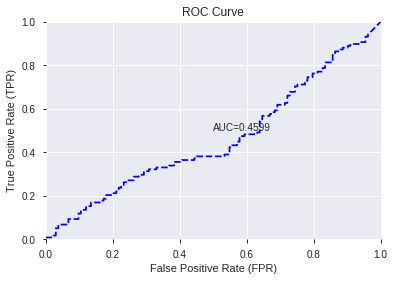

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


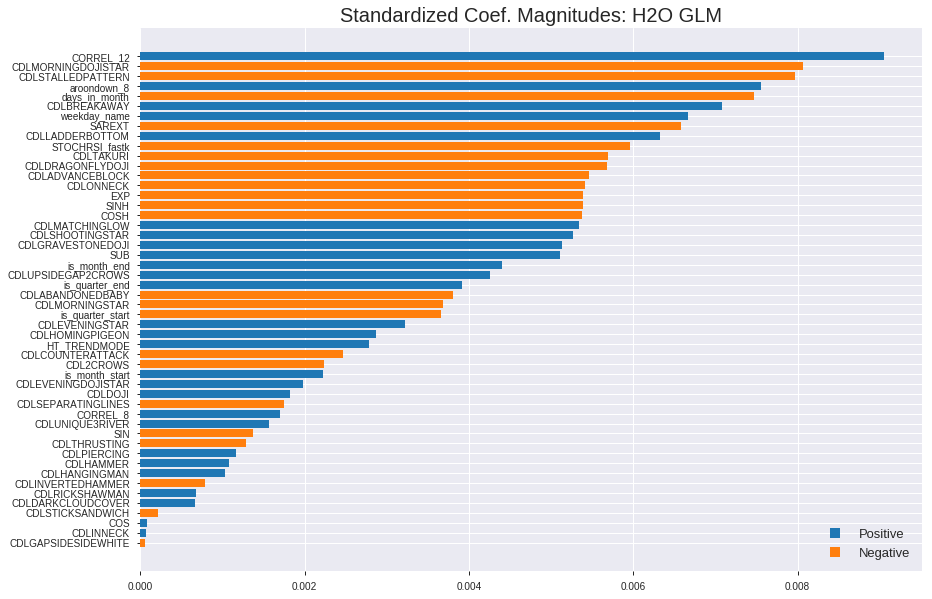

'log_likelihood'
--2019-08-27 16:13:56--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_161345_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_161345_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CORREL_12',
 'CDLMORNINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'aroondown_8',
 'days_in_month',
 'CDLBREAKAWAY',
 'weekday_name',
 'SAREXT',
 'CDLLADDERBOTTOM',
 'STOCHRSI_fastk',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLADVANCEBLOCK',
 'CDLONNECK',
 'EXP',
 'SINH',
 'COSH',
 'CDLMATCHINGLOW',
 'CDLSHOOTINGSTAR',
 'CDLGRAVESTONEDOJI',
 'SUB',
 'is_month_end',
 'CDLUPSIDEGAP2CROWS',
 'is_quarter_end',
 'CDLABANDONEDBABY',
 'CDLMORNINGSTAR',
 'is_quarter_start',
 'CDLEVENINGSTAR',
 'CDLHOMINGPIGEON',
 'HT_TRENDMODE',
 'CDLCOUNTERATTACK',
 'CDL2CROWS',
 'is_month_start',
 'CDLEVENINGDOJISTAR',
 'CDLDOJI',
 'CDLSEPARATINGLINES',
 'CORREL_8',
 'CDLUNIQUE3RIVER',
 'SIN',
 'CDLTHRUSTING',
 'CDLPIERCING',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLRICKSHAWMAN',
 'CDLDARKCLOUDCOVER',
 'CDLSTICKSANDWICH',
 'COS',
 'CDLINNECK',
 'CDLGAPSIDESIDEWHITE']

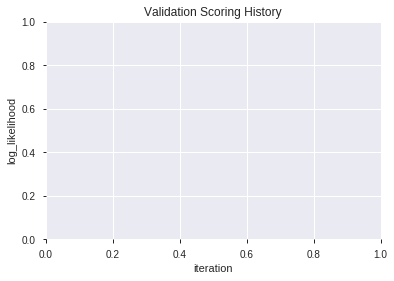

In [13]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_161453  0.475723  0.724457              0.500000  0.514574  0.264786
1  XGBoost_grid_1_AutoML_20190827_161453_model_1  0.452211  0.725364              0.496241  0.515282  0.265515
2               XGBoost_3_AutoML_20190827_161453  0.451510  0.720756              0.500000  0.513321  0.263498
3  XGBoost_grid_1_AutoML_20190827_161453_model_4  0.450236  0.716462              0.500000  0.511282  0.261409
4  XGBoost_grid_1_AutoML_20190827_161453_model_5  0.448260  0.756126              0.488722  0.528317  0.279119
5               XGBoost_2_AutoML_20190827_161453  0.444501  0.730011              0.492481  0.517512  0.267818
6  XGBoost_grid_1_AutoML_20190827_161453_model_6  0.440678  0.723166              0.492481  0.514453  0.264662
7  XGBoost_grid_1_AutoML_20190827_161453_model_2  0.430993  0.721666              0.500000  0.513835  0.264026
8  XGBoost_grid_1_AutoML_20190827_161453_model_7  0.428189  0.745653              0.492481  0.524356  0.274949
9  XGBoost_grid_1_AutoML_20190827_161453_model_3  0.427297  0.734014              0.500000  0.519282  0.269654

variable  relative_importance  scaled_importance  percentage
0        CORREL_12           701.258606           1.000000    0.124382
1         CORREL_8           700.887512           0.999471    0.124316
2             COSH           579.121094           0.825831    0.102718
3              COS           575.789612           0.821080    0.102127
4              SUB           575.485840           0.820647    0.102074
5              SIN           565.244812           0.806043    0.100257
6   STOCHRSI_fastk           497.661743           0.709669    0.088270
7           SAREXT           455.080780           0.648949    0.080717
8      aroondown_8           290.971344           0.414927    0.051609
9     weekday_name           228.579712           0.325956    0.040543
10             EXP           181.052856           0.258183    0.032113
11   days_in_month           122.978111           0.175368    0.021813
12            SINH            67.623604           0.096432    0.011994
13         CDLDOJI            45.609360           0.065039    0.008090
14    HT_TRENDMODE            40.449631           0.057681    0.007175
15  CDLRICKSHAWMAN             5.123523           0.007306    0.000909
16    is_month_end             5.037127           0.007183    0.000893

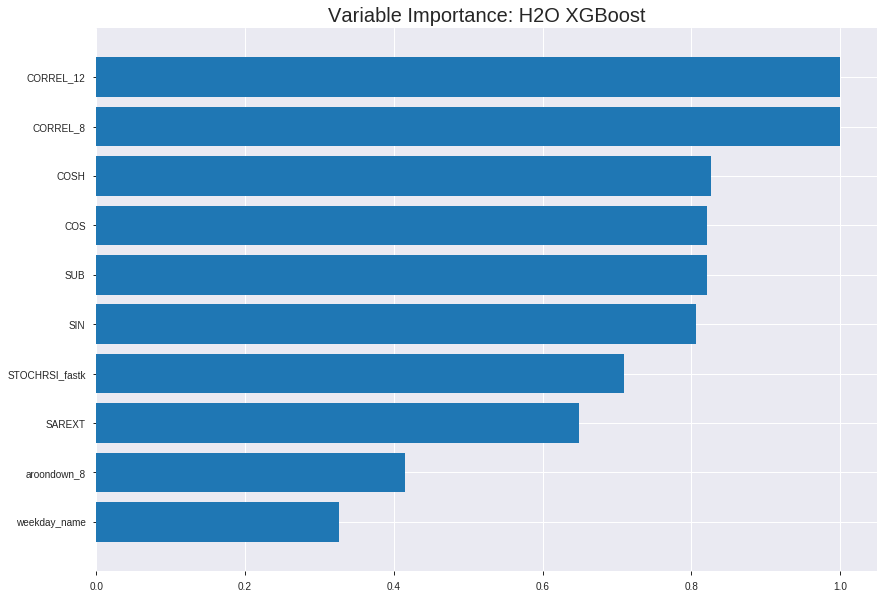

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_161453


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17944703045474822
RMSE: 0.42361188658340104
LogLoss: 0.5471684450340673
Mean Per-Class Error: 0.16175700428086426
AUC: 0.9149376890628216
pr_auc: 0.9187227629811263
Gini: 0.8298753781256432
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5029014050960541: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      680  171  0.2009   (171.0/851.0)
1      113  789  0.1253   (113.0/902.0)
Total  793  960  0.162    (284.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502901     0.847476  210
max f2                       0.440308     0.89503   263
max f0point5                 0.562045     0.858459  154
max accuracy                 0.511313     0.838562  201
max precision                0.82209      1         0
max recall                   0.306742     1         368
max specificity              0.82209      1         0
max absolute_mcc             0.505336     0.677265  207
max min_per_class_accuracy   0.515759     0.834313  197
max mean_per_class_accuracy  0.511313     0.838243  201

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.750307           1.94346    1.94346            1                0.768354  1                           0.768354            0.0199557       0.0199557                  94.3459   94.3459
    2        0.0205362                   0.731847           1.94346    1.94346            1                0.739717  1                           0.754036            0.0199557       0.0399113                  94.3459   94.3459
    3        0.0302339                   0.721935           1.94346    1.94346            1                0.726641  1                           0.745249            0.018847        0.0587583                  94.3459   94.3459
    4        0.040502                    0.715621           1.94346    1.94346            1                0.718859  1                           0.738558            0.0199557       0.078714                   94.3459   94.3459
    5        0.0501997                   0.705289           1.94346    1.94346            1                0.710756  1                           0.733188            0.018847        0.097561                   94.3459   94.3459
    6        0.100399                    0.671931           1.85512    1.89929            0.954545         0.687361  0.977273                    0.710274            0.0931264       0.190687                   85.512    89.9289
    7        0.150029                    0.648072           1.89878    1.89912            0.977011         0.659692  0.977186                    0.693542            0.094235        0.284922                   89.8782   89.9122
    8        0.200228                    0.623721           1.89929    1.89916            0.977273         0.636787  0.977208                    0.679313            0.0953437       0.380266                   89.9289   89.9164
    9        0.300057                    0.589591           1.73245    1.8437             0.891429         0.606202  0.948669                    0.654989            0.172949        0.553215                   73.2455   84.37
    10       0.399886                    0.555842           1.51035    1.76048            0.777143         0.572522  0.905849                    0.634401            0.150776        0.703991                   51.0345   76.048
    11       0.500285                    0.520191           1.2257     1.65316            0.630682         0.538666  0.850627                    0.615189            0.12306         0.827051                   22.5704   65.3159
    12       0.600114                    0.47973            0.888438   1.52595            0.457143         0.500252  0.785171                    0.596069            0.0886918       0.915743                   -11.1562  52.5948
    13       0.699943                    0.442158           0.410903   1.36692            0.211429         0.461889  0.703341                    0.576932            0.04102         0.956763                   -58.9097  36.6915
    14       0.799772                    0.402608           0.266532   1.22956            0.137143         0.422448  0.632668                    0.557649            0.0266075       0.98337                    -73.3468  22.9564
    15       0.899601                    0.346692           0.133266   1.10791            0.0685714        0.375388  0.57007                     0.537423            0.0133038       0.996674                   -86.6734  10.7907
    16       1                           0.198011           0.0331271  1                  0.0170455        0.30639   0.514546                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2621749811303527
RMSE: 0.5120302541162511
LogLoss: 0.7198002224519063
Mean Per-Class Error: 0.47077528770442156
AUC: 0.5110379674200645
pr_auc: 0.5060347013737527
Gini: 0.02207593484012893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23247216641902924: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    254  0        (0.0/254.0)
Total  0    501  0.493    (247.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.232472     0.672848   399
max f2                       0.232472     0.837179   399
max f0point5                 0.232472     0.562445   399
max accuracy                 0.541842     0.526946   142
max precision                0.600886     0.571429   88
max recall                   0.232472     1          399
max specificity              0.768156     0.995951   0
max absolute_mcc             0.329094     0.0927974  366
max min_per_class_accuracy   0.47817      0.519685   209
max mean_per_class_accuracy  0.541842     0.529225   142

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 48.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.714924           0.65748   0.65748            0.333333         0.727548  0.333333                    0.727548            0.00787402      0.00787402                 -34.252   -34.252
    2        0.0219561                   0.705923           0.788976  0.717251           0.4              0.709532  0.363636                    0.719359            0.00787402      0.015748                   -21.1024  -28.2749
    3        0.0319361                   0.687509           0.394488  0.616388           0.2              0.697134  0.3125                      0.712413            0.00393701      0.019685                   -60.5512  -38.3612
    4        0.0419162                   0.675688           0.788976  0.65748            0.4              0.681595  0.333333                    0.705076            0.00787402      0.0275591                  -21.1024  -34.252
    5        0.0518962                   0.667182           0.788976  0.682768           0.4              0.670708  0.346154                    0.698466            0.00787402      0.0354331                  -21.1024  -31.7232
    6        0.101796                    0.633127           1.10457   0.889532           0.56             0.64651   0.45098                     0.672997            0.0551181       0.0905512                  10.4567   -11.0468
    7        0.151697                    0.614738           1.34126   1.03813            0.68             0.624506  0.526316                    0.657046            0.0669291       0.15748                    34.126    3.81268
    8        0.201597                    0.602653           1.34126   1.11316            0.68             0.608571  0.564356                    0.645047            0.0669291       0.224409                   34.126    11.316
    9        0.301397                    0.555762           0.98622   1.07113            0.5              0.579542  0.543046                    0.623357            0.0984252       0.322835                   -1.37795  7.11269
    10       0.401198                    0.516255           1.02567   1.05982            0.52             0.535388  0.537313                    0.601474            0.102362        0.425197                   2.56693   5.9819
    11       0.500998                    0.47627            0.946772  1.0373             0.48             0.496187  0.525896                    0.580501            0.0944882       0.519685                   -5.32283  3.72996
    12       0.600798                    0.447606           0.867874  1.00916            0.44             0.462336  0.511628                    0.560872            0.0866142       0.606299                   -13.2126  0.915583
    13       0.700599                    0.411904           1.06512   1.01713            0.54             0.429104  0.51567                     0.542101            0.106299        0.712598                   6.51181   1.71277
    14       0.800399                    0.373217           0.749528  0.983761           0.38             0.391407  0.498753                    0.523312            0.0748031       0.787402                   -25.0472  -1.62389
    15       0.9002                      0.338967           0.98622   0.984034           0.5              0.357558  0.498891                    0.504935            0.0984252       0.885827                   -1.37795  -1.59663
    16       1                           0.232424           1.14402   1                  0.58             0.304548  0.506986                    0.484937    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:14:53  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.485454                         0.5                0.693147              0.5               0                    1                  0.493014
    2019-08-27 16:14:53  0.145 sec   5                  0.490095         0.673498            0.746199        0.7446             1.61955          0.367941                         0.500541           0.694232              0.500877          0.512958             0.98622            0.491018
    2019-08-27 16:14:53  0.236 sec   10                 0.48033          0.654403            0.807726        0.806335           1.72752          0.281803                         0.500186           0.693544              0.525654          0.521034             0.65748            0.493014
    2019-08-27 16:14:53  0.319 sec   15                 0.471795         0.637897            0.833043        0.828441           1.83549          0.239019                         0.500394           0.694023              0.533624          0.524508             0.65748            0.493014
    2019-08-27 16:14:53  0.400 sec   20                 0.46396          0.622839            0.847805        0.852942           1.94346          0.229892                         0.502939           0.699316              0.523224          0.521084             1.31496            0.491018
    2019-08-27 16:14:53  0.489 sec   25                 0.456358         0.608332            0.861868        0.868401           1.94346          0.226469                         0.505098           0.703979              0.517549          0.515182             0.65748            0.493014
    2019-08-27 16:14:54  0.576 sec   30                 0.449554         0.595432            0.87319         0.880722           1.94346          0.219053                         0.506094           0.706279              0.52112           0.512926             0.32874            0.493014
    2019-08-27 16:14:54  0.670 sec   35                 0.442403         0.581979            0.884602        0.890247           1.94346          0.204221                         0.507397           0.709195              0.519079          0.510841             0.65748            0.493014
    2019-08-27 16:14:54  0.758 sec   40                 0.43564          0.569357            0.896305        0.902303           1.94346          0.183115                         0.508633           0.712024              0.517477          0.511068             0.32874            0.493014
    2019-08-27 16:14:54  0.846 sec   45                 0.429954         0.558861            0.9057          0.909437           1.94346          0.175128                         0.510261           0.715651              0.513349          0.506684             0.32874            0.493014
    2019-08-27 16:14:54  0.945 sec   50                 0.423612         0.547168            0.914938        0.918723           1.94346          0.162008                         0.51203            0.7198                0.511038          0.506035             0.65748            0.493014

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
CORREL_12       701.259                1                    0.124382
CORREL_8        700.888                0.999471             0.124316
COSH            579.121                0.825831             0.102718
COS             575.79                 0.82108              0.102127
SUB             575.486                0.820647             0.102074
SIN             565.245                0.806043             0.100257
STOCHRSI_fastk  497.662                0.709669             0.0882699
SAREXT          455.081                0.648949             0.0807173
aroondown_8     290.971                0.414927             0.0516094
weekday_name    228.58                 0.325956             0.040543
EXP             181.053                0.258183             0.0321132
days_in_month   122.978                0.175368             0.0218125
SINH            67.6236                0.0964318            0.0119943
CDLDOJI         45.6094                0.0650393            0.0080897
HT_TRENDMODE    40.4496                0.0576815            0.00717452
CDLRICKSHAWMAN  5.12352                0.00730618           0.000908756
is_month_end    5.03713                0.00718298           0.000893431

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6395663956639567)

('auc', 0.47572320632088694)

('logloss', 0.7244573678418326)

('mean_per_class_error', 0.4881801962533453)

('rmse', 0.5145735847851338)

('mse', 0.2647859741586233)

xgboost prediction progress: |████████████████████████████████████████████| 100%


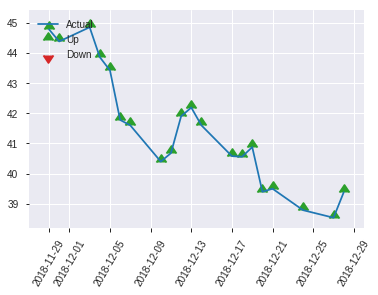


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2647859741586233
RMSE: 0.5145735847851338
LogLoss: 0.7244573678418326
Mean Per-Class Error: 0.4881801962533453
AUC: 0.47572320632088694
pr_auc: 0.4556903947614127
Gini: -0.048553587358226125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2599308490753174: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    118  0        (0.0/118.0)
Total  0    251  0.5299   (133.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.259931     0.639566   250
max f2                       0.259931     0.816044   250
max f0point5                 0.259931     0.525847   250
max accuracy                 0.674727     0.537849   13
max precision                0.7124       1          0
max recall                   0.259931     1          250
max specificity              0.7124       1          0
max absolute_mcc             0.33148      0.0955538  233
max min_per_class_accuracy   0.479428     0.473684   125
max mean_per_class_accuracy  0.659891     0.51182    15

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 48.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.704467           1.41808   1.41808            0.666667         0.709175  0.666667                    0.709175            0.0169492       0.0169492                  41.8079   41.8079
    2        0.0239044                   0.693132           0         0.70904            0                0.696613  0.333333                    0.702894            0               0.0169492                  -100      -29.096
    3        0.0318725                   0.688487           1.06356   0.797669           0.5              0.689621  0.375                       0.699576            0.00847458      0.0254237                  6.35593   -20.2331
    4        0.0438247                   0.682447           1.41808   0.966872           0.666667         0.685795  0.454545                    0.695817            0.0169492       0.0423729                  41.8079   -3.31279
    5        0.0517928                   0.675374           2.12712   1.14537            1                0.67649   0.538462                    0.692844            0.0169492       0.059322                   112.712   14.5372
    6        0.103586                    0.620922           0.818123  0.981747           0.384615         0.643515  0.461538                    0.668179            0.0423729       0.101695                   -18.1877  -1.82529
    7        0.151394                    0.597985           1.24082   1.06356            0.583333         0.608003  0.5                         0.649176            0.059322        0.161017                   24.0819   6.35593
    8        0.203187                    0.569021           0.654498  0.959289           0.307692         0.583942  0.45098                     0.632548            0.0338983       0.194915                   -34.5502  -4.07112
    9        0.302789                    0.534427           1.02102   0.979594           0.48             0.552847  0.460526                    0.606331            0.101695        0.29661                    2.10169   -2.04059
    10       0.40239                     0.502451           0.935932  0.968787           0.44             0.519095  0.455446                    0.584738            0.0932203       0.389831                   -6.40678  -3.12133
    11       0.501992                    0.479428           0.850847  0.945386           0.4              0.494109  0.444444                    0.566756            0.0847458       0.474576                   -14.9153  -5.46139
    12       0.601594                    0.456694           1.19119   0.986081           0.56             0.464751  0.463576                    0.549868            0.118644        0.59322                    19.1186   -1.39185
    13       0.701195                    0.430402           0.765763  0.954786           0.36             0.441453  0.448864                    0.534468            0.0762712       0.669492                   -23.4237  -4.52138
    14       0.800797                    0.391811           0.935932  0.952441           0.44             0.409174  0.447761                    0.518884            0.0932203       0.762712                   -6.40678  -4.75588
    15       0.900398                    0.358606           1.27627   0.988263           0.6              0.371915  0.464602                    0.502626            0.127119        0.889831                   27.6271   -1.17369
    16       1                           0.259931           1.1061    1                  0.52             0.308481  0.47012                     0.4832

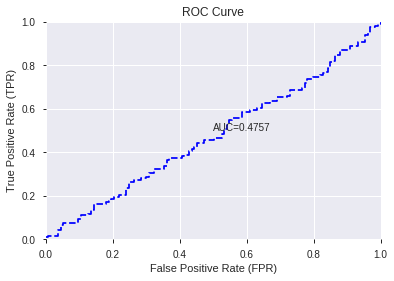

This function is available for GLM models only


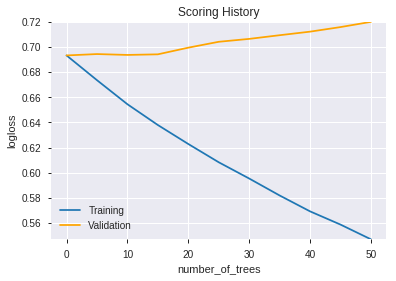

--2019-08-27 16:15:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_161453',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_161453',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_985e',
   'type

['CORREL_12',
 'CORREL_8',
 'COSH',
 'COS',
 'SUB',
 'SIN',
 'STOCHRSI_fastk',
 'SAREXT',
 'aroondown_8',
 'weekday_name',
 'EXP',
 'days_in_month',
 'SINH',
 'CDLDOJI',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'is_month_end']

In [14]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_161613_model_1  0.458009  2.524081                   0.5  0.559039  0.312525

variable  relative_importance  scaled_importance    percentage
0                    CORREL_12         8.084287e-03           1.000000  1.009797e-02
1            CDLSTALLEDPATTERN         8.058258e-03           0.996780  1.006545e-02
2           CDLMORNINGDOJISTAR         7.976578e-03           0.986677  9.963429e-03
3                days_in_month         7.064823e-03           0.873896  8.824569e-03
4                 CDLBREAKAWAY         6.668213e-03           0.824836  8.329169e-03
...                        ...                  ...                ...           ...
1037                      SQRT         2.455865e-06           0.000304  3.067585e-06
1038  BBANDS_middleband_14_3_4         2.422586e-06           0.000300  3.026017e-06
1039  BBANDS_middleband_14_3_3         2.151991e-06           0.000266  2.688021e-06
1040  BBANDS_middleband_20_1_2         1.332855e-07           0.000016  1.664850e-07
1041   BBANDS_upperband_24_7_5         6.909791e-08           0.000009  8.630921e-08

[1042 rows x 4 columns]

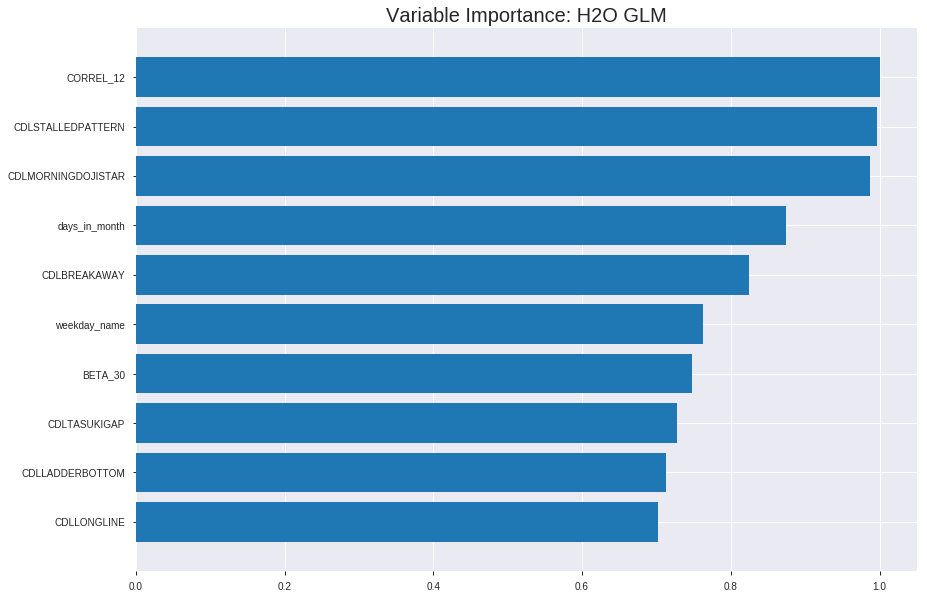

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_161613_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24636191340502
RMSE: 0.4963485805409541
LogLoss: 0.6858473718382528
Null degrees of freedom: 1752
Residual degrees of freedom: 710
Null deviance: 2428.6900635089887
Residual deviance: 2404.5808856649146
AIC: 4490.580885664915
AUC: 0.5893568542030897
pr_auc: 0.5895899387293978
Gini: 0.1787137084061794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4622333810920612: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   831   0.9765   (831.0/851.0)
1      4    898   0.0044   (4.0/902.0)
Total  24   1729  0.4763   (835.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462233     0.68263   378
max f2                       0.451076     0.841899  389
max f0point5                 0.496632     0.597317  278
max accuracy                 0.496632     0.575014  278
max precision                0.602727     1         0
max recall                   0.44268      1         395
max specificity              0.602727     1         0
max absolute_mcc             0.496632     0.157021  278
max min_per_class_accuracy   0.512739     0.561692  204
max mean_per_class_accuracy  0.496632     0.567695  278

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.577969           1.29564   1.29564            0.666667         0.586243  0.666667                    0.586243            0.0133038       0.0133038                  29.5639    29.5639
    2        0.0205362                   0.572114           1.40361   1.34962            0.722222         0.574643  0.694444                    0.580443            0.0144124       0.0277162                  40.3609    34.9624
    3        0.0302339                   0.566368           1.02889   1.24675            0.529412         0.569891  0.641509                    0.577059            0.00997783      0.037694                   2.889      24.6747
    4        0.040502                    0.563044           1.51158   1.31389            0.777778         0.5647    0.676056                    0.573925            0.0155211       0.0532151                  51.1579    31.3888
    5        0.0501997                   0.560124           1.48617   1.34717            0.764706         0.560998  0.693182                    0.571428            0.0144124       0.0676275                  48.6175    34.717
    6        0.100399                    0.549396           1.14841   1.24779            0.590909         0.554139  0.642045                    0.562783            0.0576497       0.125277                   14.8408    24.7789
    7        0.150029                    0.5418             1.13927   1.21189            0.586207         0.545549  0.623574                    0.557082            0.056541        0.181818                   13.9269    21.1891
    8        0.200228                    0.535486           1.28092   1.2292             0.659091         0.538746  0.632479                    0.552485            0.0643016       0.24612                    28.0916    22.9196
    9        0.300057                    0.52711            1.06613   1.17494            0.548571         0.531121  0.604563                    0.545377            0.10643         0.35255                    6.61261    17.4943
    10       0.399886                    0.519557           0.999493  1.13114            0.514286         0.523309  0.582026                    0.539868            0.0997783       0.452328                   -0.050681  13.1143
    11       0.500285                    0.51282            1.08215   1.12131            0.556818         0.51627   0.576967                    0.535132            0.108647        0.560976                   8.21533    12.1312
    12       0.600114                    0.506026           0.93286   1.08996            0.48             0.509337  0.560837                    0.530841            0.0931264       0.654102                   -6.71397   8.99627
    13       0.699943                    0.499564           1.04392   1.0834             0.537143         0.502914  0.557457                    0.526858            0.104213        0.758315                   4.39151    8.33952
    14       0.799772                    0.493683           0.955071  1.06738            0.491429         0.496658  0.549215                    0.523089            0.0953437       0.853659                   -4.49287   6.73776
    15       0.899601                    0.483143           0.710751  1.0278             0.365714         0.488862  0.528852                    0.51929             0.0709534       0.924612                   -28.9249   2.78027
    16       1                           0.424801           0.750882  1                  0.386364         0.47204   0.514546                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.31384700910494473
RMSE: 0.5602205004325929
LogLoss: 3.7200864740814943
Null degrees of freedom: 500
Residual degrees of freedom: -542
Null deviance: 694.5502849840166
Residual deviance: 11770.863838412273
AIC: 13856.863838412273
AUC: 0.5486706621186521
pr_auc: 0.5439829580451345
Gini: 0.09734132423730424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.4175565580090902e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    254  0        (0.0/254.0)
Total  0    501  0.493    (247.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.41756e-08  0.672848  399
max f2                       2.41756e-08  0.837179  399
max f0point5                 0.447967     0.57418   281
max accuracy                 0.453992     0.562874  275
max precision                0.588257     1         0
max recall                   2.41756e-08  1         399
max specificity              0.588257     1         0
max absolute_mcc             0.447967     0.125059  281
max min_per_class_accuracy   0.480338     0.550607  245
max mean_per_class_accuracy  0.453992     0.562036  275

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 33.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.577651           1.6437    1.6437             0.833333         0.583427     0.833333                    0.583427            0.019685        0.019685                   64.3701   64.3701
    2        0.0219561                   0.567759           1.18346   1.4345             0.6              0.569507     0.727273                    0.577099            0.011811        0.0314961                  18.3465   43.4503
    3        0.0319361                   0.558854           0.394488  1.1095             0.2              0.561974     0.5625                      0.572373            0.00393701      0.0354331                  -60.5512  10.9498
    4        0.0419162                   0.553059           0.788976  1.03318            0.4              0.555266     0.52381                     0.5683              0.00787402      0.0433071                  -21.1024  3.31834
    5        0.0518962                   0.550333           0.788976  0.98622            0.4              0.551849     0.5                         0.565136            0.00787402      0.0511811                  -21.1024  -1.37795
    6        0.101796                    0.539729           1.18346   1.08291            0.6              0.544158     0.54902                     0.554852            0.0590551       0.110236                   18.3465   8.29088
    7        0.151697                    0.530862           1.02567   1.06408            0.52             0.533812     0.539474                    0.547931            0.0511811       0.161417                   2.56693   6.408
    8        0.201597                    0.521173           1.34126   1.13269            0.68             0.525507     0.574257                    0.542381            0.0669291       0.228346                   34.126    13.2689
    9        0.301397                    0.508935           1.06512   1.11031            0.54             0.514146     0.562914                    0.533031            0.106299        0.334646                   6.51181   11.0314
    10       0.401198                    0.496776           1.06512   1.09907            0.54             0.502796     0.557214                    0.52551             0.106299        0.440945                   6.51181   9.90716
    11       0.500998                    0.480338           1.10457   1.10017            0.56             0.489362     0.557769                    0.518309            0.110236        0.551181                   10.4567   10.0166
    12       0.600798                    0.407016           0.907323  1.06813            0.46             0.45568      0.541528                    0.507906            0.0905512       0.641732                   -9.26772  6.81325
    13       0.700599                    0.113628           0.946772  1.05084            0.48             0.255541     0.532764                    0.471956            0.0944882       0.73622                    -5.32283  5.08446
    14       0.800399                    1.94081e-05        0.749528  1.01327            0.38             0.0294004    0.513716                    0.416775            0.0748031       0.811024                   -25.0472  1.32739
    15       0.9002                      1.65629e-26        0.98622   1.01027            0.5              9.93317e-07  0.512195                    0.370569            0.0984252       0.909449                   -1.37795  1.02746
    16       1                           0                  0.907323  1                  0.46             2.677


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:16:17  0.000 sec   2            2.8       1043          1.37169           23.4947
    2019-08-27 16:16:19  2.246 sec   4            2         1043          1.3686            29.8958
    2019-08-27 16:16:22  4.517 sec   6            1.5       1043          1.365             36.1689
    2019-08-27 16:16:24  6.764 sec   8            1.1       1043          1.36084           41.5992
    2019-08-27 16:16:26  9.052 sec   10           0.78      1043          1.35613           46.5133

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6395663956639567)

('auc', 0.4580094303555499)

('logloss', 2.5240812101385073)

('mean_per_class_error', 0.47170893335032493)

('rmse', 0.5590392224351748)

('mse', 0.3125248522209248)

glm prediction progress: |████████████████████████████████████████████████| 100%


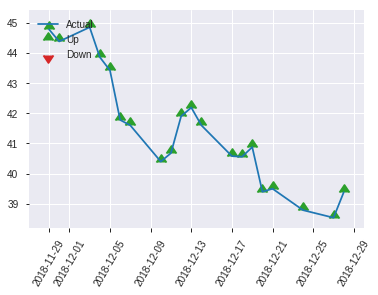


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.3125248522209248
RMSE: 0.5590392224351748
LogLoss: 2.5240812101385073
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 349.04545729516275
Residual deviance: 3836.143465001691
AIC: 5922.143465001691
AUC: 0.4580094303555499
pr_auc: 0.4724763039782695
Gini: -0.08398113928890016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.539659363470201e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    118  0        (0.0/118.0)
Total  0    251  0.5299   (133.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       4.53966e-49  0.639566  240
max f2                       4.53966e-49  0.816044  240
max f0point5                 4.53966e-49  0.525847  240
max accuracy                 0.542329     0.553785  17
max precision                0.579093     1         0
max recall                   4.53966e-49  1         240
max specificity              0.579093     1         0
max absolute_mcc             0.493913     0.140177  109
max min_per_class_accuracy   0.487608     0.443609  126
max mean_per_class_accuracy  0.542329     0.528291  17

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 37.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.565599           1.41808   1.41808            0.666667         0.57365      0.666667                    0.57365             0.0169492       0.0169492                  41.8079   41.8079
    2        0.0239044                   0.556397           2.12712   1.7726             1                0.560304     0.833333                    0.566977            0.0254237       0.0423729                  112.712   77.2599
    3        0.0318725                   0.554385           1.06356   1.59534            0.5              0.555242     0.75                        0.564043            0.00847458      0.0508475                  6.35593   59.5339
    4        0.0438247                   0.552354           0.70904   1.35362            0.333333         0.553056     0.636364                    0.561047            0.00847458      0.059322                   -29.096   35.3621
    5        0.0517928                   0.546401           1.06356   1.309              0.5              0.549483     0.615385                    0.559268            0.00847458      0.0677966                  6.35593   30.8996
    6        0.103586                    0.538914           0.818123  1.06356            0.384615         0.54131      0.5                         0.550289            0.0423729       0.110169                   -18.1877  6.35593
    7        0.151394                    0.532822           1.24082   1.11954            0.583333         0.536162     0.526316                    0.545828            0.059322        0.169492                   24.0819   11.9536
    8        0.203187                    0.527528           0.490874  0.959289           0.230769         0.530585     0.45098                     0.541943            0.0254237       0.194915                   -50.9126  -4.07112
    9        0.302789                    0.51452            1.02102   0.979594           0.48             0.520311     0.460526                    0.534827            0.101695        0.29661                    2.10169   -2.04059
    10       0.40239                     0.500163           0.510508  0.863484           0.24             0.505957     0.405941                    0.527681            0.0508475       0.347458                   -48.9492  -13.6516
    11       0.501992                    0.488205           0.935932  0.877858           0.44             0.492245     0.412698                    0.52065             0.0932203       0.440678                   -6.40678  -12.2142
    12       0.601594                    0.476308           1.1061    0.915647           0.52             0.482257     0.430464                    0.514294            0.110169        0.550847                   10.6102   -8.43529
    13       0.701195                    0.366083           1.1061    0.9427             0.52             0.427653     0.443182                    0.501987            0.110169        0.661017                   10.6102   -5.72997
    14       0.800797                    0.134244           1.1061    0.963024           0.52             0.237703     0.452736                    0.469116            0.110169        0.771186                   10.6102   -3.69761
    15       0.900398                    1.50813e-06        1.19119   0.988263           0.56             0.0298182    0.464602                    0.420521            0.118644        0.889831                   19.1186   -1.17369
    16       1                           1.34519e-183       1.1061    1                  0.52         

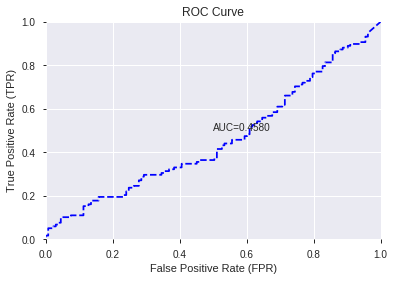

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


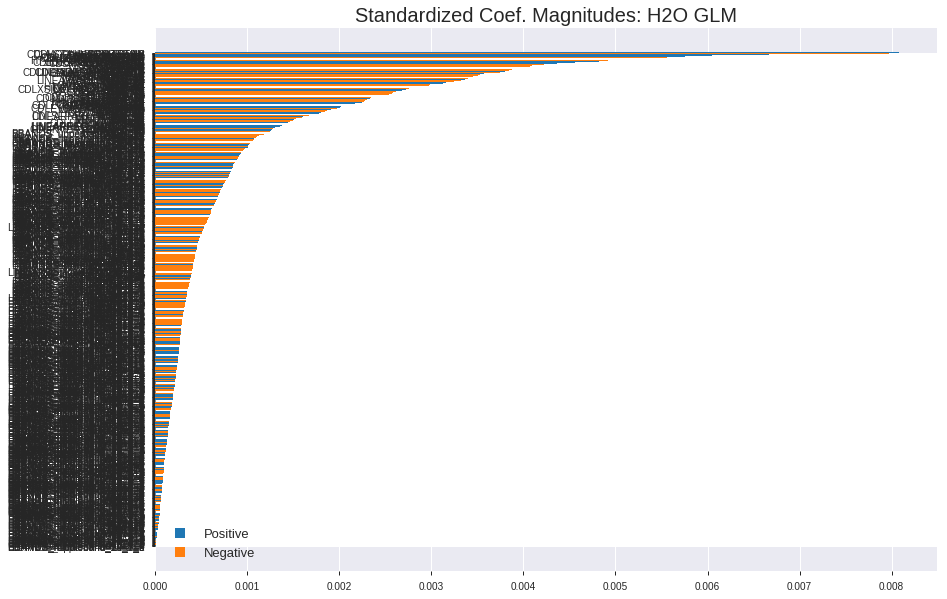

'log_likelihood'
--2019-08-27 16:16:58--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.10.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.10.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_161613_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_161613_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

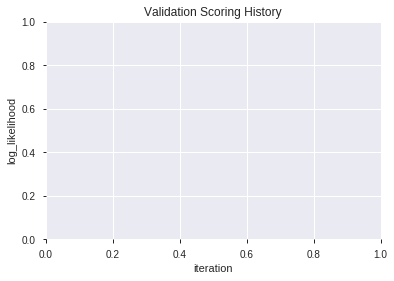

In [15]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [16]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [17]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [18]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_161755_model_1  0.502804  0.709680              0.500000  0.507730  0.257790
1               XGBoost_2_AutoML_20190827_161755  0.478336  0.722089              0.500000  0.513475  0.263656
2  XGBoost_grid_1_AutoML_20190827_161755_model_6  0.473620  0.717478              0.496241  0.511495  0.261627
3  XGBoost_grid_1_AutoML_20190827_161755_model_4  0.470116  0.709688              0.484962  0.508021  0.258086
4  XGBoost_grid_1_AutoML_20190827_161755_model_2  0.460048  0.713876              0.500000  0.509980  0.260079
5               XGBoost_3_AutoML_20190827_161755  0.454441  0.722445              0.500000  0.513796  0.263987
6  XGBoost_grid_1_AutoML_20190827_161755_model_5  0.447814  0.758019              0.500000  0.528994  0.279834
7  XGBoost_grid_1_AutoML_20190827_161755_model_3  0.435453  0.744135              0.500000  0.523100  0.273634
8  XGBoost_grid_1_AutoML_20190827_161755_model_7  0.430610  0.741115              0.489200  0.522266  0.272762
9               XGBoost_1_AutoML_20190827_161755  0.415254  0.743362              0.496241  0.523534  0.274088

variable  relative_importance  scaled_importance  percentage
0                        COS           184.885269           1.000000    0.038434
1                        DIV           133.389389           0.721471    0.027729
2                  CORREL_24            99.970581           0.540717    0.020782
3                  PLUS_DM_8            98.650566           0.533577    0.020507
4                 MINUS_DM_8            93.352180           0.504920    0.019406
..                       ...                  ...                ...         ...
220        MACDFIX_signal_24             3.466605           0.018750    0.000721
221  BBANDS_lowerband_24_3_3             3.323347           0.017975    0.000691
222       LINEARREG_SLOPE_20             2.946626           0.015938    0.000613
223                 SAR_0.14             2.209579           0.011951    0.000459
224  BBANDS_upperband_20_1_5             2.163560           0.011702    0.000450

[225 rows x 4 columns]

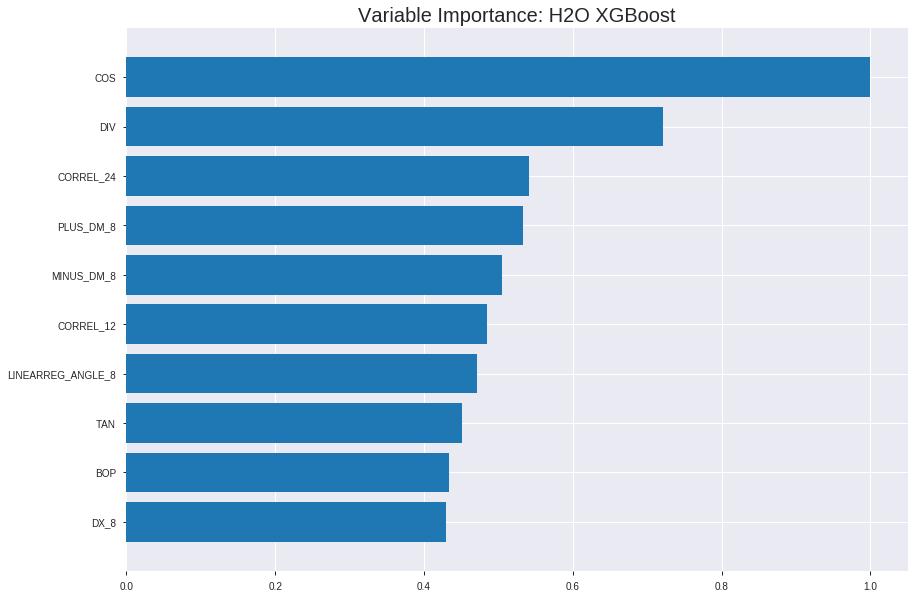

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_161755_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18466078016090884
RMSE: 0.42972174736788554
LogLoss: 0.5591540620596789
Mean Per-Class Error: 0.136947272154059
AUC: 0.9433319610944213
pr_auc: 0.9483945454453814
Gini: 0.8866639221888426
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5162645056843758: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      726  125  0.1469   (125.0/851.0)
1      120  782  0.133    (120.0/902.0)
Total  846  907  0.1398   (245.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516265     0.864566  192
max f2                       0.461121     0.912015  252
max f0point5                 0.548929     0.891987  159
max accuracy                 0.523929     0.862521  185
max precision                0.771665     1         0
max recall                   0.39927      1         311
max specificity              0.771665     1         0
max absolute_mcc             0.523929     0.725884  185
max min_per_class_accuracy   0.518388     0.857814  190
max mean_per_class_accuracy  0.523929     0.863053  185

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.7126             1.94346   1.94346            1                0.729879  1                           0.729879            0.0199557       0.0199557                  94.3459   94.3459
    2        0.0205362                   0.694108           1.94346   1.94346            1                0.703895  1                           0.716887            0.0199557       0.0399113                  94.3459   94.3459
    3        0.0302339                   0.684507           1.94346   1.94346            1                0.6882    1                           0.707685            0.018847        0.0587583                  94.3459   94.3459
    4        0.040502                    0.677663           1.94346   1.94346            1                0.681028  1                           0.700927            0.0199557       0.078714                   94.3459   94.3459
    5        0.0501997                   0.671498           1.94346   1.94346            1                0.673795  1                           0.695686            0.018847        0.097561                   94.3459   94.3459
    6        0.100399                    0.645185           1.94346   1.94346            1                0.656993  1                           0.676339            0.097561        0.195122                   94.3459   94.3459
    7        0.150029                    0.62297            1.94346   1.94346            1                0.633899  1                           0.6623              0.0964523       0.291574                   94.3459   94.3459
    8        0.200228                    0.605678           1.89929   1.93239            0.977273         0.614384  0.994302                    0.650287            0.0953437       0.386918                   89.9289   93.2385
    9        0.300057                    0.575173           1.84351   1.90282            0.948571         0.589205  0.979087                    0.629965            0.184035        0.570953                   84.351    90.2816
    10       0.399886                    0.547711           1.6214    1.83256            0.834286         0.561728  0.942939                    0.61293             0.161863        0.732816                   62.14     83.2563
    11       0.500285                    0.521109           1.17049   1.6997             0.602273         0.534505  0.874572                    0.597191            0.117517        0.850333                   17.0492   69.9696
    12       0.600114                    0.490854           0.799595  1.54996            0.411429         0.505765  0.797529                    0.581983            0.0798226       0.930155                   -20.0405  54.9964
    13       0.699943                    0.455768           0.455325  1.39384            0.234286         0.474396  0.717196                    0.566638            0.0454545       0.97561                    -54.4675  39.3842
    14       0.799772                    0.420196           0.22211   1.24758            0.114286         0.438881  0.64194                     0.550691            0.0221729       0.997783                   -77.789   24.7584
    15       0.899601                    0.375964           0.022211  1.1116             0.0114286        0.399375  0.571972                    0.5339              0.00221729      1                          -97.7789  11.1604
    16       1                           0.221934           0         1                  0                0.330107  0.514546                    0.513439         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.259381567498442
RMSE: 0.5092951673621516
LogLoss: 0.7127642130659533
Mean Per-Class Error: 0.4849851764480857
AUC: 0.49095444547164396
pr_auc: 0.500438790201109
Gini: -0.018091109056712074
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2872593104839325: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    239  0.9676   (239.0/247.0)
1      3    251  0.0118   (3.0/254.0)
Total  11   490  0.483    (242.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.287259     0.674731   388
max f2                       0.23447      0.837179   399
max f0point5                 0.287259     0.566847   388
max accuracy                 0.287259     0.516966   388
max precision                0.692436     1          0
max recall                   0.23447      1          399
max specificity              0.692436     1          0
max absolute_mcc             0.287259     0.0702048  388
max min_per_class_accuracy   0.508833     0.511811   199
max mean_per_class_accuracy  0.508833     0.515015   199

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.668808           0.98622   0.98622            0.5              0.680509  0.5                         0.680509            0.011811        0.011811                   -1.37795  -1.37795
    2        0.0219561                   0.656679           1.18346   1.07588            0.6              0.662908  0.545455                    0.672509            0.011811        0.023622                   18.3465   7.58769
    3        0.0319361                   0.648796           0         0.739665           0                0.651516  0.375                       0.665948            0               0.023622                   -100      -26.0335
    4        0.0419162                   0.64378            1.57795   0.939258           0.8              0.645917  0.47619                     0.661179            0.015748        0.0393701                  57.7953   -6.07424
    5        0.0518962                   0.639423           1.18346   0.98622            0.6              0.64092   0.5                         0.657283            0.011811        0.0511811                  18.3465   -1.37795
    6        0.101796                    0.614316           1.18346   1.08291            0.6              0.625255  0.54902                     0.641583            0.0590551       0.110236                   18.3465   8.29088
    7        0.151697                    0.586674           0.710079  0.960267           0.36             0.601391  0.486842                    0.628362            0.0354331       0.145669                   -28.9921  -3.97327
    8        0.201597                    0.578532           0.946772  0.956927           0.48             0.582473  0.485149                    0.617003            0.0472441       0.192913                   -5.32283  -4.30732
    9        0.301397                    0.553113           1.02567   0.979689           0.52             0.564898  0.496689                    0.59975             0.102362        0.295276                   2.56693   -2.03108
    10       0.401198                    0.529085           0.867874  0.951874           0.44             0.541061  0.482587                    0.585151            0.0866142       0.38189                    -13.2126  -4.81255
    11       0.500998                    0.508465           1.34126   1.02944            0.68             0.519137  0.521912                    0.572               0.133858        0.515748                   34.126    2.94413
    12       0.600798                    0.490691           0.907323  1.00916            0.46             0.498601  0.511628                    0.559808            0.0905512       0.606299                   -9.26772  0.915583
    13       0.700599                    0.46387            0.867874  0.98903            0.44             0.478817  0.501425                    0.548271            0.0866142       0.692913                   -13.2126  -1.09698
    14       0.800399                    0.42745            0.98622   0.98868            0.5              0.446529  0.501247                    0.535585            0.0984252       0.791339                   -1.37795  -1.13201
    15       0.9002                      0.383047           0.98622   0.988407           0.5              0.409059  0.501109                    0.521558            0.0984252       0.889764                   -1.37795  -1.15928
    16       1                           0.23447            1.10457   1                  0.56             0.320376  0.506986                    0.501


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:18:15  0.014 sec   0                  0.5              0.693147            0.5             0                  1                0.485454                         0.5                0.693147              0.5               0                    1                  0.493014
    2019-08-27 16:18:16  1.162 sec   5                  0.487911         0.669211            0.80675         0.814725           1.94346          0.281803                         0.500635           0.694422              0.494246          0.498384             0.98622            0.493014
    2019-08-27 16:18:16  1.405 sec   10                 0.479004         0.65181             0.836953        0.844176           1.94346          0.262407                         0.502173           0.697528              0.48257           0.499354             1.6437             0.493014
    2019-08-27 16:18:16  1.644 sec   15                 0.471528         0.637365            0.855437        0.863763           1.94346          0.22818                          0.501363           0.695931              0.513405          0.518299             0.98622            0.493014
    2019-08-27 16:18:17  1.885 sec   20                 0.465721         0.626209            0.871564        0.877983           1.94346          0.212778                         0.503709           0.700753              0.498661          0.511852             0.98622            0.48503
    2019-08-27 16:18:17  2.151 sec   25                 0.458224         0.611999            0.893988        0.898708           1.94346          0.204221                         0.50423            0.70189               0.504104          0.522627             1.31496            0.48503
    2019-08-27 16:18:17  2.394 sec   30                 0.451996         0.600285            0.906255        0.913006           1.94346          0.183115                         0.505055           0.703604              0.503315          0.51829              0.98622            0.481038
    2019-08-27 16:18:17  2.637 sec   35                 0.446133         0.589372            0.917613        0.923664           1.94346          0.172276                         0.505672           0.704952              0.503204          0.519327             1.31496            0.48503
    2019-08-27 16:18:17  2.879 sec   40                 0.440492         0.578971            0.931589        0.937448           1.94346          0.157444                         0.506085           0.705869              0.505252          0.515172             1.31496            0.48503
    2019-08-27 16:18:18  3.142 sec   45                 0.435312         0.569325            0.936106        0.942181           1.94346          0.155733                         0.508079           0.710098              0.493385          0.505711             0.98622            0.483034
    2019-08-27 16:18:18  3.394 sec   50                 0.429722         0.559154            0.943332        0.948395           1.94346          0.13976                          0.509295           0.712764              0.490954          0.500439             0.98622            0.483034

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
COS                      184.88526916503906     1.0                   0.03843391291740615
DIV                      133.38938903808594     0.7214711568990119    0.02772895961667689
CORREL_24                99.9705810546875       0.5407168537881084    0.020781864471465995
PLUS_DM_8                98.65056610107422      0.5335772100535123    0.020507460025909224
MINUS_DM_8               93.35218048095703      0.5049195152352868    0.01940603267885194
---                      ---                    ---                   ---
MACDFIX_signal_24        3.4666051864624023     0.018750034559908146  0.0007206371954738655
BBANDS_lowerband_24_3_3  3.3233470916748047     0.017975185944685494  0.0006908567312722254
LINEARREG_SLOPE_20       2.9466261863708496     0.01593759307963321   0.0006125440645356777
SAR_0.14                 2.209578514099121      0.011951079304899765  0.00045932674127353244
BBANDS_upperband_20_1_5  2.163559913635254      0.011702175751513971  0.00044976040377786987


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.549800796812749)

('F1', 0.6395663956639567)

('auc', 0.5028036192175354)

('logloss', 0.7096799252333121)

('mean_per_class_error', 0.46447687014145533)

('rmse', 0.5077303057124847)

('mse', 0.2577900633388931)

xgboost prediction progress: |████████████████████████████████████████████| 100%


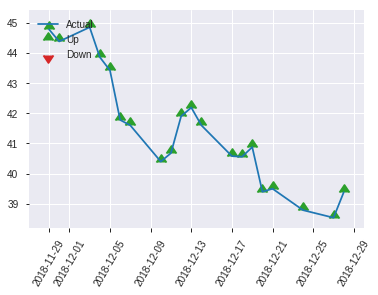


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2577900633388931
RMSE: 0.5077303057124847
LogLoss: 0.7096799252333121
Mean Per-Class Error: 0.46447687014145533
AUC: 0.5028036192175354
pr_auc: 0.48055551180978895
Gini: 0.005607238435070716
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2579498887062073: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    118  0        (0.0/118.0)
Total  0    251  0.5299   (133.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25795      0.639566  250
max f2                       0.25795      0.816044  250
max f0point5                 0.25795      0.525847  250
max accuracy                 0.577859     0.549801  58
max precision                0.709085     0.6       4
max recall                   0.25795      1         250
max specificity              0.739204     0.992481  0
max absolute_mcc             0.29787      0.116767  247
max min_per_class_accuracy   0.511592     0.496241  125
max mean_per_class_accuracy  0.570976     0.535523  64

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 51.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.713282           0.70904   0.70904            0.333333         0.727418  0.333333                    0.727418            0.00847458      0.00847458                 -29.096   -29.096
    2        0.0239044                   0.7051             1.41808   1.06356            0.666667         0.708413  0.5                         0.717915            0.0169492       0.0254237                  41.8079   6.35593
    3        0.0318725                   0.682824           1.06356   1.06356            0.5              0.684103  0.5                         0.709462            0.00847458      0.0338983                  6.35593   6.35593
    4        0.0438247                   0.66595            1.41808   1.16025            0.666667         0.675507  0.545455                    0.700202            0.0169492       0.0508475                  41.8079   16.0247
    5        0.0517928                   0.660554           0         0.981747           0                0.660906  0.461538                    0.694156            0               0.0508475                  -100      -1.82529
    6        0.103586                    0.612712           1.14537   1.06356            0.538462         0.635815  0.5                         0.664986            0.059322        0.110169                   14.5372   6.35593
    7        0.151394                    0.596459           1.41808   1.17551            0.666667         0.603695  0.552632                    0.645631            0.0677966       0.177966                   41.8079   17.5513
    8        0.203187                    0.586517           0.981747  1.12612            0.461538         0.590909  0.529412                    0.631682            0.0508475       0.228814                   -1.82529  12.6122
    9        0.302789                    0.55272            0.935932  1.06356            0.44             0.572539  0.5                         0.612227            0.0932203       0.322034                   -6.40678  6.35593
    10       0.40239                     0.532208           0.680678  0.968787           0.32             0.540145  0.455446                    0.594385            0.0677966       0.389831                   -31.9322  -3.12133
    11       0.501992                    0.511592           1.1061    0.996032           0.52             0.519223  0.468254                    0.579472            0.110169        0.5                        10.6102   -0.396825
    12       0.601594                    0.493211           1.19119   1.02834            0.56             0.500695  0.483444                    0.566429            0.118644        0.618644                   19.1186   2.83421
    13       0.701195                    0.475721           0.935932  1.01522            0.44             0.483981  0.477273                    0.554718            0.0932203       0.711864                   -6.40678  1.52157
    14       0.800797                    0.458503           0.680678  0.973607           0.32             0.46653   0.457711                    0.543749            0.0677966       0.779661                   -31.9322  -2.63935
    15       0.900398                    0.434053           1.02102   0.978851           0.48             0.446476  0.460177                    0.532989            0.101695        0.881356                   2.10169   -2.11489
    16       1                           0.25795            1.19119   1                  0.56             0.381607  0.47012                     0.517911   

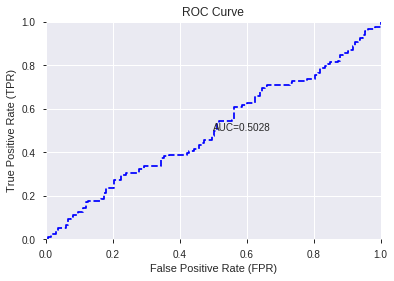

This function is available for GLM models only


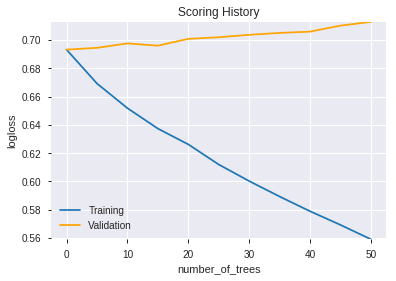

--2019-08-27 16:19:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.170.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.170.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_161755_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_161755_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [19]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_161959_model_8  0.504428  1.371954              0.496241  0.529974  0.280873
1  DeepLearning_grid_1_AutoML_20190827_161959_model_5  0.494871  3.514707              0.500000  0.584629  0.341791
2  DeepLearning_grid_1_AutoML_20190827_161959_model_1  0.481171  6.630015              0.500000  0.613046  0.375825
3  DeepLearning_grid_1_AutoML_20190827_161959_model_3  0.478909  6.727575              0.500000  0.607483  0.369036
4  DeepLearning_grid_1_AutoML_20190827_161959_model_6  0.477571  2.967961              0.500000  0.573736  0.329173
5  DeepLearning_grid_1_AutoML_20190827_161959_model_7  0.474449  2.788941              0.500000  0.591020  0.349305
6  DeepLearning_grid_1_AutoML_20190827_161959_model_9  0.473206  0.694242              0.500000  0.500547  0.250547
7               DeepLearning_1_AutoML_20190827_161959  0.472474  3.868543              0.500000  0.599130  0.358957
8  DeepLearning_grid_1_AutoML_20190827_161959_model_2  0.462661  6.724630              0.500000  0.612137  0.374712
9  DeepLearning_grid_1_AutoML_20190827_161959_model_4  0.457882  4.317198              0.500000  0.643794  0.414471

variable  relative_importance  scaled_importance  percentage
0           aroondown_8             1.000000           1.000000    0.038286
1                   SIN             0.998150           0.998150    0.038215
2        STOCHRSI_fastk             0.995945           0.995945    0.038131
3                SAREXT             0.901562           0.901562    0.034517
4             CORREL_12             0.852000           0.852000    0.032620
5          weekday_name             0.821217           0.821217    0.031441
6         days_in_month             0.803916           0.803916    0.030779
7                   COS             0.781068           0.781068    0.029904
8          HT_TRENDMODE             0.779278           0.779278    0.029836
9              CORREL_8             0.671951           0.671951    0.025726
10                  SUB             0.638443           0.638443    0.024444
11              CDLDOJI             0.611722           0.611722    0.023421
12       CDLRICKSHAWMAN             0.608548           0.608548    0.023299
13       is_month_start             0.561131           0.561131    0.021484
14    CDLSTALLEDPATTERN             0.559522           0.559522    0.021422
15   CDLMORNINGDOJISTAR             0.535388           0.535388    0.020498
16                 SINH             0.484817           0.484817    0.018562
17                  EXP             0.467566           0.467566    0.017901
18                 COSH             0.466644           0.466644    0.017866
19       CDLEVENINGSTAR             0.464635           0.464635    0.017789
20         is_month_end             0.461345           0.461345    0.017663
21   CDLEVENINGDOJISTAR             0.460607           0.460607    0.017635
22      CDLSHOOTINGSTAR             0.458998           0.458998    0.017573
23            CDLINNECK             0.450724           0.450724    0.017257
24        CDLHANGINGMAN             0.447938           0.447938    0.017150
25         CDLBREAKAWAY             0.441572           0.441572    0.016906
26      CDLADVANCEBLOCK             0.437907           0.437907    0.016766
27            CDL2CROWS             0.432523           0.432523    0.016560
28     CDLSTICKSANDWICH             0.429854           0.429854    0.016458
29      CDLLADDERBOTTOM             0.424089           0.424089    0.016237
30       CDLMATCHINGLOW             0.422254           0.422254    0.016167
31            CDLONNECK             0.409722           0.409722    0.015687
32            CDLHAMMER             0.406569           0.406569    0.015566
33   CDLUPSIDEGAP2CROWS             0.402677           0.402677    0.015417
34       CDLMORNINGSTAR             0.402376           0.402376    0.015405
35     CDLCOUNTERATTACK             0.398325           0.398325    0.015250
36     is_quarter_start             0.397737           0.397737    0.015228
37    CDLINVERTEDHAMMER             0.397320           0.397320    0.015212
38      CDLHOMINGPIGEON             0.395948           0.395948    0.015159
39   CDLSEPARATINGLINES             0.384077           0.384077    0.014705
40     CDLABANDONEDBABY             0.380820           0.380820    0.014580
41      CDLUNIQUE3RIVER             0.377581           0.377581    0.014456
42    CDLGRAVESTONEDOJI             0.373290           0.373290    0.014292
43     CDLDRAGONFLYDOJI             0.368690           0.368690    0.014116
44            CDLTAKURI             0.366435           0.366435    0.014029
45    CDLDARKCLOUDCOVER             0.364453           0.364453    0.013954
46         CDLTHRUSTING             0.364104           0.364104    0.013940
47          CDLPIERCING             0.360716           0.360716    0.013810
48       is_quarter_end             0.350526           0.350526    0.013420
49  CDLGAPSIDESIDEWHITE             0.346364           0.346364    0.013261

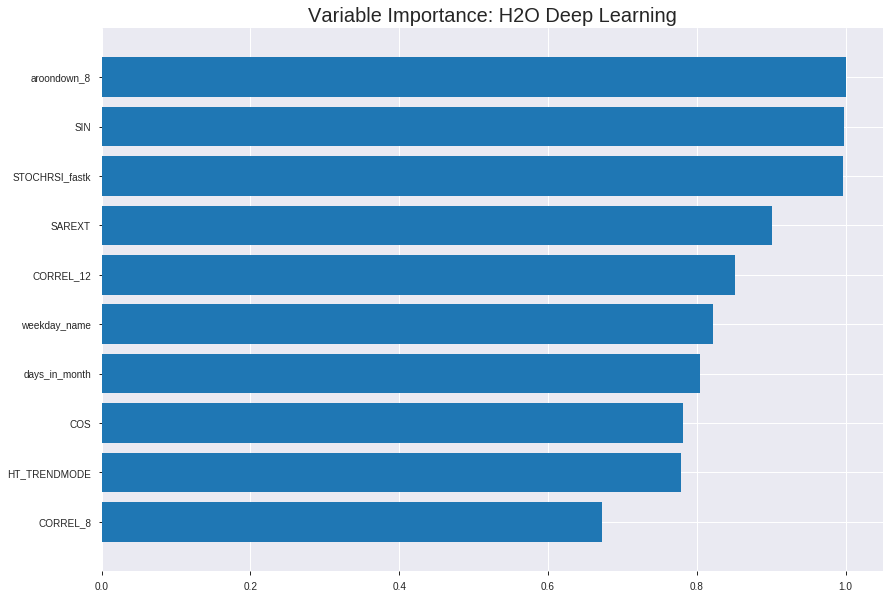

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_161959_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2272389315556205
RMSE: 0.476695848057879
LogLoss: 0.6419684067455154
Mean Per-Class Error: 0.3929399610735772
AUC: 0.6588414308456726
pr_auc: 0.6831067981153525
Gini: 0.3176828616913452
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4034678082916382: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      154  697   0.819    (697.0/851.0)
1      38   864   0.0421   (38.0/902.0)
Total  192  1561  0.4193   (735.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.403468     0.701583  284
max f2                       0.179784     0.848164  351
max f0point5                 0.491851     0.624366  204
max accuracy                 0.491851     0.613234  204
max precision                0.923506     1         0
max recall                   0.0315799    1         385
max specificity              0.923506     1         0
max absolute_mcc             0.474594     0.241332  224
max min_per_class_accuracy   0.498551     0.545455  191
max mean_per_class_accuracy  0.491851     0.60706   204

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 48.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.843093           1.94346   1.94346            1                0.876768  1                           0.876768            0.0199557       0.0199557                  94.3459    94.3459
    2        0.0205362                   0.805989           1.83549   1.88947            0.944444         0.821754  0.972222                    0.849261            0.018847        0.0388027                  83.5489    88.9474
    3        0.0302339                   0.771172           1.71482   1.83345            0.882353         0.787119  0.943396                    0.829328            0.0166297       0.0554324                  71.4817    83.3452
    4        0.040502                    0.727222           1.94346   1.86134            1                0.749013  0.957746                    0.808967            0.0199557       0.075388                   94.3459    86.1341
    5        0.0501997                   0.660188           1.94346   1.8772             1                0.690904  0.965909                    0.786159            0.018847        0.094235                   94.3459    87.7205
    6        0.100399                    0.551202           1.32509   1.60115            0.681818         0.588048  0.823864                    0.687104            0.0665188       0.160754                   32.5086    60.1145
    7        0.150029                    0.536746           1.31798   1.50747            0.678161         0.542623  0.775665                    0.63931             0.0654102       0.226164                   31.7978    50.7474
    8        0.200228                    0.526487           1.06007   1.3953             0.545455         0.531508  0.717949                    0.612283            0.0532151       0.279379                   6.00685    39.5304
    9        0.300057                    0.512622           1.11055   1.30057            0.571429         0.519355  0.669202                    0.581366            0.110865        0.390244                   11.0548    30.0566
    10       0.399886                    0.502432           0.977282  1.21986            0.502857         0.507136  0.627675                    0.562835            0.097561        0.487805                   -2.27178   21.986
    11       0.614946                    0.498335           1.05679   1.16283            0.543767         0.498926  0.59833                     0.540484            0.227273        0.715078                   5.6788     16.283
    12       0.699943                    0.494674           0.991295  1.142              0.510067         0.497222  0.587612                    0.535231            0.0842572       0.799335                   -0.870549  14.2
    13       0.799772                    0.466484           0.888438  1.11035            0.457143         0.482109  0.571327                    0.5286              0.0886918       0.888027                   -11.1562   11.035
    14       0.899601                    0.389968           0.744067  1.0697             0.382857         0.437566  0.550412                    0.518498            0.0742794       0.962306                   -25.5933   6.97035
    15       1                           0.000386863        0.375441  1                  0.193182         0.203653  0.514546                    0.486888            0.037694        1                          -62.4559   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.29830105746607516
RMSE: 0.5461694402528168
LogLoss: 1.653564066801586
Mean Per-Class Error: 0.4530986005291848
AUC: 0.5390512926774841
pr_auc: 0.5165523554585556
Gini: 0.07810258535496817
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.894480301964322e-07: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    254  0        (0.0/254.0)
Total  0    501  0.493    (247.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.89448e-07  0.672848  399
max f2                       1.89448e-07  0.837179  399
max f0point5                 0.393594     0.569462  271
max accuracy                 0.411759     0.548902  263
max precision                0.497459     0.560847  132
max recall                   1.89448e-07  1         399
max specificity              0.840541     0.995951  0
max absolute_mcc             0.393594     0.098989  271
max min_per_class_accuracy   0.48315      0.546559  188
max mean_per_class_accuracy  0.48315      0.546901  188

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 37.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.749353           0.65748   0.65748            0.333333         0.792367     0.333333                    0.792367            0.00787402      0.00787402                 -34.252   -34.252
    2        0.0219561                   0.624366           0.394488  0.537938           0.2              0.67984      0.272727                    0.741218            0.00393701      0.011811                   -60.5512  -46.2062
    3        0.0319361                   0.564757           0.394488  0.49311            0.2              0.5939       0.25                        0.695181            0.00393701      0.015748                   -60.5512  -50.689
    4        0.0419162                   0.55047            1.18346   0.65748            0.6              0.5552       0.333333                    0.661852            0.011811        0.0275591                  18.3465   -34.252
    5        0.0518962                   0.542728           0.788976  0.682768           0.4              0.546381     0.346154                    0.639646            0.00787402      0.0354331                  -21.1024  -31.7232
    6        0.101796                    0.526479           1.26236   0.966883           0.64             0.534228     0.490196                    0.587971            0.0629921       0.0984252                  26.2362   -3.31172
    7        0.151697                    0.515214           1.02567   0.98622            0.52             0.519548     0.5                         0.565463            0.0511811       0.149606                   2.56693   -1.37795
    8        0.201597                    0.504519           1.10457   1.01551            0.56             0.508999     0.514851                    0.551487            0.0551181       0.204724                   10.4567   1.55141
    9        0.323353                    0.498335           1.22873   1.0958             0.622951         0.499453     0.555556                    0.531894            0.149606        0.354331                   22.8734   9.58005
    10       0.401198                    0.496334           1.01151   1.07945            0.512821         0.497631     0.547264                    0.525246            0.0787402       0.433071                   1.15082   7.94453
    11       0.500998                    0.48315            1.14402   1.09231            0.58             0.490076     0.553785                    0.51824             0.114173        0.547244                   14.4016   9.23079
    12       0.600798                    0.449187           0.867874  1.05503            0.44             0.468302     0.534884                    0.509945            0.0866142       0.633858                   -13.2126  5.50266
    13       0.700599                    0.339853           0.98622   1.04523            0.5              0.408919     0.529915                    0.495554            0.0984252       0.732283                   -1.37795  4.52251
    14       0.800399                    0.121905           0.788976  1.01327            0.4              0.240495     0.513716                    0.463751            0.0787402       0.811024                   -21.1024  1.32739
    15       0.9002                      0.00142188         1.02567   1.01465            0.52             0.0306686    0.514412                    0.415737            0.102362        0.913386                   2.56693   1.46481
    16       1                           9.65713e-36        0.867874  1                  0.44             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:26:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:26:21  1 min 18.914 sec  607 obs/sec       0.589846  1             1034       0.534624         0.78052             -0.144261      0.512702        0.52906            1.29564          0.482601                         0.617742           4.37577               -0.526721        0.448381          0.386849             0.961565           0.493014
    2019-08-27 16:26:33  1 min 30.352 sec  1016 obs/sec      6.98517   12            12245      0.509193         0.712244            -0.0379887     0.583657        0.590645           1.40361          0.480319                         0.548075           2.3877                -0.201778        0.548073          0.537005             0.98622            0.493014
    2019-08-27 16:26:45  1 min 42.141 sec  1124 obs/sec      14.5722   25            25545      0.496254         0.685482            0.0140954      0.59928         0.613718           1.72752          0.460354                         0.569049           4.37777               -0.295519        0.546264          0.534733             0.98622            0.493014
    2019-08-27 16:26:56  1 min 53.866 sec  1192 obs/sec      22.676    39            39751      0.486995         0.665857            0.0505418      0.622708        0.642899           1.61955          0.440388                         0.580897           5.35518               -0.350029        0.55099           0.530689             0.98622            0.493014
    2019-08-27 16:27:08  2 min  5.429 sec  1257 obs/sec      31.4016   54            55047      0.48391          0.657613            0.0625318      0.624105        0.664108           1.83549          0.444952                         0.576184           4.78391               -0.32821         0.549061          0.52375              0.98622            0.493014
    2019-08-27 16:27:20  2 min 17.353 sec  1274 obs/sec      39.5123   68            69265      0.476696         0.641968            0.0902743      0.658841        0.683107           1.94346          0.419281                         0.546169           1.65356               -0.193437        0.539051          0.516552             0.65748            0.493014

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
aroondown_8          1.0                    1.0                  0.03828624153164573
SIN                  0.9981501698493958     0.9981501698493958   0.03821541848770718
STOCHRSI_fastk       0.995944619178772      0.995944619178772    0.03813097624202139
SAREXT               0.9015619158744812     0.9015619158744812   0.03451741726690366
CORREL_12            0.8520002365112305     0.8520002365112305   0.03261988684008826
---                  ---                    ---                  ---
CDLDARKCLOUDCOVER    0.36445319652557373    0.36445319652557373  0.013953543109158466
CDLTHRUSTING         0.3641035258769989     0.3641035258769989   0.013940155534250603
CDLPIERCING          0.3607160151004791     0.3607160151004791   0.013810460478469714
is_quarter_end       0.35052645206451416    0.35052645206451416  0.01342034040697283
CDLGAPSIDESIDEWHITE  0.34636422991752625    0.34636422991752625  0.013260984564544885


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6413043478260869)

('auc', 0.5044284439913342)

('logloss', 1.3719542331201995)

('mean_per_class_error', 0.46447687014145533)

('rmse', 0.5299742873974769)

('mse', 0.2808727453024634)

deeplearning prediction progress: |███████████████████████████████████████| 100%


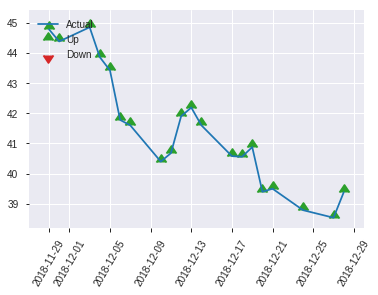


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2808727453024634
RMSE: 0.5299742873974769
LogLoss: 1.3719542331201995
Mean Per-Class Error: 0.46447687014145533
AUC: 0.5044284439913342
pr_auc: 0.4881102756905105
Gini: 0.008856887982668482
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.144634237284968e-19: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    132  0.9925   (132.0/133.0)
1      0    118  0        (0.0/118.0)
Total  1    250  0.5259   (132.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.14463e-19  0.641304  230
max f2                       1.14463e-19  0.817175  230
max f0point5                 1.14463e-19  0.527728  230
max accuracy                 0.544513     0.553785  21
max precision                0.634562     0.666667  2
max recall                   1.14463e-19  1         230
max specificity              0.695465     0.992481  0
max absolute_mcc             0.0124227    0.109454  213
max min_per_class_accuracy   0.497041     0.491525  105
max mean_per_class_accuracy  0.51502      0.535523  64

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 42.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.629939           1.41808   1.41808            0.666667         0.657644   0.666667                    0.657644            0.0169492       0.0169492                  41.8079   41.8079
    2        0.0239044                   0.585908           0.70904   1.06356            0.333333         0.599859   0.5                         0.628752            0.00847458      0.0254237                  -29.096   6.35593
    3        0.0318725                   0.560253           2.12712   1.32945            1                0.563813   0.625                       0.612517            0.0169492       0.0423729                  112.712   32.9449
    4        0.0438247                   0.555349           0.70904   1.16025            0.333333         0.558254   0.545455                    0.597718            0.00847458      0.0508475                  -29.096   16.0247
    5        0.0517928                   0.551277           2.12712   1.309              1                0.55249    0.615385                    0.59076             0.0169492       0.0677966                  112.712   30.8996
    6        0.103586                    0.542191           0.981747  1.14537            0.461538         0.546254   0.538462                    0.568507            0.0508475       0.118644                   -1.82529  14.5372
    7        0.151394                    0.533393           0.886299  1.06356            0.416667         0.537217   0.5                         0.558626            0.0423729       0.161017                   -11.3701  6.35593
    8        0.203187                    0.525102           1.47262   1.16783            0.692308         0.529106   0.54902                     0.551101            0.0762712       0.237288                   47.2621   16.783
    9        0.302789                    0.510146           0.680678  1.00758            0.32             0.516045   0.473684                    0.53957             0.0677966       0.305085                   -31.9322  0.758252
    10       0.462151                    0.498335           0.904025  0.971873           0.425            0.502088   0.456897                    0.526645            0.144068        0.449153                   -9.59746  -2.81268
    11       0.501992                    0.49676            1.06356   0.97915            0.5              0.497659   0.460317                    0.524344            0.0423729       0.491525                   6.35593   -2.08501
    12       0.601594                    0.483338           1.36136   1.04243            0.64             0.489745   0.490066                    0.518616            0.135593        0.627119                   36.1356   4.2429
    13       0.701195                    0.451294           0.765763  1.00313            0.36             0.469188   0.471591                    0.511595            0.0762712       0.70339                    -23.4237  0.312982
    14       0.800797                    0.394713           0.765763  0.973607           0.36             0.427236   0.457711                    0.501103            0.0762712       0.779661                   -23.4237  -2.63935
    15       0.900398                    0.0877634          1.02102   0.978851           0.48             0.244697   0.460177                    0.472739            0.101695        0.881356                   2.10169   -2.11489
    16       1                           3.43775e-21        1.19119   1                  0.56             0.0167308  0.47012                

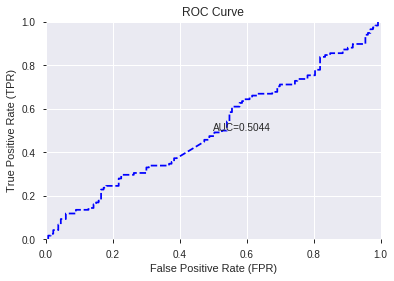

This function is available for GLM models only


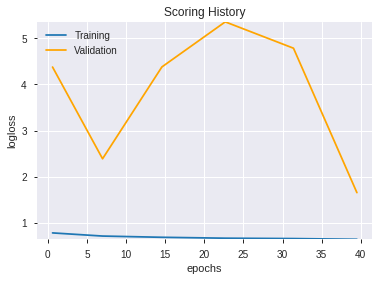

--2019-08-27 16:28:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_161959_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_161959_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['aroondown_8',
 'SIN',
 'STOCHRSI_fastk',
 'SAREXT',
 'CORREL_12',
 'weekday_name',
 'days_in_month',
 'COS',
 'HT_TRENDMODE',
 'CORREL_8',
 'SUB',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'is_month_start',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGDOJISTAR',
 'SINH',
 'EXP',
 'COSH',
 'CDLEVENINGSTAR',
 'is_month_end',
 'CDLEVENINGDOJISTAR',
 'CDLSHOOTINGSTAR',
 'CDLINNECK',
 'CDLHANGINGMAN',
 'CDLBREAKAWAY',
 'CDLADVANCEBLOCK',
 'CDL2CROWS',
 'CDLSTICKSANDWICH',
 'CDLLADDERBOTTOM',
 'CDLMATCHINGLOW',
 'CDLONNECK',
 'CDLHAMMER',
 'CDLUPSIDEGAP2CROWS',
 'CDLMORNINGSTAR',
 'CDLCOUNTERATTACK',
 'is_quarter_start',
 'CDLINVERTEDHAMMER',
 'CDLHOMINGPIGEON',
 'CDLSEPARATINGLINES',
 'CDLABANDONEDBABY',
 'CDLUNIQUE3RIVER',
 'CDLGRAVESTONEDOJI',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLDARKCLOUDCOVER',
 'CDLTHRUSTING',
 'CDLPIERCING',
 'is_quarter_end',
 'CDLGAPSIDESIDEWHITE']

In [20]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190827_162942_model_1  0.459889  2.663354                   0.5  0.56349  0.317521

variable  relative_importance  scaled_importance  percentage
0             CORREL_12             0.009057           1.000000    0.047956
1    CDLMORNINGDOJISTAR             0.008065           0.890473    0.042703
2     CDLSTALLEDPATTERN             0.007969           0.879874    0.042195
3           aroondown_8             0.007558           0.834505    0.040019
4         days_in_month             0.007474           0.825221    0.039574
5          CDLBREAKAWAY             0.007086           0.782348    0.037518
6          weekday_name             0.006662           0.735621    0.035277
7                SAREXT             0.006576           0.726122    0.034822
8       CDLLADDERBOTTOM             0.006328           0.698743    0.033509
9        STOCHRSI_fastk             0.005963           0.658392    0.031574
10            CDLTAKURI             0.005694           0.628680    0.030149
11     CDLDRAGONFLYDOJI             0.005683           0.627460    0.030090
12      CDLADVANCEBLOCK             0.005468           0.603728    0.028952
13            CDLONNECK             0.005416           0.598005    0.028678
14                  EXP             0.005394           0.595592    0.028562
15                 SINH             0.005385           0.594574    0.028513
16                 COSH             0.005382           0.594263    0.028498
17       CDLMATCHINGLOW             0.005338           0.589351    0.028263
18      CDLSHOOTINGSTAR             0.005263           0.581133    0.027869
19    CDLGRAVESTONEDOJI             0.005136           0.567066    0.027194
20                  SUB             0.005106           0.563755    0.027035
21         is_month_end             0.004406           0.486500    0.023331
22   CDLUPSIDEGAP2CROWS             0.004254           0.469734    0.022527
23       is_quarter_end             0.003913           0.432011    0.020718
24     CDLABANDONEDBABY             0.003811           0.420821    0.020181
25       CDLMORNINGSTAR             0.003688           0.407167    0.019526
26     is_quarter_start             0.003663           0.404436    0.019395
27       CDLEVENINGSTAR             0.003226           0.356209    0.017082
28      CDLHOMINGPIGEON             0.002865           0.316359    0.015171
29         HT_TRENDMODE             0.002787           0.307735    0.014758
30     CDLCOUNTERATTACK             0.002471           0.272851    0.013085
31            CDL2CROWS             0.002241           0.247425    0.011865
32       is_month_start             0.002226           0.245743    0.011785
33   CDLEVENINGDOJISTAR             0.001986           0.219250    0.010514
34              CDLDOJI             0.001822           0.201159    0.009647
35   CDLSEPARATINGLINES             0.001749           0.193082    0.009259
36             CORREL_8             0.001701           0.187851    0.009009
37      CDLUNIQUE3RIVER             0.001572           0.173577    0.008324
38                  SIN             0.001372           0.151519    0.007266
39         CDLTHRUSTING             0.001281           0.141409    0.006781
40          CDLPIERCING             0.001166           0.128796    0.006177
41            CDLHAMMER             0.001073           0.118528    0.005684
42        CDLHANGINGMAN             0.001028           0.113509    0.005443
43    CDLINVERTEDHAMMER             0.000784           0.086556    0.004151
44       CDLRICKSHAWMAN             0.000675           0.074482    0.003572
45    CDLDARKCLOUDCOVER             0.000663           0.073204    0.003511
46     CDLSTICKSANDWICH             0.000214           0.023609    0.001132
47                  COS             0.000084           0.009229    0.000443
48            CDLINNECK             0.000075           0.008286    0.000397
49  CDLGAPSIDESIDEWHITE             0.000059           0.006512    0.000312

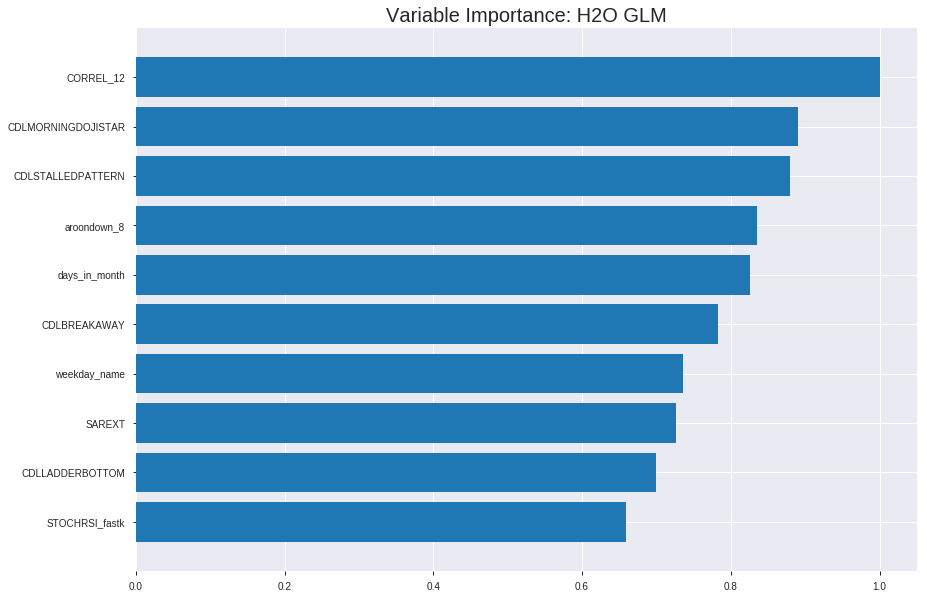

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_162942_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24833435904143594
RMSE: 0.4983315754007927
LogLoss: 0.6898097924392768
Null degrees of freedom: 1752
Residual degrees of freedom: 1702
Null deviance: 2428.6900635089887
Residual deviance: 2418.4731322921043
AIC: 2520.4731322921043
AUC: 0.584003819687807
pr_auc: 0.5970888939703055
Gini: 0.16800763937561403
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49578473080925944: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      34   817   0.96     (817.0/851.0)
1      11   891   0.0122   (11.0/902.0)
Total  45   1708  0.4723   (828.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.495785     0.682759  362
max f2                       0.459302     0.842046  394
max f0point5                 0.512335     0.582863  234
max accuracy                 0.512335     0.563035  234
max precision                0.571278     1         0
max recall                   0.459302     1         394
max specificity              0.571278     1         0
max absolute_mcc             0.519888     0.1346    134
max min_per_class_accuracy   0.514342     0.558758  205
max mean_per_class_accuracy  0.514463     0.561012  203

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.541034           1.40361   1.40361            0.722222         0.549304  0.722222                    0.549304            0.0144124       0.0144124                  40.3609   40.3609
    2        0.0205362                   0.534478           1.40361   1.40361            0.722222         0.536618  0.722222                    0.542961            0.0144124       0.0288248                  40.3609   40.3609
    3        0.0302339                   0.531538           1.48617   1.43009            0.764706         0.532823  0.735849                    0.539709            0.0144124       0.0432373                  48.6175   43.0092
    4        0.040502                    0.529596           1.29564   1.39601            0.666667         0.53049   0.71831                     0.537372            0.0133038       0.056541                   29.5639   39.6006
    5        0.0501997                   0.527961           1.37185   1.39134            0.705882         0.528805  0.715909                    0.535717            0.0133038       0.0698448                  37.1853   39.134
    6        0.100399                    0.524502           1.25883   1.32509            0.647727         0.52584   0.681818                    0.530779            0.0631929       0.133038                   25.8831   32.5086
    7        0.150029                    0.522556           1.04991   1.23406            0.54023          0.523502  0.634981                    0.528372            0.0521064       0.185144                   4.99146   23.406
    8        0.200228                    0.520914           1.17049   1.21812            0.602273         0.521657  0.626781                    0.526688            0.0587583       0.243902                   17.0492   21.8122
    9        0.300057                    0.51849            1.06613   1.16755            0.548571         0.519651  0.60076                     0.524347            0.10643         0.350333                   6.61261   16.7553
    10       0.399886                    0.516371           1.06613   1.14223            0.548571         0.517362  0.587732                    0.522603            0.10643         0.456763                   6.61261   14.2233
    11       0.500285                    0.514326           1.0159    1.11688            0.522727         0.515254  0.574686                    0.521128            0.101996        0.558758                   1.5899    11.688
    12       0.600114                    0.512745           0.966177  1.09181            0.497143         0.513502  0.561787                    0.51986             0.0964523       0.655211                   -3.38232  9.18101
    13       0.699943                    0.510864           0.888438  1.0628             0.457143         0.511879  0.546862                    0.518721            0.0886918       0.743902                   -11.1562  6.28044
    14       0.799772                    0.50905            0.888438  1.04104            0.457143         0.510001  0.535663                    0.517633            0.0886918       0.832594                   -11.1562  4.10397
    15       0.899601                    0.506061           0.977282  1.03396            0.502857         0.507813  0.532023                    0.516543            0.097561        0.930155                   -2.27178  3.39645
    16       1                           0.42641            0.69567   1                  0.357955         0.496655  0.514546                    0.514546            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.31661639459929464
RMSE: 0.5626867641941604
LogLoss: 3.9100028679586276
Null degrees of freedom: 500
Residual degrees of freedom: 450
Null deviance: 694.5502849840166
Residual deviance: 15373.11965766335
AIC: 15475.11965766335
AUC: 0.5488220854984219
pr_auc: 0.5392070000896039
Gini: 0.09764417099684386
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.724234237751038e-09: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    254  0        (0.0/254.0)
Total  0    501  0.493    (247.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.72423e-09  0.672848  399
max f2                       2.72423e-09  0.837179  399
max f0point5                 0.460209     0.576923  278
max accuracy                 0.468187     0.566866  272
max precision                0.539716     1         0
max recall                   2.72423e-09  1         399
max specificity              0.539716     1         0
max absolute_mcc             0.460209     0.133034  278
max min_per_class_accuracy   0.498922     0.550607  248
max mean_per_class_accuracy  0.468187     0.566196  272

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 32.83 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.535907           0.98622   0.98622            0.5              0.537441     0.5                         0.537441            0.011811        0.011811                   -1.37795  -1.37795
    2        0.0219561                   0.530672           0.788976  0.896564           0.4              0.533935     0.454545                    0.535847            0.00787402      0.019685                   -21.1024  -10.3436
    3        0.0319361                   0.528752           0.788976  0.862943           0.4              0.529113     0.4375                      0.533743            0.00787402      0.0275591                  -21.1024  -13.7057
    4        0.0419162                   0.527607           1.57795   1.03318            0.8              0.528048     0.52381                     0.532387            0.015748        0.0433071                  57.7953   3.31834
    5        0.0518962                   0.526269           1.57795   1.13795            0.8              0.526526     0.576923                    0.53126             0.015748        0.0590551                  57.7953   13.7947
    6        0.101796                    0.522031           0.946772  1.04423            0.48             0.523848     0.529412                    0.527627            0.0472441       0.106299                   -5.32283  4.42334
    7        0.151697                    0.518785           0.946772  1.01217            0.48             0.520203     0.513158                    0.525185            0.0472441       0.153543                   -5.32283  1.21736
    8        0.201597                    0.516909           1.26236   1.0741             0.64             0.51775      0.544554                    0.523344            0.0629921       0.216535                   26.2362   7.41015
    9        0.301397                    0.513643           1.26236   1.13644            0.64             0.515348     0.576159                    0.520696            0.125984        0.34252                    26.2362   13.6439
    10       0.401198                    0.510266           0.907323  1.07945            0.46             0.511865     0.547264                    0.518499            0.0905512       0.433071                   -9.26772  7.94453
    11       0.500998                    0.498922           1.18346   1.10017            0.6              0.506832     0.557769                    0.516175            0.11811         0.551181                   18.3465   10.0166
    12       0.600798                    0.406079           0.867874  1.06158            0.44             0.463513     0.538206                    0.507427            0.0866142       0.637795                   -13.2126  6.15795
    13       0.700599                    0.0727655          0.98622   1.05084            0.5              0.220553     0.532764                    0.466562            0.0984252       0.73622                    -1.37795  5.08446
    14       0.800399                    7.61152e-07        0.749528  1.01327            0.38             0.0144224    0.513716                    0.410186            0.0748031       0.811024                   -25.0472  1.32739
    15       0.9002                      1.00113e-34        0.98622   1.01027            0.5              2.34209e-08  0.512195                    0.36471             0.0984252       0.909449                   -1.37795  1.02746
    16       1                           0                  0.907323  1                  0.46             1


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 16:29:42  0.000 sec   2            2.7       51            1.37962           30.6849
    2019-08-27 16:29:42  0.012 sec   4            1.7       51            1.37702           40.1807
    2019-08-27 16:29:42  0.022 sec   6            1         51            1.37375           48.2577
    2019-08-27 16:29:42  0.033 sec   8            0.64      51            1.36999           55.9585
    2019-08-27 16:29:42  0.046 sec   10           0.4       51            1.36606           62.854

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6395663956639567)

('auc', 0.45988912960367023)

('logloss', 2.6633537535663674)

('mean_per_class_error', 0.4829234102204665)

('rmse', 0.5634896594510402)

('mse', 0.3175205963082493)

glm prediction progress: |████████████████████████████████████████████████| 100%


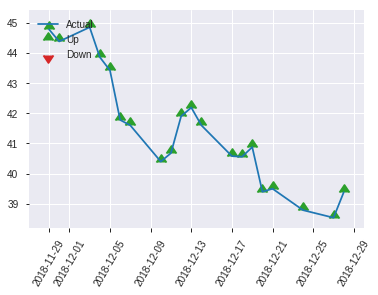


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.3175205963082493
RMSE: 0.5634896594510402
LogLoss: 2.6633537535663674
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 349.04545729516275
Residual deviance: 4970.139219496552
AIC: 5072.139219496552
AUC: 0.45988912960367023
pr_auc: 0.45460557774582494
Gini: -0.08022174079265953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.5134666200653143e-61: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    118  0        (0.0/118.0)
Total  0    251  0.5299   (133.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.51347e-61  0.639566  239
max f2                       2.51347e-61  0.816044  239
max f0point5                 2.51347e-61  0.525847  239
max accuracy                 0.525145     0.541833  12
max precision                0.542372     1         0
max recall                   2.51347e-61  1         239
max specificity              0.542372     1         0
max absolute_mcc             0.511222     0.158971  118
max min_per_class_accuracy   0.510115     0.432203  124
max mean_per_class_accuracy  0.521041     0.517077  37

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 37.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.533664           0.70904   0.70904            0.333333         0.537699     0.333333                    0.537699            0.00847458      0.00847458                 -29.096   -29.096
    2        0.0239044                   0.532687           0.70904   0.70904            0.333333         0.533158     0.333333                    0.535429            0.00847458      0.0169492                  -29.096   -29.096
    3        0.0318725                   0.528951           2.12712   1.06356            1                0.530848     0.5                         0.534283            0.0169492       0.0338983                  112.712   6.35593
    4        0.0438247                   0.526725           1.41808   1.16025            0.666667         0.527531     0.545455                    0.532442            0.0169492       0.0508475                  41.8079   16.0247
    5        0.0517928                   0.525129           2.12712   1.309              1                0.525578     0.615385                    0.531386            0.0169492       0.0677966                  112.712   30.8996
    6        0.103586                    0.522639           0.818123  1.06356            0.384615         0.523445     0.5                         0.527416            0.0423729       0.110169                   -18.1877  6.35593
    7        0.151394                    0.520913           1.24082   1.11954            0.583333         0.521779     0.526316                    0.525636            0.059322        0.169492                   24.0819   11.9536
    8        0.203187                    0.519594           0.818123  1.04271            0.384615         0.520163     0.490196                    0.524241            0.0423729       0.211864                   -18.1877  4.27052
    9        0.302789                    0.517273           1.02102   1.03557            0.48             0.518441     0.486842                    0.522333            0.101695        0.313559                   2.10169   3.55709
    10       0.40239                     0.513805           0.510508  0.905605           0.24             0.515592     0.425743                    0.520664            0.0508475       0.364407                   -48.9492  -9.4395
    11       0.501992                    0.509934           0.680678  0.860977           0.32             0.511796     0.404762                    0.518905            0.0677966       0.432203                   -31.9322  -13.9023
    12       0.601594                    0.498965           1.19119   0.915647           0.56             0.505779     0.430464                    0.516732            0.118644        0.550847                   19.1186   -8.43529
    13       0.701195                    0.354585           1.19119   0.954786           0.56             0.433911     0.448864                    0.504967            0.118644        0.669492                   19.1186   -4.52138
    14       0.800797                    0.0806475          1.02102   0.963024           0.48             0.191526     0.452736                    0.465982            0.101695        0.771186                   2.10169   -3.69761
    15       0.900398                    2.66402e-08        1.19119   0.988263           0.56             0.0140698    0.464602                    0.415992            0.118644        0.889831                   19.1186   -1.17369
    16       1                           3.81652e-242       1.1061    1                  0.52            

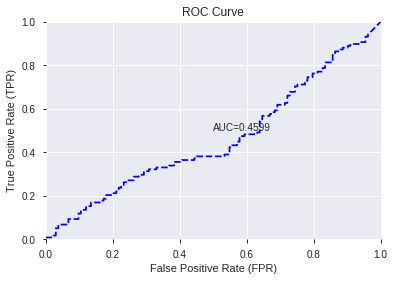

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


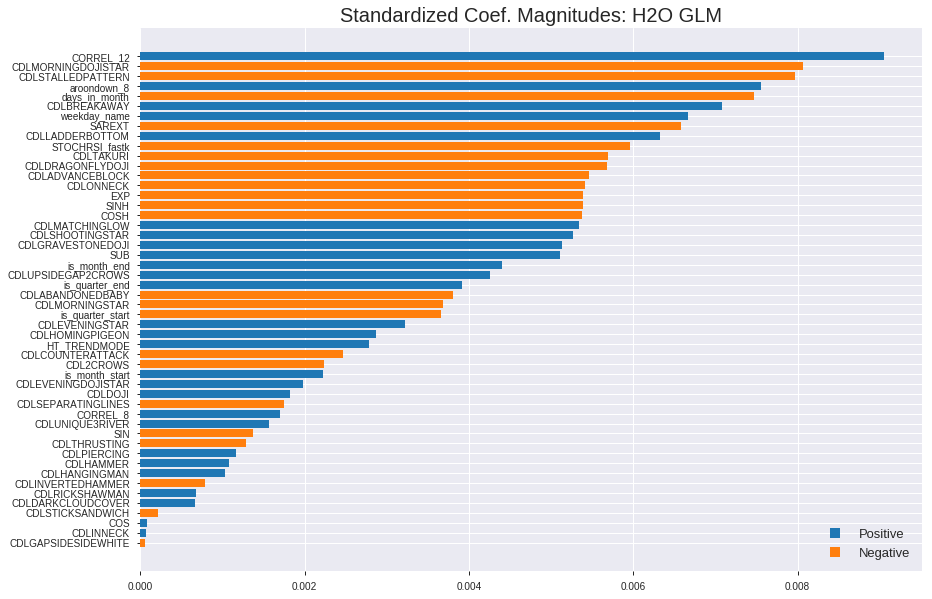

'log_likelihood'
--2019-08-27 16:29:53--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.200.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.200.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_162942_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_162942_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CORREL_12',
 'CDLMORNINGDOJISTAR',
 'CDLSTALLEDPATTERN',
 'aroondown_8',
 'days_in_month',
 'CDLBREAKAWAY',
 'weekday_name',
 'SAREXT',
 'CDLLADDERBOTTOM',
 'STOCHRSI_fastk',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'CDLADVANCEBLOCK',
 'CDLONNECK',
 'EXP',
 'SINH',
 'COSH',
 'CDLMATCHINGLOW',
 'CDLSHOOTINGSTAR',
 'CDLGRAVESTONEDOJI',
 'SUB',
 'is_month_end',
 'CDLUPSIDEGAP2CROWS',
 'is_quarter_end',
 'CDLABANDONEDBABY',
 'CDLMORNINGSTAR',
 'is_quarter_start',
 'CDLEVENINGSTAR',
 'CDLHOMINGPIGEON',
 'HT_TRENDMODE',
 'CDLCOUNTERATTACK',
 'CDL2CROWS',
 'is_month_start',
 'CDLEVENINGDOJISTAR',
 'CDLDOJI',
 'CDLSEPARATINGLINES',
 'CORREL_8',
 'CDLUNIQUE3RIVER',
 'SIN',
 'CDLTHRUSTING',
 'CDLPIERCING',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLINVERTEDHAMMER',
 'CDLRICKSHAWMAN',
 'CDLDARKCLOUDCOVER',
 'CDLSTICKSANDWICH',
 'COS',
 'CDLINNECK',
 'CDLGAPSIDESIDEWHITE']

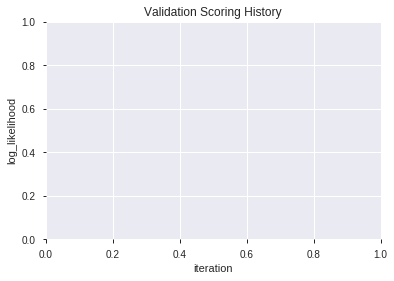

In [21]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190827_163050  0.475723  0.724457              0.500000  0.514574  0.264786
1  XGBoost_grid_1_AutoML_20190827_163050_model_1  0.452211  0.725364              0.496241  0.515282  0.265515
2               XGBoost_3_AutoML_20190827_163050  0.451510  0.720756              0.500000  0.513321  0.263498
3  XGBoost_grid_1_AutoML_20190827_163050_model_4  0.450236  0.716462              0.500000  0.511282  0.261409
4  XGBoost_grid_1_AutoML_20190827_163050_model_5  0.448260  0.756126              0.488722  0.528317  0.279119
5               XGBoost_2_AutoML_20190827_163050  0.444501  0.730011              0.492481  0.517512  0.267818
6  XGBoost_grid_1_AutoML_20190827_163050_model_6  0.440678  0.723166              0.492481  0.514453  0.264662
7  XGBoost_grid_1_AutoML_20190827_163050_model_2  0.430993  0.721666              0.500000  0.513835  0.264026
8  XGBoost_grid_1_AutoML_20190827_163050_model_7  0.428189  0.745653              0.492481  0.524356  0.274949
9  XGBoost_grid_1_AutoML_20190827_163050_model_3  0.427297  0.734014              0.500000  0.519282  0.269654

variable  relative_importance  scaled_importance  percentage
0        CORREL_12           701.258606           1.000000    0.124382
1         CORREL_8           700.887512           0.999471    0.124316
2             COSH           579.121094           0.825831    0.102718
3              COS           575.789612           0.821080    0.102127
4              SUB           575.485840           0.820647    0.102074
5              SIN           565.244812           0.806043    0.100257
6   STOCHRSI_fastk           497.661743           0.709669    0.088270
7           SAREXT           455.080780           0.648949    0.080717
8      aroondown_8           290.971344           0.414927    0.051609
9     weekday_name           228.579712           0.325956    0.040543
10             EXP           181.052856           0.258183    0.032113
11   days_in_month           122.978111           0.175368    0.021813
12            SINH            67.623604           0.096432    0.011994
13         CDLDOJI            45.609360           0.065039    0.008090
14    HT_TRENDMODE            40.449631           0.057681    0.007175
15  CDLRICKSHAWMAN             5.123523           0.007306    0.000909
16    is_month_end             5.037127           0.007183    0.000893

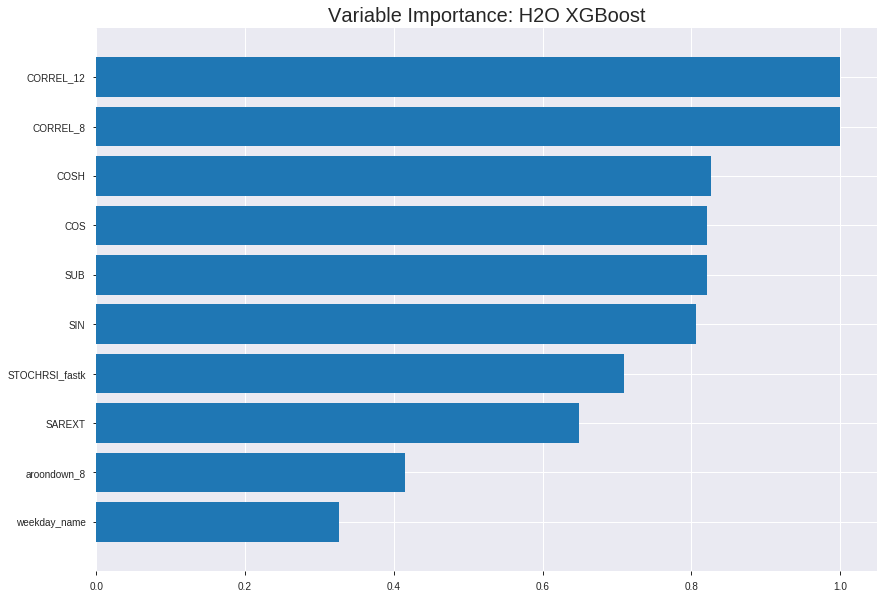

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190827_163050


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.17944703045474822
RMSE: 0.42361188658340104
LogLoss: 0.5471684450340673
Mean Per-Class Error: 0.16175700428086426
AUC: 0.9149376890628216
pr_auc: 0.9187227629811263
Gini: 0.8298753781256432
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5029014050960541: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      680  171  0.2009   (171.0/851.0)
1      113  789  0.1253   (113.0/902.0)
Total  793  960  0.162    (284.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.502901     0.847476  210
max f2                       0.440308     0.89503   263
max f0point5                 0.562045     0.858459  154
max accuracy                 0.511313     0.838562  201
max precision                0.82209      1         0
max recall                   0.306742     1         368
max specificity              0.82209      1         0
max absolute_mcc             0.505336     0.677265  207
max min_per_class_accuracy   0.515759     0.834313  197
max mean_per_class_accuracy  0.511313     0.838243  201

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.42 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.750307           1.94346    1.94346            1                0.768354  1                           0.768354            0.0199557       0.0199557                  94.3459   94.3459
    2        0.0205362                   0.731847           1.94346    1.94346            1                0.739717  1                           0.754036            0.0199557       0.0399113                  94.3459   94.3459
    3        0.0302339                   0.721935           1.94346    1.94346            1                0.726641  1                           0.745249            0.018847        0.0587583                  94.3459   94.3459
    4        0.040502                    0.715621           1.94346    1.94346            1                0.718859  1                           0.738558            0.0199557       0.078714                   94.3459   94.3459
    5        0.0501997                   0.705289           1.94346    1.94346            1                0.710756  1                           0.733188            0.018847        0.097561                   94.3459   94.3459
    6        0.100399                    0.671931           1.85512    1.89929            0.954545         0.687361  0.977273                    0.710274            0.0931264       0.190687                   85.512    89.9289
    7        0.150029                    0.648072           1.89878    1.89912            0.977011         0.659692  0.977186                    0.693542            0.094235        0.284922                   89.8782   89.9122
    8        0.200228                    0.623721           1.89929    1.89916            0.977273         0.636787  0.977208                    0.679313            0.0953437       0.380266                   89.9289   89.9164
    9        0.300057                    0.589591           1.73245    1.8437             0.891429         0.606202  0.948669                    0.654989            0.172949        0.553215                   73.2455   84.37
    10       0.399886                    0.555842           1.51035    1.76048            0.777143         0.572522  0.905849                    0.634401            0.150776        0.703991                   51.0345   76.048
    11       0.500285                    0.520191           1.2257     1.65316            0.630682         0.538666  0.850627                    0.615189            0.12306         0.827051                   22.5704   65.3159
    12       0.600114                    0.47973            0.888438   1.52595            0.457143         0.500252  0.785171                    0.596069            0.0886918       0.915743                   -11.1562  52.5948
    13       0.699943                    0.442158           0.410903   1.36692            0.211429         0.461889  0.703341                    0.576932            0.04102         0.956763                   -58.9097  36.6915
    14       0.799772                    0.402608           0.266532   1.22956            0.137143         0.422448  0.632668                    0.557649            0.0266075       0.98337                    -73.3468  22.9564
    15       0.899601                    0.346692           0.133266   1.10791            0.0685714        0.375388  0.57007                     0.537423            0.0133038       0.996674                   -86.6734  10.7907
    16       1                           0.198011           0.0331271  1                  0.0170455        0.30639   0.514546                    0.



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2621749811303527
RMSE: 0.5120302541162511
LogLoss: 0.7198002224519063
Mean Per-Class Error: 0.47077528770442156
AUC: 0.5110379674200645
pr_auc: 0.5060347013737527
Gini: 0.02207593484012893
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23247216641902924: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    254  0        (0.0/254.0)
Total  0    501  0.493    (247.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.232472     0.672848   399
max f2                       0.232472     0.837179   399
max f0point5                 0.232472     0.562445   399
max accuracy                 0.541842     0.526946   142
max precision                0.600886     0.571429   88
max recall                   0.232472     1          399
max specificity              0.768156     0.995951   0
max absolute_mcc             0.329094     0.0927974  366
max min_per_class_accuracy   0.47817      0.519685   209
max mean_per_class_accuracy  0.541842     0.529225   142

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 48.49 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.714924           0.65748   0.65748            0.333333         0.727548  0.333333                    0.727548            0.00787402      0.00787402                 -34.252   -34.252
    2        0.0219561                   0.705923           0.788976  0.717251           0.4              0.709532  0.363636                    0.719359            0.00787402      0.015748                   -21.1024  -28.2749
    3        0.0319361                   0.687509           0.394488  0.616388           0.2              0.697134  0.3125                      0.712413            0.00393701      0.019685                   -60.5512  -38.3612
    4        0.0419162                   0.675688           0.788976  0.65748            0.4              0.681595  0.333333                    0.705076            0.00787402      0.0275591                  -21.1024  -34.252
    5        0.0518962                   0.667182           0.788976  0.682768           0.4              0.670708  0.346154                    0.698466            0.00787402      0.0354331                  -21.1024  -31.7232
    6        0.101796                    0.633127           1.10457   0.889532           0.56             0.64651   0.45098                     0.672997            0.0551181       0.0905512                  10.4567   -11.0468
    7        0.151697                    0.614738           1.34126   1.03813            0.68             0.624506  0.526316                    0.657046            0.0669291       0.15748                    34.126    3.81268
    8        0.201597                    0.602653           1.34126   1.11316            0.68             0.608571  0.564356                    0.645047            0.0669291       0.224409                   34.126    11.316
    9        0.301397                    0.555762           0.98622   1.07113            0.5              0.579542  0.543046                    0.623357            0.0984252       0.322835                   -1.37795  7.11269
    10       0.401198                    0.516255           1.02567   1.05982            0.52             0.535388  0.537313                    0.601474            0.102362        0.425197                   2.56693   5.9819
    11       0.500998                    0.47627            0.946772  1.0373             0.48             0.496187  0.525896                    0.580501            0.0944882       0.519685                   -5.32283  3.72996
    12       0.600798                    0.447606           0.867874  1.00916            0.44             0.462336  0.511628                    0.560872            0.0866142       0.606299                   -13.2126  0.915583
    13       0.700599                    0.411904           1.06512   1.01713            0.54             0.429104  0.51567                     0.542101            0.106299        0.712598                   6.51181   1.71277
    14       0.800399                    0.373217           0.749528  0.983761           0.38             0.391407  0.498753                    0.523312            0.0748031       0.787402                   -25.0472  -1.62389
    15       0.9002                      0.338967           0.98622   0.984034           0.5              0.357558  0.498891                    0.504935            0.0984252       0.885827                   -1.37795  -1.59663
    16       1                           0.232424           1.14402   1                  0.58             0.304548  0.506986                    0.484937    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:30:50  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.485454                         0.5                0.693147              0.5               0                    1                  0.493014
    2019-08-27 16:30:50  0.156 sec   5                  0.490095         0.673498            0.746199        0.7446             1.61955          0.367941                         0.500541           0.694232              0.500877          0.512958             0.98622            0.491018
    2019-08-27 16:30:50  0.253 sec   10                 0.48033          0.654403            0.807726        0.806335           1.72752          0.281803                         0.500186           0.693544              0.525654          0.521034             0.65748            0.493014
    2019-08-27 16:30:50  0.342 sec   15                 0.471795         0.637897            0.833043        0.828441           1.83549          0.239019                         0.500394           0.694023              0.533624          0.524508             0.65748            0.493014
    2019-08-27 16:30:50  0.446 sec   20                 0.46396          0.622839            0.847805        0.852942           1.94346          0.229892                         0.502939           0.699316              0.523224          0.521084             1.31496            0.491018
    2019-08-27 16:30:50  0.543 sec   25                 0.456358         0.608332            0.861868        0.868401           1.94346          0.226469                         0.505098           0.703979              0.517549          0.515182             0.65748            0.493014
    2019-08-27 16:30:51  0.645 sec   30                 0.449554         0.595432            0.87319         0.880722           1.94346          0.219053                         0.506094           0.706279              0.52112           0.512926             0.32874            0.493014
    2019-08-27 16:30:51  0.744 sec   35                 0.442403         0.581979            0.884602        0.890247           1.94346          0.204221                         0.507397           0.709195              0.519079          0.510841             0.65748            0.493014
    2019-08-27 16:30:51  0.920 sec   40                 0.43564          0.569357            0.896305        0.902303           1.94346          0.183115                         0.508633           0.712024              0.517477          0.511068             0.32874            0.493014
    2019-08-27 16:30:51  1.013 sec   45                 0.429954         0.558861            0.9057          0.909437           1.94346          0.175128                         0.510261           0.715651              0.513349          0.506684             0.32874            0.493014
    2019-08-27 16:30:51  1.123 sec   50                 0.423612         0.547168            0.914938        0.918723           1.94346          0.162008                         0.51203            0.7198                0.511038          0.506035             0.65748            0.493014

Variable Importances: 


variable        relative_importance    scaled_importance    percentage
--------------  ---------------------  -------------------  ------------
CORREL_12       701.259                1                    0.124382
CORREL_8        700.888                0.999471             0.124316
COSH            579.121                0.825831             0.102718
COS             575.79                 0.82108              0.102127
SUB             575.486                0.820647             0.102074
SIN             565.245                0.806043             0.100257
STOCHRSI_fastk  497.662                0.709669             0.0882699
SAREXT          455.081                0.648949             0.0807173
aroondown_8     290.971                0.414927             0.0516094
weekday_name    228.58                 0.325956             0.040543
EXP             181.053                0.258183             0.0321132
days_in_month   122.978                0.175368             0.0218125
SINH            67.6236                0.0964318            0.0119943
CDLDOJI         45.6094                0.0650393            0.0080897
HT_TRENDMODE    40.4496                0.0576815            0.00717452
CDLRICKSHAWMAN  5.12352                0.00730618           0.000908756
is_month_end    5.03713                0.00718298           0.000893431

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6395663956639567)

('auc', 0.47572320632088694)

('logloss', 0.7244573678418326)

('mean_per_class_error', 0.4881801962533453)

('rmse', 0.5145735847851338)

('mse', 0.2647859741586233)

xgboost prediction progress: |████████████████████████████████████████████| 100%


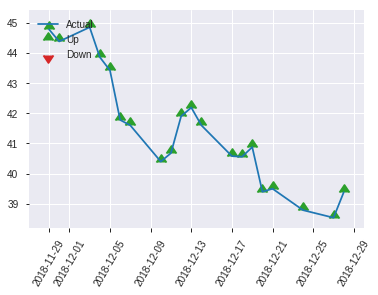


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2647859741586233
RMSE: 0.5145735847851338
LogLoss: 0.7244573678418326
Mean Per-Class Error: 0.4881801962533453
AUC: 0.47572320632088694
pr_auc: 0.4556903947614127
Gini: -0.048553587358226125
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2599308490753174: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    118  0        (0.0/118.0)
Total  0    251  0.5299   (133.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.259931     0.639566   250
max f2                       0.259931     0.816044   250
max f0point5                 0.259931     0.525847   250
max accuracy                 0.674727     0.537849   13
max precision                0.7124       1          0
max recall                   0.259931     1          250
max specificity              0.7124       1          0
max absolute_mcc             0.33148      0.0955538  233
max min_per_class_accuracy   0.479428     0.473684   125
max mean_per_class_accuracy  0.659891     0.51182    15

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 48.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.704467           1.41808   1.41808            0.666667         0.709175  0.666667                    0.709175            0.0169492       0.0169492                  41.8079   41.8079
    2        0.0239044                   0.693132           0         0.70904            0                0.696613  0.333333                    0.702894            0               0.0169492                  -100      -29.096
    3        0.0318725                   0.688487           1.06356   0.797669           0.5              0.689621  0.375                       0.699576            0.00847458      0.0254237                  6.35593   -20.2331
    4        0.0438247                   0.682447           1.41808   0.966872           0.666667         0.685795  0.454545                    0.695817            0.0169492       0.0423729                  41.8079   -3.31279
    5        0.0517928                   0.675374           2.12712   1.14537            1                0.67649   0.538462                    0.692844            0.0169492       0.059322                   112.712   14.5372
    6        0.103586                    0.620922           0.818123  0.981747           0.384615         0.643515  0.461538                    0.668179            0.0423729       0.101695                   -18.1877  -1.82529
    7        0.151394                    0.597985           1.24082   1.06356            0.583333         0.608003  0.5                         0.649176            0.059322        0.161017                   24.0819   6.35593
    8        0.203187                    0.569021           0.654498  0.959289           0.307692         0.583942  0.45098                     0.632548            0.0338983       0.194915                   -34.5502  -4.07112
    9        0.302789                    0.534427           1.02102   0.979594           0.48             0.552847  0.460526                    0.606331            0.101695        0.29661                    2.10169   -2.04059
    10       0.40239                     0.502451           0.935932  0.968787           0.44             0.519095  0.455446                    0.584738            0.0932203       0.389831                   -6.40678  -3.12133
    11       0.501992                    0.479428           0.850847  0.945386           0.4              0.494109  0.444444                    0.566756            0.0847458       0.474576                   -14.9153  -5.46139
    12       0.601594                    0.456694           1.19119   0.986081           0.56             0.464751  0.463576                    0.549868            0.118644        0.59322                    19.1186   -1.39185
    13       0.701195                    0.430402           0.765763  0.954786           0.36             0.441453  0.448864                    0.534468            0.0762712       0.669492                   -23.4237  -4.52138
    14       0.800797                    0.391811           0.935932  0.952441           0.44             0.409174  0.447761                    0.518884            0.0932203       0.762712                   -6.40678  -4.75588
    15       0.900398                    0.358606           1.27627   0.988263           0.6              0.371915  0.464602                    0.502626            0.127119        0.889831                   27.6271   -1.17369
    16       1                           0.259931           1.1061    1                  0.52             0.308481  0.47012                     0.4832

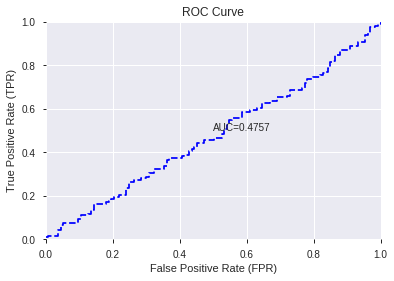

This function is available for GLM models only


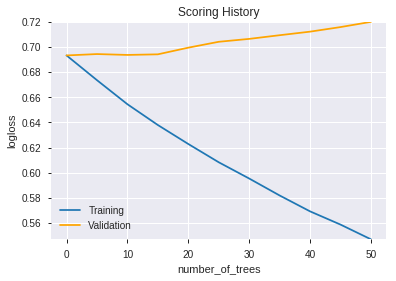

--2019-08-27 16:31:13--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.60
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.60|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190827_163050',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190827_163050',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_985e',
   'type

['CORREL_12',
 'CORREL_8',
 'COSH',
 'COS',
 'SUB',
 'SIN',
 'STOCHRSI_fastk',
 'SAREXT',
 'aroondown_8',
 'weekday_name',
 'EXP',
 'days_in_month',
 'SINH',
 'CDLDOJI',
 'HT_TRENDMODE',
 'CDLRICKSHAWMAN',
 'is_month_end']

In [22]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [24]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [25]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [26]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [28]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [29]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [30]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [32]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [33]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [34]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [36]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [37]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [38]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [40]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [41]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [42]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [44]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [45]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [46]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [47]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [896 918] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_163212_model_4  0.513094  4.880392              0.478399  0.685738  0.470237
1  DeepLearning_grid_1_AutoML_20190827_163212_model_8  0.500000  0.696579              0.500000  0.501712  0.251715
2  DeepLearning_grid_1_AutoML_20190827_163212_model_5  0.489072  0.795295              0.500000  0.518464  0.268805
3  DeepLearning_grid_1_AutoML_20190827_163212_model_3  0.484421  2.745259              0.500000  0.597805  0.357370
4  DeepLearning_grid_1_AutoML_20190827_163212_model_9  0.478814  0.702995              0.500000  0.504875  0.254899
5  DeepLearning_grid_1_AutoML_20190827_163212_model_1  0.478782  9.253352              0.500000  0.738834  0.545876
6               DeepLearning_1_AutoML_20190827_163212  0.476934  3.793072              0.500000  0.609745  0.371789
7  DeepLearning_grid_1_AutoML_20190827_163212_model_6  0.465018  0.747836              0.500000  0.517879  0.268199
8  DeepLearning_grid_1_AutoML_20190827_163212_model_2  0.451669  2.741628              0.500000  0.580841  0.337376
9  DeepLearning_grid_1_AutoML_20190827_163212_model_7  0.444119  3.114355              0.500000  0.618861  0.382989

variable  relative_importance  scaled_importance  percentage
0          CDLUPSIDEGAP2CROWS             1.000000           1.000000    0.001165
1            CDLSTICKSANDWICH             0.965487           0.965487    0.001125
2          CDLEVENINGDOJISTAR             0.957702           0.957702    0.001116
3                   CDL2CROWS             0.957616           0.957616    0.001116
4            CDLABANDONEDBABY             0.956692           0.956692    0.001115
...                       ...                  ...                ...         ...
1037                   MIN_24             0.763743           0.763743    0.000890
1038                  KAMA_24             0.760545           0.760545    0.000886
1039              MIDPOINT_14             0.758806           0.758806    0.000884
1040              MINUS_DM_30             0.752815           0.752815    0.000877
1041  BBANDS_upperband_20_1_4             0.750250           0.750250    0.000874

[1042 rows x 4 columns]

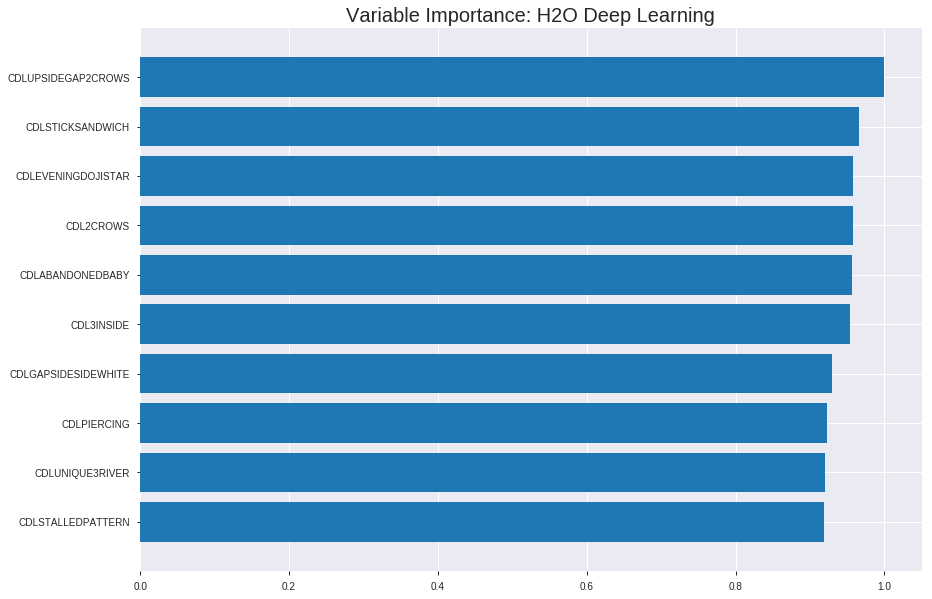

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_163212_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.42235742403525783
RMSE: 0.6498903169268317
LogLoss: 2.470815675842575
Mean Per-Class Error: 0.46139535853215596
AUC: 0.5400546116346753
pr_auc: 0.48592044369070064
Gini: 0.08010922326935055
Confusion Matrix (Act/Pred) for max f1 @ threshold = 6.381641131775396e-05: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    851   1        (851.0/851.0)
1      0    902   0        (0.0/902.0)
Total  0    1753  0.4855   (851.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       6.38164e-05  0.679473   399
max f2                       6.38164e-05  0.841261   399
max f0point5                 0.00150975   0.573759   395
max accuracy                 0.968833     0.536224   42
max precision                0.999946     0.5875     0
max recall                   6.38164e-05  1          399
max specificity              0.999946     0.922444   0
max absolute_mcc             0.968833     0.0782024  42
max min_per_class_accuracy   0.886241     0.529965   93
max mean_per_class_accuracy  0.968833     0.538605   42

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 60.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.999987           1.29564   1.29564            0.666667         0.999992     0.666667                    0.999992            0.0133038       0.0133038                  29.5639   29.5639
    2        0.0205362                   0.99998            1.0797    1.18767            0.555556         0.999983     0.611111                    0.999987            0.0110865       0.0243902                  7.96994   18.7669
    3        0.0302339                   0.999974           1.02889   1.13674            0.529412         0.999977     0.584906                    0.999984            0.00997783      0.0343681                  2.889     13.674
    4        0.040502                    0.999964           1.18767   1.14965            0.611111         0.999969     0.591549                    0.99998             0.0121951       0.0465632                  18.7669   14.9652
    5        0.0501997                   0.999951           0.800248  1.08215            0.411765         0.999959     0.556818                    0.999976            0.00776053      0.0543237                  -19.9752  8.21533
    6        0.100399                    0.999841           1.19258   1.13737            0.613636         0.9999       0.585227                    0.999938            0.059867        0.114191                   19.2577   13.7365
    7        0.150029                    0.999585           0.96056   1.07888            0.494253         0.999738     0.555133                    0.999872            0.0476718       0.161863                   -3.94398  7.88784
    8        0.200228                    0.999078           1.14841   1.09631            0.590909         0.999351     0.564103                    0.999741            0.0576497       0.219512                   14.8408   9.63102
    9        0.300057                    0.995728           1.03281   1.07518            0.531429         0.997805     0.553232                    0.999097            0.103104        0.322616                   3.28096   7.51836
    10       0.399886                    0.976927           1.08834   1.07847            0.56             0.988254     0.554922                    0.99639             0.108647        0.431264                   8.8337    7.84673
    11       0.500285                    0.888936           0.982772  1.05926            0.505682         0.943269     0.54504                     0.98573             0.0986696       0.529933                   -1.72281  5.92627
    12       0.600114                    0.557083           0.988388  1.04747            0.508571         0.741626     0.538973                    0.945123            0.0986696       0.628603                   -1.16123  4.74727
    13       0.699943                    0.100375           0.910649  1.02796            0.468571         0.288216     0.528932                    0.851432            0.0909091       0.719512                   -8.93506  2.79583
    14       0.799772                    0.00973684         1.0106    1.02579            0.52             0.0426991    0.527817                    0.750485            0.100887        0.820399                   1.05987   2.57915
    15       0.899601                    0.000741896        0.955071  1.01794            0.491429         0.0039034    0.523779                    0.667636            0.0953437       0.915743                   -4.49287  1.79436
    16       1                           3.19493e-07        0.839221  1                  0.431818         0.000



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.47369060218732967
RMSE: 0.6882518450300948
LogLoss: 5.9673900259072
Mean Per-Class Error: 0.48549523414836304
AUC: 0.47913545219802994
pr_auc: 0.3843838176739178
Gini: -0.041729095603940114
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.002055822789094763: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      10   237  0.9595   (237.0/247.0)
1      4    250  0.0157   (4.0/254.0)
Total  14   487  0.481    (241.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00205582   0.674764   364
max f2                       0.000275852  0.837179   378
max f0point5                 0.002846     0.568286   359
max accuracy                 0.002846     0.520958   359
max precision                0.99661      0.518519   93
max recall                   0.000275852  1          378
max specificity              1            0.736842   0
max absolute_mcc             0.348679     0.0839909  235
max min_per_class_accuracy   0.978567     0.507874   127
max mean_per_class_accuracy  0.002846     0.514505   359

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 69.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.195609                    1                  0.92584   0.92584            0.469388         1           0.469388                    1                   0.181102        0.181102                   -7.41604  -7.41604
    2        0.201597                    1                  1.97244   0.956927           1                1           0.485149                    1                   0.011811        0.192913                   97.2441   -4.30732
    3        0.301397                    0.999936           0.788976  0.901314           0.4              0.999991    0.456954                    0.999997            0.0787402       0.271654                   -21.1024  -9.86859
    4        0.401198                    0.998292           1.30181   1.00094            0.66             0.999434    0.507463                    0.999857            0.129921        0.401575                   30.1811   0.0940181
    5        0.500998                    0.978201           1.06512   1.01372            0.54             0.991314    0.513944                    0.998155            0.106299        0.507874                   6.51181   1.37246
    6        0.600798                    0.901941           0.749528  0.969838           0.38             0.938705    0.491694                    0.98828             0.0748031       0.582677                   -25.0472  -3.01619
    7        0.700599                    0.406457           0.828425  0.949694           0.42             0.703723    0.481481                    0.947745            0.0826772       0.665354                   -17.1575  -5.03062
    8        0.800399                    0.0915175          1.26236   0.98868            0.64             0.229497    0.501247                    0.858188            0.125984        0.791339                   26.2362   -1.13201
    9        0.9002                      0.0155145          1.14402   1.0059             0.58             0.0425169   0.509978                    0.767758            0.114173        0.905512                   14.4016   0.590115
    10       1                           0.000275852        0.946772  1                  0.48             0.00507262  0.506986                    0.691642            0.0944882       1                          -5.32283  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 16:37:31  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 16:37:35  6.856 sec         133 obs/sec       0.290359  1             509        0.652932         4.25075             -0.706725      0.532481        0.378353           0.86376          0.485454                         0.679185           7.9176                -0.845531        0.547069          0.509505             1.31496            0.493014
    2019-08-27 16:38:07  38.249 sec        139 obs/sec       2.57102   9             4507       0.64989          2.47082             -0.690861      0.540055        0.48592            1.29564          0.485454                         0.688252           5.96739               -0.895132        0.479135          0.384384             0.92584            0.481038
    2019-08-27 16:38:38  1 min  9.788 sec  148 obs/sec       5.14261   18            9015       0.574905         1.21672             -0.323182      0.607194        0.581971           1.40361          0.46891                          0.641758           6.22026               -0.647733        0.544558          0.532905             0.98622            0.493014
    2019-08-27 16:39:10  1 min 41.721 sec  156 obs/sec       8.01997   28            14059      0.563945         1.17875             -0.273214      0.616263        0.614754           1.29564          0.464917                         0.660643           6.4541                -0.746135        0.549739          0.551858             1.31496            0.493014
    2019-08-27 16:39:41  2 min 12.506 sec  161 obs/sec       10.85     38            19020      0.508463         0.817862            -0.0350154     0.689025        0.684965           1.61955          0.373075                         0.634302           6.29161               -0.609672        0.546933          0.536976             1.31496            0.493014
    2019-08-27 16:40:13  2 min 44.460 sec  166 obs/sec       13.9464   49            24448      0.541443         1.09436             -0.173636      0.673301        0.705832           1.94346          0.476326                         0.644374           6.25325               -0.661195        0.53529           0.523114             0.98622            0.493014
    2019-08-27 16:40:44  3 min 15.316 sec  170 obs/sec       17.0308   60            29855      0.522226         0.855204            -0.0918036     0.710039        0.70443            1.83549          0.375357                         0.668556           7.02005               -0.78822         0.44736           0.33163              0.910357           0.491018
    2019-08-27 16:40:47  3 min 18.435 sec  170 obs/sec       17.0308   60            29855      0.64989          2.47082             -0.690861      0.540055        0.48592            1.29564          0.485454                         0.688252           5.96739               -0.895132        0.479135          0.384384             0.92584            0.481038

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLUPSIDEGAP2CROWS       1.0                    1.0                  0.0011650614543838535
CDLSTICKSANDWICH         0.9654865860939026     0.9654865860939026   0.0011248512061826637
CDLEVENINGDOJISTAR       0.9577018618583679     0.9577018618583679   0.0011157815240428345
CDL2CROWS                0.9576160907745361     0.9576160907745361   0.0011156815954591615
CDLABANDONEDBABY         0.9566923975944519     0.9566923975944519   0.001114605436139368
---                      ---                    ---                  ---
MIN_24                   0.7637428641319275     0.7637428641319275   0.0008898073720608333
KAMA_24                  0.7605448961257935     0.7605448961257935   0.0008860815428045338
MIDPOINT_14              0.7588055729866028     0.7588055729866028   0.0008840551244583448
MINUS_DM_30              0.7528150081634521     0.7528150081634521   0.0008770757482929041
BBANDS_upperband_20_1_4  0.7502500414848328     0.7502500414848328   0.0008740874044838657


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5418326693227091)

('F1', 0.6462395543175488)

('auc', 0.5130941761182618)

('logloss', 4.880392436805535)

('mean_per_class_error', 0.47374792914489616)

('rmse', 0.6857383288164091)

('mse', 0.4702370556079215)

deeplearning prediction progress: |███████████████████████████████████████| 100%


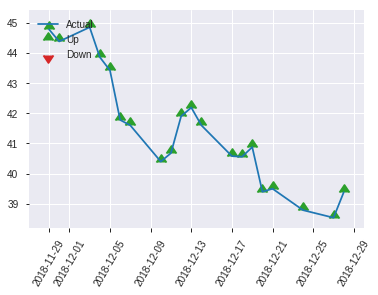


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4702370556079215
RMSE: 0.6857383288164091
LogLoss: 4.880392436805535
Mean Per-Class Error: 0.47374792914489616
AUC: 0.5130941761182618
pr_auc: 0.41155201550057796
Gini: 0.026188352236523604
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14499688815658146: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    125  0.9398   (125.0/133.0)
1      2    116  0.0169   (2.0/118.0)
Total  10   241  0.506    (127.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.144997     0.64624   205
max f2                       0.00844382   0.817175  214
max f0point5                 0.386645     0.536062  191
max accuracy                 0.99999      0.541833  9
max precision                0.99999      0.533333  9
max recall                   0.00844382   1         214
max specificity              1            0.864662  0
max absolute_mcc             0.144997     0.110244  205
max min_per_class_accuracy   0.997833     0.511278  90
max mean_per_class_accuracy  0.386645     0.526252  191

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 87.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.10757                     1                  1.10295   1.10295            0.518519         1         0.518519                    1                   0.118644        0.118644                   10.295    10.295
    2        0.151394                    0.999999           1.16025   1.11954            0.545455         1         0.526316                    1                   0.0508475       0.169492                   16.0247   11.9536
    3        0.203187                    0.99998            0.981747  1.08441            0.461538         0.99999   0.509804                    0.999997            0.0508475       0.220339                   -1.82529  8.44134
    4        0.302789                    0.999809           0.935932  1.03557            0.44             0.99992   0.486842                    0.999972            0.0932203       0.313559                   -6.40678  3.55709
    5        0.40239                     0.999297           1.1061    1.05303            0.52             0.999577  0.49505                     0.999874            0.110169        0.423729                   10.6102   5.3029
    6        0.501992                    0.997833           0.935932  1.0298             0.44             0.998582  0.484127                    0.999618            0.0932203       0.516949                   -6.40678  2.97955
    7        0.601594                    0.99209            0.850847  1.00017            0.4              0.995952  0.470199                    0.999011            0.0847458       0.601695                   -14.9153  0.0168369
    8        0.701195                    0.96607            0.935932  0.991044           0.44             0.982022  0.465909                    0.996598            0.0932203       0.694915                   -6.40678  -0.895609
    9        0.800797                    0.875096           1.02102   0.994772           0.48             0.928695  0.467662                    0.988152            0.101695        0.79661                    2.10169   -0.52281
    10       0.900398                    0.388878           1.27627   1.02591            0.6              0.636871  0.482301                    0.949293            0.127119        0.923729                   27.6271   2.59112
    11       1                           0.000912106        0.765763  1                  0.36             0.185668  0.47012                     0.873235            0.0762712       1                          -23.4237  0

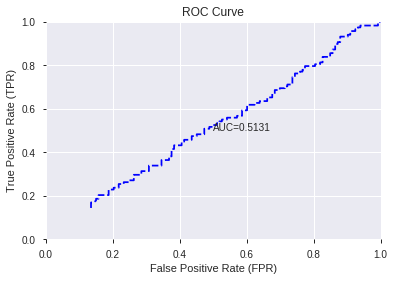

This function is available for GLM models only


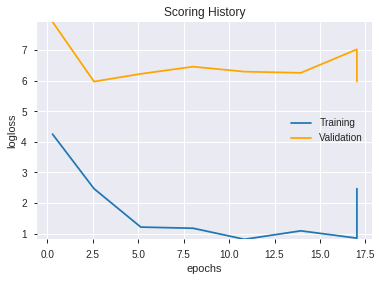

--2019-08-27 17:04:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_163212_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_163212_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLUPSIDEGAP2CROWS',
 'CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'CDL2CROWS',
 'CDLABANDONEDBABY',
 'CDL3INSIDE',
 'CDLGAPSIDESIDEWHITE',
 'CDLPIERCING',
 'CDLUNIQUE3RIVER',
 'CDLSTALLEDPATTERN',
 'CDLINNECK',
 'CDLBREAKAWAY',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'PLUS_DM_30',
 'CDLTAKURI',
 'STDDEV_14',
 'CDLMORNINGDOJISTAR',
 'CDLCOUNTERATTACK',
 'CDLONNECK',
 'BBANDS_lowerband_12_1_5',
 'BBANDS_lowerband_8_1_3',
 'BBANDS_lowerband_24_6_4',
 'BBANDS_lowerband_24_2_2',
 'COS',
 'BBANDS_lowerband_14_5_5',
 'CORREL_30',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_lowerband_20_3_4',
 'BBANDS_upperband_12_7_5',
 'STOCH_slowd',
 'CDLHOMINGPIGEON',
 'MIDPRICE_30',
 'CDLLADDERBOTTOM',
 'BBANDS_upperband_24_7_3',
 'DIV',
 'PLUS_DI_24',
 'is_quarter_end',
 'MIDPRICE_12',
 'MINMAX_min_24',
 'STOCHRSI_fastd',
 'MA_12_7',
 'BBANDS_lowerband_20_6_5',
 'CDL3OUTSIDE',
 'BBANDS_lowerband_8_3_5',
 'CDLTHRUSTING',
 'SUM_14',
 'MINMAX_max_14',
 'MACDFIX_signal_24',
 'BBANDS_lowerband_30_6_3',
 'T3_8_2'

In [48]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_170513_model_1  0.458009  2.524081                   0.5  0.559039  0.312525

variable  relative_importance  scaled_importance    percentage
0                    CORREL_12         8.084287e-03           1.000000  1.009797e-02
1            CDLSTALLEDPATTERN         8.058258e-03           0.996780  1.006545e-02
2           CDLMORNINGDOJISTAR         7.976578e-03           0.986677  9.963429e-03
3                days_in_month         7.064823e-03           0.873896  8.824569e-03
4                 CDLBREAKAWAY         6.668213e-03           0.824836  8.329169e-03
...                        ...                  ...                ...           ...
1037                      SQRT         2.455865e-06           0.000304  3.067585e-06
1038  BBANDS_middleband_14_3_4         2.422586e-06           0.000300  3.026017e-06
1039  BBANDS_middleband_14_3_3         2.151991e-06           0.000266  2.688021e-06
1040  BBANDS_middleband_20_1_2         1.332855e-07           0.000016  1.664850e-07
1041   BBANDS_upperband_24_7_5         6.909791e-08           0.000009  8.630921e-08

[1042 rows x 4 columns]

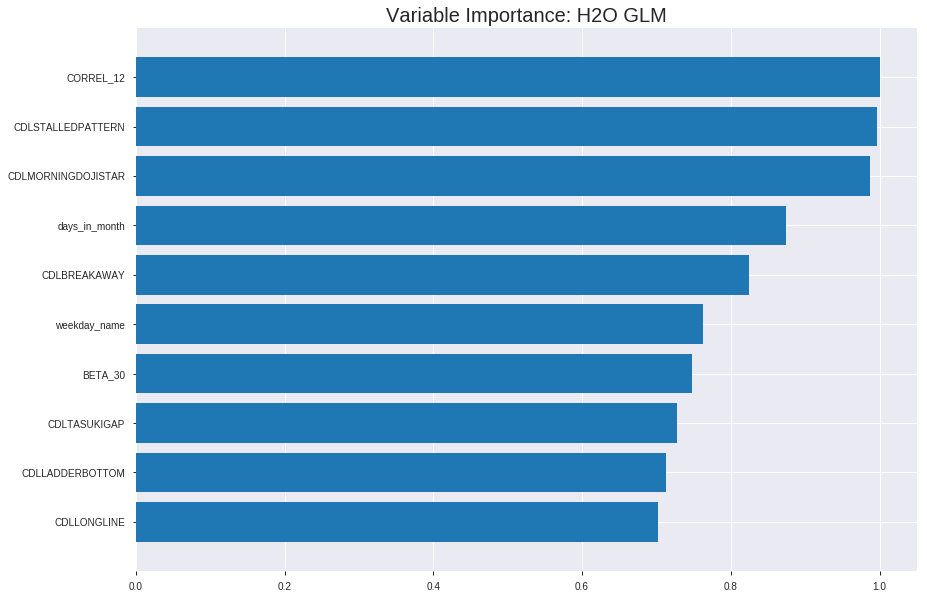

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_170513_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24636191340502
RMSE: 0.4963485805409541
LogLoss: 0.6858473718382528
Null degrees of freedom: 1752
Residual degrees of freedom: 710
Null deviance: 2428.6900635089887
Residual deviance: 2404.5808856649146
AIC: 4490.580885664915
AUC: 0.5893568542030897
pr_auc: 0.5895899387293978
Gini: 0.1787137084061794
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4622333810920612: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   831   0.9765   (831.0/851.0)
1      4    898   0.0044   (4.0/902.0)
Total  24   1729  0.4763   (835.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.462233     0.68263   378
max f2                       0.451076     0.841899  389
max f0point5                 0.496632     0.597317  278
max accuracy                 0.496632     0.575014  278
max precision                0.602727     1         0
max recall                   0.44268      1         395
max specificity              0.602727     1         0
max absolute_mcc             0.496632     0.157021  278
max min_per_class_accuracy   0.512739     0.561692  204
max mean_per_class_accuracy  0.496632     0.567695  278

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102681                   0.577969           1.29564   1.29564            0.666667         0.586243  0.666667                    0.586243            0.0133038       0.0133038                  29.5639    29.5639
    2        0.0205362                   0.572114           1.40361   1.34962            0.722222         0.574643  0.694444                    0.580443            0.0144124       0.0277162                  40.3609    34.9624
    3        0.0302339                   0.566368           1.02889   1.24675            0.529412         0.569891  0.641509                    0.577059            0.00997783      0.037694                   2.889      24.6747
    4        0.040502                    0.563044           1.51158   1.31389            0.777778         0.5647    0.676056                    0.573925            0.0155211       0.0532151                  51.1579    31.3888
    5        0.0501997                   0.560124           1.48617   1.34717            0.764706         0.560998  0.693182                    0.571428            0.0144124       0.0676275                  48.6175    34.717
    6        0.100399                    0.549396           1.14841   1.24779            0.590909         0.554139  0.642045                    0.562783            0.0576497       0.125277                   14.8408    24.7789
    7        0.150029                    0.5418             1.13927   1.21189            0.586207         0.545549  0.623574                    0.557082            0.056541        0.181818                   13.9269    21.1891
    8        0.200228                    0.535486           1.28092   1.2292             0.659091         0.538746  0.632479                    0.552485            0.0643016       0.24612                    28.0916    22.9196
    9        0.300057                    0.52711            1.06613   1.17494            0.548571         0.531121  0.604563                    0.545377            0.10643         0.35255                    6.61261    17.4943
    10       0.399886                    0.519557           0.999493  1.13114            0.514286         0.523309  0.582026                    0.539868            0.0997783       0.452328                   -0.050681  13.1143
    11       0.500285                    0.51282            1.08215   1.12131            0.556818         0.51627   0.576967                    0.535132            0.108647        0.560976                   8.21533    12.1312
    12       0.600114                    0.506026           0.93286   1.08996            0.48             0.509337  0.560837                    0.530841            0.0931264       0.654102                   -6.71397   8.99627
    13       0.699943                    0.499564           1.04392   1.0834             0.537143         0.502914  0.557457                    0.526858            0.104213        0.758315                   4.39151    8.33952
    14       0.799772                    0.493683           0.955071  1.06738            0.491429         0.496658  0.549215                    0.523089            0.0953437       0.853659                   -4.49287   6.73776
    15       0.899601                    0.483143           0.710751  1.0278             0.365714         0.488862  0.528852                    0.51929             0.0709534       0.924612                   -28.9249   2.78027
    16       1                           0.424801           0.750882  1                  0.386364         0.47204   0.514546                    0



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.31384700910494473
RMSE: 0.5602205004325929
LogLoss: 3.7200864740814943
Null degrees of freedom: 500
Residual degrees of freedom: -542
Null deviance: 694.5502849840166
Residual deviance: 11770.863838412273
AIC: 13856.863838412273
AUC: 0.5486706621186521
pr_auc: 0.5439829580451345
Gini: 0.09734132423730424
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.4175565580090902e-08: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    247  1        (247.0/247.0)
1      0    254  0        (0.0/254.0)
Total  0    501  0.493    (247.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.41756e-08  0.672848  399
max f2                       2.41756e-08  0.837179  399
max f0point5                 0.447967     0.57418   281
max accuracy                 0.453992     0.562874  275
max precision                0.588257     1         0
max recall                   2.41756e-08  1         399
max specificity              0.588257     1         0
max absolute_mcc             0.447967     0.125059  281
max min_per_class_accuracy   0.480338     0.550607  245
max mean_per_class_accuracy  0.453992     0.562036  275

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 33.36 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.577651           1.6437    1.6437             0.833333         0.583427     0.833333                    0.583427            0.019685        0.019685                   64.3701   64.3701
    2        0.0219561                   0.567759           1.18346   1.4345             0.6              0.569507     0.727273                    0.577099            0.011811        0.0314961                  18.3465   43.4503
    3        0.0319361                   0.558854           0.394488  1.1095             0.2              0.561974     0.5625                      0.572373            0.00393701      0.0354331                  -60.5512  10.9498
    4        0.0419162                   0.553059           0.788976  1.03318            0.4              0.555266     0.52381                     0.5683              0.00787402      0.0433071                  -21.1024  3.31834
    5        0.0518962                   0.550333           0.788976  0.98622            0.4              0.551849     0.5                         0.565136            0.00787402      0.0511811                  -21.1024  -1.37795
    6        0.101796                    0.539729           1.18346   1.08291            0.6              0.544158     0.54902                     0.554852            0.0590551       0.110236                   18.3465   8.29088
    7        0.151697                    0.530862           1.02567   1.06408            0.52             0.533812     0.539474                    0.547931            0.0511811       0.161417                   2.56693   6.408
    8        0.201597                    0.521173           1.34126   1.13269            0.68             0.525507     0.574257                    0.542381            0.0669291       0.228346                   34.126    13.2689
    9        0.301397                    0.508935           1.06512   1.11031            0.54             0.514146     0.562914                    0.533031            0.106299        0.334646                   6.51181   11.0314
    10       0.401198                    0.496776           1.06512   1.09907            0.54             0.502796     0.557214                    0.52551             0.106299        0.440945                   6.51181   9.90716
    11       0.500998                    0.480338           1.10457   1.10017            0.56             0.489362     0.557769                    0.518309            0.110236        0.551181                   10.4567   10.0166
    12       0.600798                    0.407016           0.907323  1.06813            0.46             0.45568      0.541528                    0.507906            0.0905512       0.641732                   -9.26772  6.81325
    13       0.700599                    0.113628           0.946772  1.05084            0.48             0.255541     0.532764                    0.471956            0.0944882       0.73622                    -5.32283  5.08446
    14       0.800399                    1.94081e-05        0.749528  1.01327            0.38             0.0294004    0.513716                    0.416775            0.0748031       0.811024                   -25.0472  1.32739
    15       0.9002                      1.65629e-26        0.98622   1.01027            0.5              9.93317e-07  0.512195                    0.370569            0.0984252       0.909449                   -1.37795  1.02746
    16       1                           0                  0.907323  1                  0.46             2.677


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:05:17  0.000 sec   2            2.8       1043          1.37169           23.4947
    2019-08-27 17:05:19  2.252 sec   4            2         1043          1.3686            29.8958
    2019-08-27 17:05:22  4.519 sec   6            1.5       1043          1.365             36.1689
    2019-08-27 17:05:24  6.755 sec   8            1.1       1043          1.36084           41.5992
    2019-08-27 17:05:26  9.127 sec   10           0.78      1043          1.35613           46.5133

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5537848605577689)

('F1', 0.6395663956639567)

('auc', 0.4580094303555499)

('logloss', 2.5240812101385073)

('mean_per_class_error', 0.47170893335032493)

('rmse', 0.5590392224351748)

('mse', 0.3125248522209248)

glm prediction progress: |████████████████████████████████████████████████| 100%


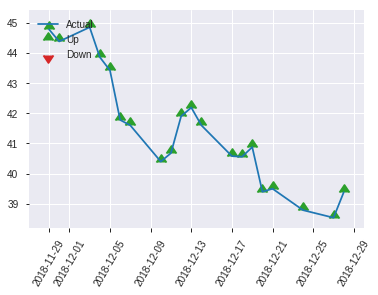


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.3125248522209248
RMSE: 0.5590392224351748
LogLoss: 2.5240812101385073
Null degrees of freedom: 250
Residual degrees of freedom: -792
Null deviance: 349.04545729516275
Residual deviance: 3836.143465001691
AIC: 5922.143465001691
AUC: 0.4580094303555499
pr_auc: 0.4724763039782695
Gini: -0.08398113928890016
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.539659363470201e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    118  0        (0.0/118.0)
Total  0    251  0.5299   (133.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       4.53966e-49  0.639566  240
max f2                       4.53966e-49  0.816044  240
max f0point5                 4.53966e-49  0.525847  240
max accuracy                 0.542329     0.553785  17
max precision                0.579093     1         0
max recall                   4.53966e-49  1         240
max specificity              0.579093     1         0
max absolute_mcc             0.493913     0.140177  109
max min_per_class_accuracy   0.487608     0.443609  126
max mean_per_class_accuracy  0.542329     0.528291  17

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 37.86 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.565599           1.41808   1.41808            0.666667         0.57365      0.666667                    0.57365             0.0169492       0.0169492                  41.8079   41.8079
    2        0.0239044                   0.556397           2.12712   1.7726             1                0.560304     0.833333                    0.566977            0.0254237       0.0423729                  112.712   77.2599
    3        0.0318725                   0.554385           1.06356   1.59534            0.5              0.555242     0.75                        0.564043            0.00847458      0.0508475                  6.35593   59.5339
    4        0.0438247                   0.552354           0.70904   1.35362            0.333333         0.553056     0.636364                    0.561047            0.00847458      0.059322                   -29.096   35.3621
    5        0.0517928                   0.546401           1.06356   1.309              0.5              0.549483     0.615385                    0.559268            0.00847458      0.0677966                  6.35593   30.8996
    6        0.103586                    0.538914           0.818123  1.06356            0.384615         0.54131      0.5                         0.550289            0.0423729       0.110169                   -18.1877  6.35593
    7        0.151394                    0.532822           1.24082   1.11954            0.583333         0.536162     0.526316                    0.545828            0.059322        0.169492                   24.0819   11.9536
    8        0.203187                    0.527528           0.490874  0.959289           0.230769         0.530585     0.45098                     0.541943            0.0254237       0.194915                   -50.9126  -4.07112
    9        0.302789                    0.51452            1.02102   0.979594           0.48             0.520311     0.460526                    0.534827            0.101695        0.29661                    2.10169   -2.04059
    10       0.40239                     0.500163           0.510508  0.863484           0.24             0.505957     0.405941                    0.527681            0.0508475       0.347458                   -48.9492  -13.6516
    11       0.501992                    0.488205           0.935932  0.877858           0.44             0.492245     0.412698                    0.52065             0.0932203       0.440678                   -6.40678  -12.2142
    12       0.601594                    0.476308           1.1061    0.915647           0.52             0.482257     0.430464                    0.514294            0.110169        0.550847                   10.6102   -8.43529
    13       0.701195                    0.366083           1.1061    0.9427             0.52             0.427653     0.443182                    0.501987            0.110169        0.661017                   10.6102   -5.72997
    14       0.800797                    0.134244           1.1061    0.963024           0.52             0.237703     0.452736                    0.469116            0.110169        0.771186                   10.6102   -3.69761
    15       0.900398                    1.50813e-06        1.19119   0.988263           0.56             0.0298182    0.464602                    0.420521            0.118644        0.889831                   19.1186   -1.17369
    16       1                           1.34519e-183       1.1061    1                  0.52         

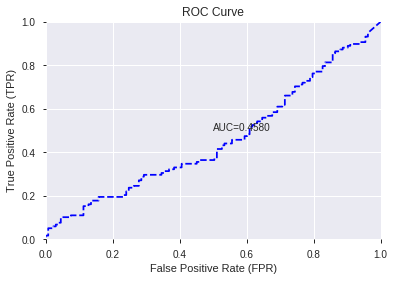

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


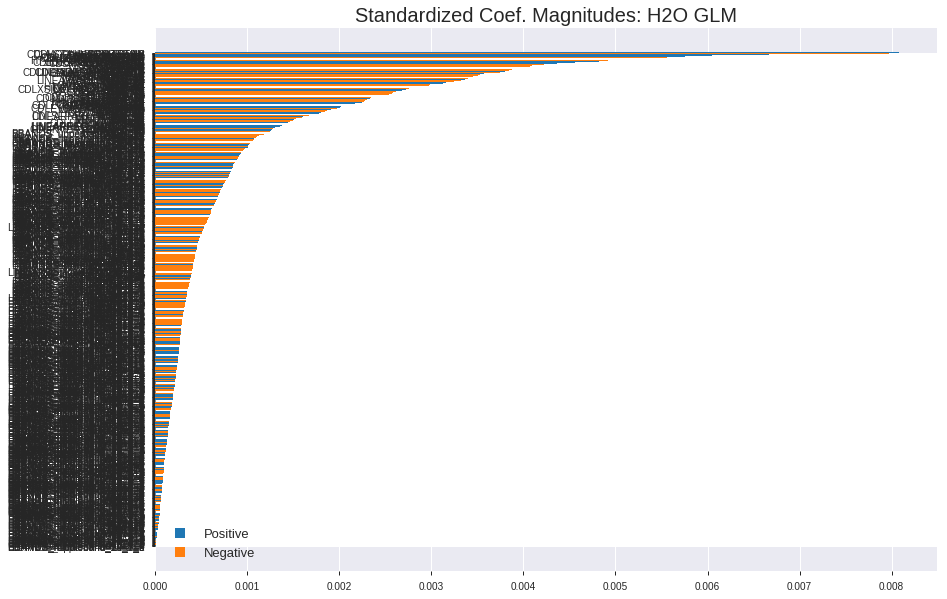

'log_likelihood'
--2019-08-27 17:05:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.114.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.114.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_170513_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_170513_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CORREL_12',
 'CDLSTALLEDPATTERN',
 'CDLMORNINGDOJISTAR',
 'days_in_month',
 'CDLBREAKAWAY',
 'weekday_name',
 'BETA_30',
 'CDLTASUKIGAP',
 'CDLLADDERBOTTOM',
 'CDLLONGLINE',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLHIGHWAVE',
 'CDLDOJISTAR',
 'HT_PHASOR_quadrature',
 'CDLONNECK',
 'STOCHRSI_fastd',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'aroonup_12',
 'CDLMATCHINGLOW',
 'CDL3INSIDE',
 'SUB',
 'STOCH_slowd',
 'MFI_14',
 'is_month_end',
 'SINH',
 'EXP',
 'COSH',
 'aroondown_8',
 'MACDFIX_hist_8',
 'MACD_hist',
 'is_quarter_end',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'LINEARREG_SLOPE_8',
 'CDLABANDONEDBABY',
 'CDLUPSIDEGAP2CROWS',
 'BOP',
 'CDLMORNINGSTAR',
 'MACDFIX_hist_12',
 'CORREL_14',
 'MOM_8',
 'MACDFIX_hist_14',
 'STOCHRSI_fastk',
 'is_quarter_start',
 'ROCR100_14',
 'ROCR_14',
 'ROCP_14',
 'ROC_14',
 'NATR_8',
 'LINEARREG_ANGLE_8',
 'AROONOSC_8',
 'day',
 'AROONOSC_12',
 'BETA_24',
 'ATR_8',
 'MACDFIX_hist_20',
 'MACDFIX_hist_24',
 'SAREXT',
 'TR

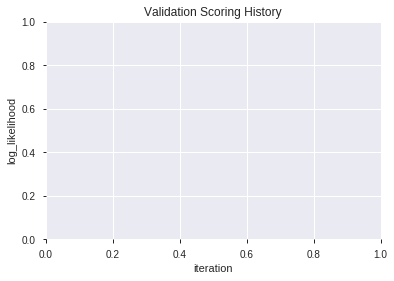

In [49]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_170656_model_1  0.502804  0.709680              0.500000  0.507730  0.257790
1               XGBoost_2_AutoML_20190827_170656  0.478336  0.722089              0.500000  0.513475  0.263656
2  XGBoost_grid_1_AutoML_20190827_170656_model_6  0.473620  0.717478              0.496241  0.511495  0.261627
3  XGBoost_grid_1_AutoML_20190827_170656_model_4  0.470116  0.709688              0.484962  0.508021  0.258086
4  XGBoost_grid_1_AutoML_20190827_170656_model_2  0.460048  0.713876              0.500000  0.509980  0.260079
5               XGBoost_3_AutoML_20190827_170656  0.454441  0.722445              0.500000  0.513796  0.263987
6  XGBoost_grid_1_AutoML_20190827_170656_model_5  0.447814  0.758019              0.500000  0.528994  0.279834
7  XGBoost_grid_1_AutoML_20190827_170656_model_3  0.435453  0.744135              0.500000  0.523100  0.273634
8  XGBoost_grid_1_AutoML_20190827_170656_model_7  0.430610  0.741115              0.489200  0.522266  0.272762
9               XGBoost_1_AutoML_20190827_170656  0.415254  0.743362              0.496241  0.523534  0.274088

variable  relative_importance  scaled_importance  percentage
0                        COS           184.885269           1.000000    0.038434
1                        DIV           133.389389           0.721471    0.027729
2                  CORREL_24            99.970581           0.540717    0.020782
3                  PLUS_DM_8            98.650566           0.533577    0.020507
4                 MINUS_DM_8            93.352180           0.504920    0.019406
..                       ...                  ...                ...         ...
220        MACDFIX_signal_24             3.466605           0.018750    0.000721
221  BBANDS_lowerband_24_3_3             3.323347           0.017975    0.000691
222       LINEARREG_SLOPE_20             2.946626           0.015938    0.000613
223                 SAR_0.14             2.209579           0.011951    0.000459
224  BBANDS_upperband_20_1_5             2.163560           0.011702    0.000450

[225 rows x 4 columns]

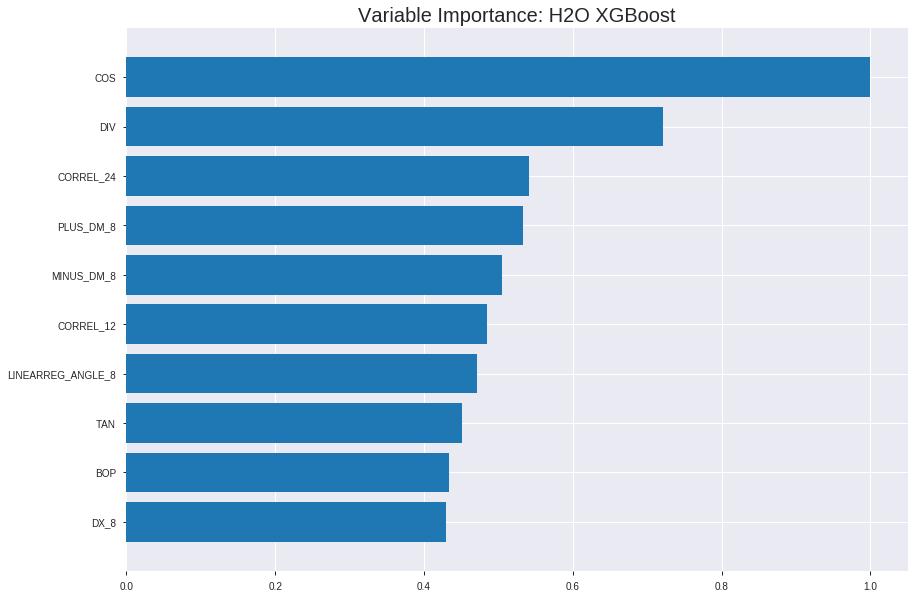

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_170656_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.18466078016090884
RMSE: 0.42972174736788554
LogLoss: 0.5591540620596789
Mean Per-Class Error: 0.136947272154059
AUC: 0.9433319610944213
pr_auc: 0.9483945454453814
Gini: 0.8866639221888426
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5162645056843758: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      726  125  0.1469   (125.0/851.0)
1      120  782  0.133    (120.0/902.0)
Total  846  907  0.1398   (245.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.516265     0.864566  192
max f2                       0.461121     0.912015  252
max f0point5                 0.548929     0.891987  159
max accuracy                 0.523929     0.862521  185
max precision                0.771665     1         0
max recall                   0.39927      1         311
max specificity              0.771665     1         0
max absolute_mcc             0.523929     0.725884  185
max min_per_class_accuracy   0.518388     0.857814  190
max mean_per_class_accuracy  0.523929     0.863053  185

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.7126             1.94346   1.94346            1                0.729879  1                           0.729879            0.0199557       0.0199557                  94.3459   94.3459
    2        0.0205362                   0.694108           1.94346   1.94346            1                0.703895  1                           0.716887            0.0199557       0.0399113                  94.3459   94.3459
    3        0.0302339                   0.684507           1.94346   1.94346            1                0.6882    1                           0.707685            0.018847        0.0587583                  94.3459   94.3459
    4        0.040502                    0.677663           1.94346   1.94346            1                0.681028  1                           0.700927            0.0199557       0.078714                   94.3459   94.3459
    5        0.0501997                   0.671498           1.94346   1.94346            1                0.673795  1                           0.695686            0.018847        0.097561                   94.3459   94.3459
    6        0.100399                    0.645185           1.94346   1.94346            1                0.656993  1                           0.676339            0.097561        0.195122                   94.3459   94.3459
    7        0.150029                    0.62297            1.94346   1.94346            1                0.633899  1                           0.6623              0.0964523       0.291574                   94.3459   94.3459
    8        0.200228                    0.605678           1.89929   1.93239            0.977273         0.614384  0.994302                    0.650287            0.0953437       0.386918                   89.9289   93.2385
    9        0.300057                    0.575173           1.84351   1.90282            0.948571         0.589205  0.979087                    0.629965            0.184035        0.570953                   84.351    90.2816
    10       0.399886                    0.547711           1.6214    1.83256            0.834286         0.561728  0.942939                    0.61293             0.161863        0.732816                   62.14     83.2563
    11       0.500285                    0.521109           1.17049   1.6997             0.602273         0.534505  0.874572                    0.597191            0.117517        0.850333                   17.0492   69.9696
    12       0.600114                    0.490854           0.799595  1.54996            0.411429         0.505765  0.797529                    0.581983            0.0798226       0.930155                   -20.0405  54.9964
    13       0.699943                    0.455768           0.455325  1.39384            0.234286         0.474396  0.717196                    0.566638            0.0454545       0.97561                    -54.4675  39.3842
    14       0.799772                    0.420196           0.22211   1.24758            0.114286         0.438881  0.64194                     0.550691            0.0221729       0.997783                   -77.789   24.7584
    15       0.899601                    0.375964           0.022211  1.1116             0.0114286        0.399375  0.571972                    0.5339              0.00221729      1                          -97.7789  11.1604
    16       1                           0.221934           0         1                  0                0.330107  0.514546                    0.513439         



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.259381567498442
RMSE: 0.5092951673621516
LogLoss: 0.7127642130659533
Mean Per-Class Error: 0.4849851764480857
AUC: 0.49095444547164396
pr_auc: 0.500438790201109
Gini: -0.018091109056712074
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2872593104839325: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    239  0.9676   (239.0/247.0)
1      3    251  0.0118   (3.0/254.0)
Total  11   490  0.483    (242.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.287259     0.674731   388
max f2                       0.23447      0.837179   399
max f0point5                 0.287259     0.566847   388
max accuracy                 0.287259     0.516966   388
max precision                0.692436     1          0
max recall                   0.23447      1          399
max specificity              0.692436     1          0
max absolute_mcc             0.287259     0.0702048  388
max min_per_class_accuracy   0.508833     0.511811   199
max mean_per_class_accuracy  0.508833     0.515015   199

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 50.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.668808           0.98622   0.98622            0.5              0.680509  0.5                         0.680509            0.011811        0.011811                   -1.37795  -1.37795
    2        0.0219561                   0.656679           1.18346   1.07588            0.6              0.662908  0.545455                    0.672509            0.011811        0.023622                   18.3465   7.58769
    3        0.0319361                   0.648796           0         0.739665           0                0.651516  0.375                       0.665948            0               0.023622                   -100      -26.0335
    4        0.0419162                   0.64378            1.57795   0.939258           0.8              0.645917  0.47619                     0.661179            0.015748        0.0393701                  57.7953   -6.07424
    5        0.0518962                   0.639423           1.18346   0.98622            0.6              0.64092   0.5                         0.657283            0.011811        0.0511811                  18.3465   -1.37795
    6        0.101796                    0.614316           1.18346   1.08291            0.6              0.625255  0.54902                     0.641583            0.0590551       0.110236                   18.3465   8.29088
    7        0.151697                    0.586674           0.710079  0.960267           0.36             0.601391  0.486842                    0.628362            0.0354331       0.145669                   -28.9921  -3.97327
    8        0.201597                    0.578532           0.946772  0.956927           0.48             0.582473  0.485149                    0.617003            0.0472441       0.192913                   -5.32283  -4.30732
    9        0.301397                    0.553113           1.02567   0.979689           0.52             0.564898  0.496689                    0.59975             0.102362        0.295276                   2.56693   -2.03108
    10       0.401198                    0.529085           0.867874  0.951874           0.44             0.541061  0.482587                    0.585151            0.0866142       0.38189                    -13.2126  -4.81255
    11       0.500998                    0.508465           1.34126   1.02944            0.68             0.519137  0.521912                    0.572               0.133858        0.515748                   34.126    2.94413
    12       0.600798                    0.490691           0.907323  1.00916            0.46             0.498601  0.511628                    0.559808            0.0905512       0.606299                   -9.26772  0.915583
    13       0.700599                    0.46387            0.867874  0.98903            0.44             0.478817  0.501425                    0.548271            0.0866142       0.692913                   -13.2126  -1.09698
    14       0.800399                    0.42745            0.98622   0.98868            0.5              0.446529  0.501247                    0.535585            0.0984252       0.791339                   -1.37795  -1.13201
    15       0.9002                      0.383047           0.98622   0.988407           0.5              0.409059  0.501109                    0.521558            0.0984252       0.889764                   -1.37795  -1.15928
    16       1                           0.23447            1.10457   1                  0.56             0.320376  0.506986                    0.501


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:07:13  0.011 sec   0                  0.5              0.693147            0.5             0                  1                0.485454                         0.5                0.693147              0.5               0                    1                  0.493014
    2019-08-27 17:07:14  1.116 sec   5                  0.487911         0.669211            0.80675         0.814725           1.94346          0.281803                         0.500635           0.694422              0.494246          0.498384             0.98622            0.493014
    2019-08-27 17:07:15  1.366 sec   10                 0.479004         0.65181             0.836953        0.844176           1.94346          0.262407                         0.502173           0.697528              0.48257           0.499354             1.6437             0.493014
    2019-08-27 17:07:15  1.603 sec   15                 0.471528         0.637365            0.855437        0.863763           1.94346          0.22818                          0.501363           0.695931              0.513405          0.518299             0.98622            0.493014
    2019-08-27 17:07:15  1.838 sec   20                 0.465721         0.626209            0.871564        0.877983           1.94346          0.212778                         0.503709           0.700753              0.498661          0.511852             0.98622            0.48503
    2019-08-27 17:07:15  2.086 sec   25                 0.458224         0.611999            0.893988        0.898708           1.94346          0.204221                         0.50423            0.70189               0.504104          0.522627             1.31496            0.48503
    2019-08-27 17:07:16  2.340 sec   30                 0.451996         0.600285            0.906255        0.913006           1.94346          0.183115                         0.505055           0.703604              0.503315          0.51829              0.98622            0.481038
    2019-08-27 17:07:16  2.653 sec   35                 0.446133         0.589372            0.917613        0.923664           1.94346          0.172276                         0.505672           0.704952              0.503204          0.519327             1.31496            0.48503
    2019-08-27 17:07:16  2.890 sec   40                 0.440492         0.578971            0.931589        0.937448           1.94346          0.157444                         0.506085           0.705869              0.505252          0.515172             1.31496            0.48503
    2019-08-27 17:07:17  3.142 sec   45                 0.435312         0.569325            0.936106        0.942181           1.94346          0.155733                         0.508079           0.710098              0.493385          0.505711             0.98622            0.483034
    2019-08-27 17:07:17  3.387 sec   50                 0.429722         0.559154            0.943332        0.948395           1.94346          0.13976                          0.509295           0.712764              0.490954          0.500439             0.98622            0.483034

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
COS                      184.88526916503906     1.0                   0.03843391291740615
DIV                      133.38938903808594     0.7214711568990119    0.02772895961667689
CORREL_24                99.9705810546875       0.5407168537881084    0.020781864471465995
PLUS_DM_8                98.65056610107422      0.5335772100535123    0.020507460025909224
MINUS_DM_8               93.35218048095703      0.5049195152352868    0.01940603267885194
---                      ---                    ---                   ---
MACDFIX_signal_24        3.4666051864624023     0.018750034559908146  0.0007206371954738655
BBANDS_lowerband_24_3_3  3.3233470916748047     0.017975185944685494  0.0006908567312722254
LINEARREG_SLOPE_20       2.9466261863708496     0.01593759307963321   0.0006125440645356777
SAR_0.14                 2.209578514099121      0.011951079304899765  0.00045932674127353244
BBANDS_upperband_20_1_5  2.163559913635254      0.011702175751513971  0.00044976040377786987


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.549800796812749)

('F1', 0.6395663956639567)

('auc', 0.5028036192175354)

('logloss', 0.7096799252333121)

('mean_per_class_error', 0.46447687014145533)

('rmse', 0.5077303057124847)

('mse', 0.2577900633388931)

xgboost prediction progress: |████████████████████████████████████████████| 100%


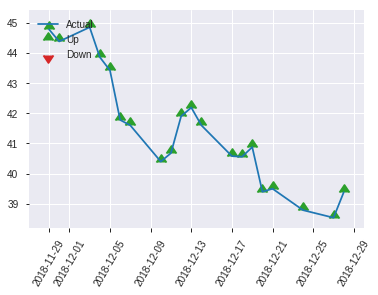


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2577900633388931
RMSE: 0.5077303057124847
LogLoss: 0.7096799252333121
Mean Per-Class Error: 0.46447687014145533
AUC: 0.5028036192175354
pr_auc: 0.48055551180978895
Gini: 0.005607238435070716
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2579498887062073: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    133  1        (133.0/133.0)
1      0    118  0        (0.0/118.0)
Total  0    251  0.5299   (133.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.25795      0.639566  250
max f2                       0.25795      0.816044  250
max f0point5                 0.25795      0.525847  250
max accuracy                 0.577859     0.549801  58
max precision                0.709085     0.6       4
max recall                   0.25795      1         250
max specificity              0.739204     0.992481  0
max absolute_mcc             0.29787      0.116767  247
max min_per_class_accuracy   0.511592     0.496241  125
max mean_per_class_accuracy  0.570976     0.535523  64

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 51.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.713282           0.70904   0.70904            0.333333         0.727418  0.333333                    0.727418            0.00847458      0.00847458                 -29.096   -29.096
    2        0.0239044                   0.7051             1.41808   1.06356            0.666667         0.708413  0.5                         0.717915            0.0169492       0.0254237                  41.8079   6.35593
    3        0.0318725                   0.682824           1.06356   1.06356            0.5              0.684103  0.5                         0.709462            0.00847458      0.0338983                  6.35593   6.35593
    4        0.0438247                   0.66595            1.41808   1.16025            0.666667         0.675507  0.545455                    0.700202            0.0169492       0.0508475                  41.8079   16.0247
    5        0.0517928                   0.660554           0         0.981747           0                0.660906  0.461538                    0.694156            0               0.0508475                  -100      -1.82529
    6        0.103586                    0.612712           1.14537   1.06356            0.538462         0.635815  0.5                         0.664986            0.059322        0.110169                   14.5372   6.35593
    7        0.151394                    0.596459           1.41808   1.17551            0.666667         0.603695  0.552632                    0.645631            0.0677966       0.177966                   41.8079   17.5513
    8        0.203187                    0.586517           0.981747  1.12612            0.461538         0.590909  0.529412                    0.631682            0.0508475       0.228814                   -1.82529  12.6122
    9        0.302789                    0.55272            0.935932  1.06356            0.44             0.572539  0.5                         0.612227            0.0932203       0.322034                   -6.40678  6.35593
    10       0.40239                     0.532208           0.680678  0.968787           0.32             0.540145  0.455446                    0.594385            0.0677966       0.389831                   -31.9322  -3.12133
    11       0.501992                    0.511592           1.1061    0.996032           0.52             0.519223  0.468254                    0.579472            0.110169        0.5                        10.6102   -0.396825
    12       0.601594                    0.493211           1.19119   1.02834            0.56             0.500695  0.483444                    0.566429            0.118644        0.618644                   19.1186   2.83421
    13       0.701195                    0.475721           0.935932  1.01522            0.44             0.483981  0.477273                    0.554718            0.0932203       0.711864                   -6.40678  1.52157
    14       0.800797                    0.458503           0.680678  0.973607           0.32             0.46653   0.457711                    0.543749            0.0677966       0.779661                   -31.9322  -2.63935
    15       0.900398                    0.434053           1.02102   0.978851           0.48             0.446476  0.460177                    0.532989            0.101695        0.881356                   2.10169   -2.11489
    16       1                           0.25795            1.19119   1                  0.56             0.381607  0.47012                     0.517911   

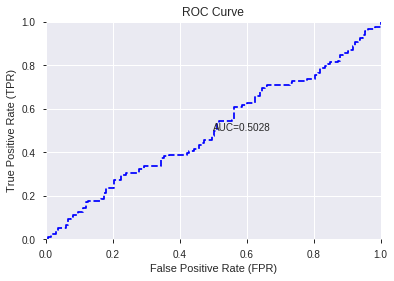

This function is available for GLM models only


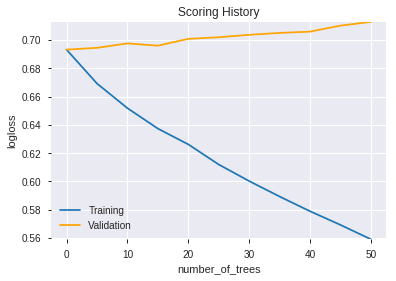

--2019-08-27 17:08:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.109.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.109.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_170656_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_170656_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['COS',
 'DIV',
 'CORREL_24',
 'PLUS_DM_8',
 'MINUS_DM_8',
 'CORREL_12',
 'LINEARREG_ANGLE_8',
 'TAN',
 'BOP',
 'DX_8',
 'DX_30',
 'PLUS_DI_8',
 'SIN',
 'ADXR_8',
 'MINUS_DI_24',
 'HT_PHASOR_quadrature',
 'CORREL_8',
 'ULTOSC',
 'MACDFIX_signal_14',
 'DX_14',
 'BBANDS_lowerband_20_5_5',
 'STOCHF_fastk',
 'HT_DCPERIOD',
 'CORREL_14',
 'STOCHRSI_fastd',
 'Volume',
 'ATR_12',
 'BETA_20',
 'STOCHRSI_fastk',
 'TRANGE',
 'SUB',
 'ADX_8',
 'ADXR_14',
 'ADXR_12',
 'BBANDS_lowerband_8_0_5',
 'day',
 'MFI_24',
 'MFI_14',
 'MACDEXT_hist',
 'MACDFIX_hist_20',
 'STOCH_slowd',
 'BBANDS_lowerband_30_1_2',
 'BBANDS_lowerband_12_2_4',
 'CMO_30',
 'MIDPRICE_24',
 'BETA_30',
 'MACDFIX_hist_14',
 'STOCH_slowk',
 'STDDEV_8',
 'WILLR_8',
 'CORREL_20',
 'Low',
 'MINUS_DM_12',
 'STDDEV_12',
 'ADX_12',
 'HT_PHASOR_inphase',
 'MOM_14',
 'MFI_30',
 'CORREL_30',
 'ADX_14',
 'MIN_30',
 'BBANDS_lowerband_12_2_3',
 'KAMA_24',
 'BBANDS_lowerband_8_6_3',
 'ROC_30',
 'STDDEV_14',
 'MIN_8',
 'CCI_12',
 'LINEARREG_ANGLE_

In [50]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [51]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

523

['MAVP_12_4',
 'BBANDS_upperband_12_4_2',
 'BBANDS_middleband_12_4_2',
 'BBANDS_lowerband_12_4_2',
 'BBANDS_upperband_12_4_3',
 'BBANDS_middleband_12_4_3',
 'BBANDS_lowerband_12_4_3',
 'BBANDS_upperband_12_4_4',
 'BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_upperband_12_5_2',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_12_5_3',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperband_12_5_4',
 'BBANDS_middleband_12_5_4',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowerband_12_5_5',
 'MA_12_6',
 'MAVP_12_6',
 'BBANDS_upperband_12_6_2',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_upperband_12_6_3',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_upperband_12_6_4',
 'BBANDS_middleband_12_6_4',
 'BBANDS_lowerband_12_6_4',

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190827_171118_model_4  0.498216  1.141126              0.481203  0.599398  0.359278
1  DeepLearning_grid_1_AutoML_20190827_171118_model_8  0.495922  0.695590              0.492481  0.501220  0.251221
2  DeepLearning_grid_1_AutoML_20190827_171118_model_9  0.479037  0.702492              0.496241  0.504633  0.254654
3               DeepLearning_1_AutoML_20190827_171118  0.476679  1.019901              0.492481  0.581924  0.338635
4  DeepLearning_grid_1_AutoML_20190827_171118_model_1  0.476201  2.199031              0.489200  0.675873  0.456804
5  DeepLearning_grid_1_AutoML_20190827_171118_model_3  0.471645  0.856731              0.488722  0.557943  0.311301
6  DeepLearning_grid_1_AutoML_20190827_171118_model_6  0.468109  0.706508              0.496241  0.506399  0.256440
7  DeepLearning_grid_1_AutoML_20190827_171118_model_5  0.458519  0.704497              0.496241  0.505605  0.255636
8  DeepLearning_grid_1_AutoML_20190827_171118_model_2  0.447368  0.808780              0.488722  0.545016  0.297043
9  DeepLearning_grid_1_AutoML_20190827_171118_model_7  0.409010  0.898145              0.500000  0.578021  0.334109

variable  relative_importance  scaled_importance  percentage
0          CDLUPSIDEGAP2CROWS             1.000000           1.000000    0.004267
1            CDLABANDONEDBABY             0.997539           0.997539    0.004257
2            CDLSTICKSANDWICH             0.899429           0.899429    0.003838
3             CDLUNIQUE3RIVER             0.890869           0.890869    0.003802
4          CDLMORNINGDOJISTAR             0.890355           0.890355    0.003799
..                        ...                  ...                ...         ...
517                   MA_20_1             0.399009           0.399009    0.001703
518   BBANDS_upperband_14_5_3             0.396711           0.396711    0.001693
519  BBANDS_middleband_12_7_5             0.394841           0.394841    0.001685
520   BBANDS_upperband_30_7_2             0.393770           0.393770    0.001680
521   BBANDS_lowerband_30_6_5             0.392059           0.392059    0.001673

[522 rows x 4 columns]

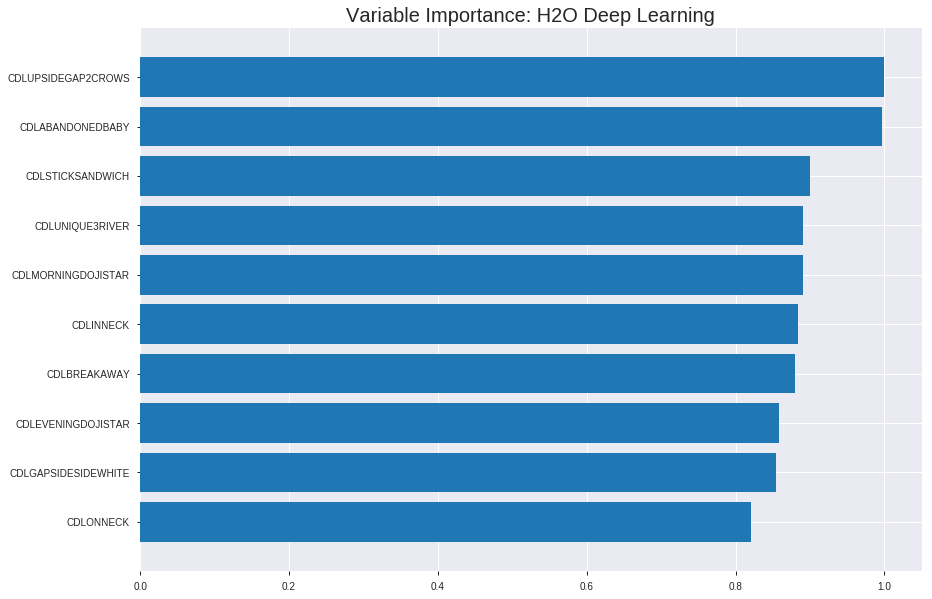

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190827_171118_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1668510750154769
RMSE: 0.4084740812040305
LogLoss: 0.5110011442602237
Mean Per-Class Error: 0.22620185981797858
AUC: 0.8446199983845795
pr_auc: 0.8382688938974578
Gini: 0.6892399967691589
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49754027400206213: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      563  288   0.3384   (288.0/851.0)
1      134  768   0.1486   (134.0/902.0)
Total  697  1056  0.2407   (422.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49754      0.784474  212
max f2                       0.15015      0.863231  333
max f0point5                 0.739609     0.789269  127
max accuracy                 0.673365     0.772961  152
max precision                0.999259     1         0
max recall                   0.032623     1         383
max specificity              0.999259     1         0
max absolute_mcc             0.673365     0.54784   152
max min_per_class_accuracy   0.63755      0.766075  165
max mean_per_class_accuracy  0.673365     0.773798  152

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 57.18 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.996206           1.94346    1.94346            1                0.998254   1                           0.998254            0.0199557       0.0199557                  94.3459   94.3459
    2        0.0205362                   0.994591           1.94346    1.94346            1                0.995436   1                           0.996845            0.0199557       0.0399113                  94.3459   94.3459
    3        0.0302339                   0.991917           1.71482    1.87012            0.882353         0.99295    0.962264                    0.995596            0.0166297       0.056541                   71.4817   87.0121
    4        0.040502                    0.990181           1.83549    1.86134            0.944444         0.991201   0.957746                    0.994481            0.018847        0.075388                   83.5489   86.1341
    5        0.0501997                   0.986887           1.94346    1.8772             1                0.988544   0.965909                    0.993334            0.018847        0.094235                   94.3459   87.7205
    6        0.100399                    0.9718             1.78887    1.83304            0.920455         0.979039   0.943182                    0.986187            0.0898004       0.184035                   78.8866   83.3035
    7        0.150029                    0.951054           1.76475    1.81045            0.908046         0.961839   0.931559                    0.978133            0.0875831       0.271619                   76.475    81.0447
    8        0.200228                    0.923796           1.54593    1.74413            0.795455         0.938666   0.897436                    0.968238            0.0776053       0.349224                   54.5933   74.413
    9        0.300057                    0.858861           1.59919    1.69591            0.822857         0.893087   0.872624                    0.943235            0.159645        0.508869                   59.9189   69.5908
    10       0.399886                    0.7652             1.35487    1.61077            0.697143         0.813652   0.828816                    0.910886            0.135255        0.644124                   35.4869   61.077
    11       0.500285                    0.645975           1.14841    1.51798            0.590909         0.706686   0.781072                    0.869906            0.115299        0.759424                   14.8408   51.7981
    12       0.600114                    0.498049           0.888438   1.41326            0.457143         0.573943   0.727186                    0.820673            0.0886918       0.848115                   -11.1562  41.3257
    13       0.699943                    0.308244           0.610801   1.29881            0.314286         0.405245   0.668297                    0.761423            0.0609756       0.909091                   -38.9199  29.8807
    14       0.799772                    0.170527           0.488641   1.19768            0.251429         0.237187   0.616262                    0.695987            0.0487805       0.957871                   -51.1359  19.7681
    15       0.899601                    0.0667663          0.322059   1.10051            0.165714         0.120273   0.566265                    0.6321              0.0321508       0.990022                   -67.7941  10.0513
    16       1                           0.000151372        0.0993814  1                  0.0511364        0.0314798  0.514546   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.34493891917711283
RMSE: 0.5873150084725511
LogLoss: 1.0596905248842776
Mean Per-Class Error: 0.48238707003729797
AUC: 0.5024785616372852
pr_auc: 0.510405019868287
Gini: 0.00495712327457043
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03232380644976768: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   233  0.9433   (233.0/247.0)
1      7    247  0.0276   (7.0/254.0)
Total  21   480  0.479    (240.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0323238    0.673025   383
max f2                       0.000109409  0.837179   399
max f0point5                 0.0323238    0.568077   383
max accuracy                 0.0323238    0.520958   383
max precision                0.999206     1          0
max recall                   0.000109409  1          399
max specificity              0.999206     1          0
max absolute_mcc             0.0323238    0.0726512  383
max min_per_class_accuracy   0.480566     0.5        203
max mean_per_class_accuracy  0.363349     0.517613   244

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 50.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.992664           1.31496   1.31496            0.666667         0.996367   0.666667                    0.996367            0.015748        0.015748                   31.4961   31.4961
    2        0.0219561                   0.986737           1.18346   1.25519            0.6              0.988325   0.636364                    0.992711            0.011811        0.0275591                  18.3465   25.519
    3        0.0319361                   0.983877           0.788976  1.1095             0.4              0.985229   0.5625                      0.990373            0.00787402      0.0354331                  -21.1024  10.9498
    4        0.0419162                   0.975534           0.788976  1.03318            0.4              0.978316   0.52381                     0.987502            0.00787402      0.0433071                  -21.1024  3.31834
    5        0.0518962                   0.968631           0.394488  0.910357           0.2              0.97056    0.461538                    0.984244            0.00393701      0.0472441                  -60.5512  -8.96426
    6        0.101796                    0.940936           1.18346   1.04423            0.6              0.954025   0.529412                    0.969431            0.0590551       0.106299                   18.3465   4.42334
    7        0.151697                    0.893473           0.867874  0.98622            0.44             0.919332   0.5                         0.952951            0.0433071       0.149606                   -13.2126  -1.37795
    8        0.201597                    0.836557           0.946772  0.976456           0.48             0.864072   0.49505                     0.930951            0.0472441       0.19685                    -5.32283  -2.35441
    9        0.301397                    0.742707           0.98622   0.979689           0.5              0.782286   0.496689                    0.881724            0.0984252       0.295276                   -1.37795  -2.03108
    10       0.401198                    0.612047           0.946772  0.971501           0.48             0.685806   0.492537                    0.832989            0.0944882       0.389764                   -5.32283  -2.84992
    11       0.500998                    0.468197           1.10457   0.998008           0.56             0.538961   0.505976                    0.774417            0.110236        0.5                        10.4567   -0.199203
    12       0.600798                    0.357758           1.18346   1.02881            0.6              0.405494   0.521595                    0.713134            0.11811         0.61811                    18.3465   2.88147
    13       0.700599                    0.282738           0.828425  1.00027            0.42             0.318871   0.507123                    0.656971            0.0826772       0.700787                   -17.1575  0.0269197
    14       0.800399                    0.186617           1.14402   1.01819            0.58             0.231125   0.516209                    0.603873            0.114173        0.814961                   14.4016   1.81927
    15       0.9002                      0.0896015          0.946772  1.01027            0.48             0.13811    0.512195                    0.552237            0.0944882       0.909449                   -5.32283  1.02746
    16       1                           0.000106905        0.907323  1                  0.46             0.0445425  0.506986           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:14:20  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-27 17:14:24  5.868 sec         189 obs/sec       0.441529  1             774        0.659675         3.33039             -0.74216       0.551282        0.370646           1.18767          0.485454                         0.655842           2.85548               -0.720853        0.52253           0.49768              1.6437             0.473054
    2019-08-27 17:14:45  26.403 sec        203 obs/sec       2.6583    6             4660       0.614756         3.71301             -0.512978      0.566701        0.346003           1.29564          0.464917                         0.634409           2.66325               -0.610215        0.545666          0.490424             1.31496            0.487026
    2019-08-27 17:15:03  44.443 sec        218 obs/sec       4.87336   11            8543       0.629615         1.79274             -0.587002      0.634759        0.585816           1.0797           0.414718                         0.66086            1.85979               -0.747283        0.454374          0.49026              0.98622            0.493014
    2019-08-27 17:15:21  1 min  2.586 sec  237 obs/sec       7.52539   17            13192      0.587994         1.29575             -0.384121      0.678288        0.628957           1.61955          0.363948                         0.6457             1.51151               -0.668039        0.474306          0.510228             0.98622            0.493014
    2019-08-27 17:15:40  1 min 21.559 sec  254 obs/sec       10.5864   24            18558      0.509851         0.869349            -0.0406718     0.70243         0.727629           1.94346          0.416999                         0.648724           1.88824               -0.683702        0.552058          0.520503             0.65748            0.493014
    2019-08-27 17:15:58  1 min 39.983 sec  266 obs/sec       13.6406   31            23912      0.455283         0.613133            0.170166       0.763855        0.762272           1.83549          0.345693                         0.591548           1.06214               -0.39999         0.47311           0.490677             1.31496            0.489022
    2019-08-27 17:16:17  1 min 58.477 sec  275 obs/sec       16.7245   38            29318      0.472515         0.697366            0.106162       0.753446        0.733129           1.72752          0.32915                          0.595978           1.11993               -0.421039        0.508528          0.51198              1.6437             0.491018
    2019-08-27 17:16:35  2 min 16.548 sec  283 obs/sec       19.8083   45            34724      0.433987         0.569412            0.245984       0.806659        0.809033           1.94346          0.301768                         0.624454           1.41126               -0.560077        0.516386          0.507876             1.31496            0.493014
    2019-08-27 17:16:54

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLUPSIDEGAP2CROWS        1.0                    1.0                  0.004267304197351438
CDLABANDONEDBABY          0.9975388646125793     0.9975388646125793   0.004256801783982447
CDLSTICKSANDWICH          0.8994287848472595     0.8994287848472595   0.0038381362287974135
CDLUNIQUE3RIVER           0.8908685445785522     0.8908685445785522   0.003801607079568422
CDLMORNINGDOJISTAR        0.8903548121452332     0.8903548121452332   0.003799414826999404
---                       ---                    ---                  ---
MA_20_1                   0.3990093767642975     0.3990093767642975   0.0017026943882488678
BBANDS_upperband_14_5_3   0.3967112600803375     0.3967112600803375   0.001692887625277402
BBANDS_middleband_12_7_5  0.39484113454818726    0.39484113454818726  0.0016849072307444832
BBANDS_upperband_30_7_2   0.39376986026763916    0.39376986026763916  0.0016803357775105857
BBANDS_lowerband_30_6_5   0.39205917716026306    0.39205917716026306  0.0016730357723061414


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6483516483516484)

('auc', 0.49821587867975026)

('logloss', 1.1411258187486222)

('mean_per_class_error', 0.47722059385752513)

('rmse', 0.5993980218982461)

('mse', 0.35927798865553034)

deeplearning prediction progress: |███████████████████████████████████████| 100%


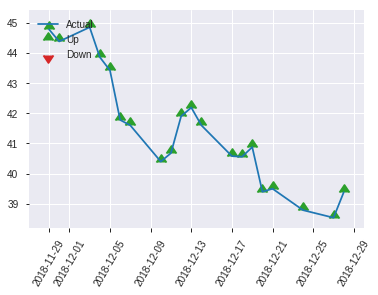


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.35927798865553034
RMSE: 0.5993980218982461
LogLoss: 1.1411258187486222
Mean Per-Class Error: 0.47722059385752513
AUC: 0.49821587867975026
pr_auc: 0.46491968024974134
Gini: -0.003568242640499486
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.008024817860460456: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      5    128  0.9624   (128.0/133.0)
1      0    118  0        (0.0/118.0)
Total  5    246  0.51     (128.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00802482   0.648352  245
max f2                       0.00802482   0.821727  245
max f0point5                 0.00802482   0.53539   245
max accuracy                 0.982896     0.537849  9
max precision                0.982896     0.6       9
max recall                   0.00802482   1         245
max specificity              0.999702     0.992481  0
max absolute_mcc             0.00802482   0.134287  245
max min_per_class_accuracy   0.620212     0.474576  118
max mean_per_class_accuracy  0.293047     0.522779  178

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 54.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.993714           0         0                  0                0.996384  0                           0.996384            0               0                          -100      -100
    2        0.0239044                   0.991778           1.41808   0.70904            0.666667         0.992755  0.333333                    0.994569            0.0169492       0.0169492                  41.8079   -29.096
    3        0.0318725                   0.984774           2.12712   1.06356            1                0.98587   0.5                         0.992395            0.0169492       0.0338983                  112.712   6.35593
    4        0.0438247                   0.974257           1.41808   1.16025            0.666667         0.980539  0.545455                    0.989161            0.0169492       0.0508475                  41.8079   16.0247
    5        0.0517928                   0.970459           1.06356   1.14537            0.5              0.971874  0.538462                    0.986502            0.00847458      0.059322                   6.35593   14.5372
    6        0.103586                    0.957369           0.981747  1.06356            0.461538         0.964799  0.5                         0.97565             0.0508475       0.110169                   -1.82529  6.35593
    7        0.151394                    0.918902           0.53178   0.895629           0.25             0.938041  0.421053                    0.963774            0.0254237       0.135593                   -46.822   -10.4371
    8        0.203187                    0.900479           1.47262   1.04271            0.692308         0.909715  0.490196                    0.949994            0.0762712       0.211864                   47.2621   4.27052
    9        0.302789                    0.77093            0.595593  0.895629           0.28             0.840261  0.421053                    0.913897            0.059322        0.271186                   -40.4407  -10.4371
    10       0.40239                     0.697504           1.36136   1.01091            0.64             0.741322  0.475248                    0.871181            0.135593        0.40678                    36.1356   1.09079
    11       0.501992                    0.582385           0.680678  0.945386           0.32             0.642568  0.444444                    0.825821            0.0677966       0.474576                   -31.9322  -5.46139
    12       0.601594                    0.449743           1.19119   0.986081           0.56             0.513969  0.463576                    0.77419             0.118644        0.59322                    19.1186   -1.39185
    13       0.701195                    0.31913            1.27627   1.0273             0.6              0.388657  0.482955                    0.719427            0.127119        0.720339                   27.6271   2.73016
    14       0.800797                    0.184057           0.850847  1.00535            0.4              0.243456  0.472637                    0.660226            0.0847458       0.805085                   -14.9153  0.535458
    15       0.900398                    0.0726661          1.02102   1.00709            0.48             0.125899  0.473451                    0.601119            0.101695        0.90678                    2.10169   0.708715
    16       1                           0.000420503        0.935932  1                  0.44             0.027479  0.47012                     0.543984      

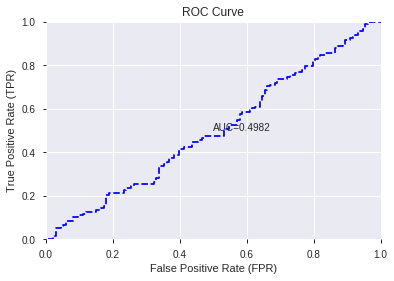

This function is available for GLM models only


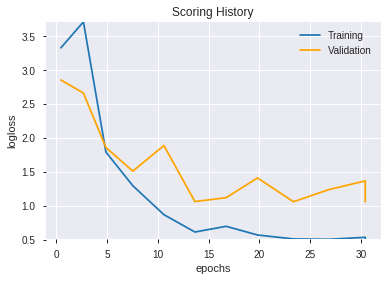

--2019-08-27 17:29:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.81.152
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.81.152|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190827_171118_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190827_171118_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLUPSIDEGAP2CROWS',
 'CDLABANDONEDBABY',
 'CDLSTICKSANDWICH',
 'CDLUNIQUE3RIVER',
 'CDLMORNINGDOJISTAR',
 'CDLINNECK',
 'CDLBREAKAWAY',
 'CDLEVENINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLONNECK',
 'CDLPIERCING',
 'CDLTAKURI',
 'CDLMORNINGSTAR',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CDLSHOOTINGSTAR',
 'CDLHOMINGPIGEON',
 'CDLHANGINGMAN',
 'CDLEVENINGSTAR',
 'CDLGRAVESTONEDOJI',
 'CDLXSIDEGAP3METHODS',
 'CDLHAMMER',
 'CDLINVERTEDHAMMER',
 'CDL3INSIDE',
 'CDLDARKCLOUDCOVER',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI',
 'TRANGE',
 'BOP',
 'CORREL_12',
 'CDLDOJI',
 'CDLSHORTLINE',
 'CORREL_20',
 'CORREL_24',
 'HT_DCPERIOD',
 'CDLSPINNINGTOP',
 'BETA_20',
 'aroondown_20',
 'aroonup_8',
 'BETA_24',
 'ULTOSC',
 'CDLHIGHWAVE',
 'HT_PHASOR_quadrature',
 'ADOSC',
 'STOCHRSI_fastk',
 'AROONOSC_8',
 'BETA_8',
 'ADX_24',
 'aroondown_8',
 'HT_TRENDMODE',
 'CDLHIKKAKE',
 'CDLLONGLINE',
 'CDLHARAMI',
 'CDL3OUTSIDE',
 'aroonup_12',
 'BETA_14',
 'MFI_30',
 'CDLCLOSINGMARUBOZU',
 'aroondown_24',
 'a

In [52]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190827_173051_model_1  0.445011  0.697992              0.485918  0.502417  0.252423

variable  relative_importance  scaled_importance  percentage
0                   CORREL_12             0.008318           1.000000    0.014454
1          CDLMORNINGDOJISTAR             0.007978           0.959105    0.013863
2                CDLBREAKAWAY             0.006648           0.799269    0.011552
3                 CDLLONGLINE             0.005643           0.678416    0.009806
4            CDLDRAGONFLYDOJI             0.005616           0.675201    0.009759
..                        ...                  ...                ...         ...
517   BBANDS_lowerband_20_2_3             0.000013           0.001527    0.000022
518  BBANDS_middleband_20_2_3             0.000010           0.001198    0.000017
519   BBANDS_lowerband_24_0_5             0.000009           0.001118    0.000016
520   BBANDS_upperband_14_1_4             0.000005           0.000639    0.000009
521  BBANDS_middleband_20_2_2             0.000004           0.000429    0.000006

[522 rows x 4 columns]

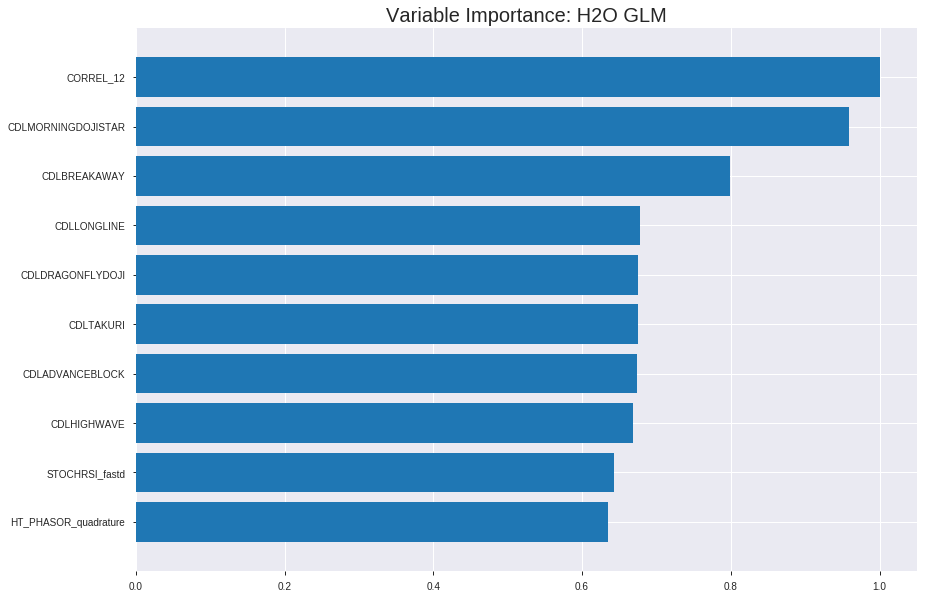

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190827_173051_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24712534143842446
RMSE: 0.49711702992195356
LogLoss: 0.6873812214790818
Null degrees of freedom: 1752
Residual degrees of freedom: 1230
Null deviance: 2428.6900635089887
Residual deviance: 2409.9585625056607
AIC: 3455.9585625056607
AUC: 0.5759019648203105
pr_auc: 0.5796309678272815
Gini: 0.15180392964062106
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46935537294983504: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      23   828   0.973    (828.0/851.0)
1      5    897   0.0055   (5.0/902.0)
Total  28   1725  0.4752   (833.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.469355     0.682908  379
max f2                       0.464537     0.842686  386
max f0point5                 0.49614      0.590267  295
max accuracy                 0.49614      0.563605  295
max precision                0.592172     1         0
max recall                   0.460407     1         390
max specificity              0.592172     1         0
max absolute_mcc             0.49614      0.133908  295
max min_per_class_accuracy   0.512167     0.546416  217
max mean_per_class_accuracy  0.49614      0.555512  295

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.575088           1.0797    1.0797             0.555556         0.582207  0.555556                    0.582207            0.0110865       0.0110865                  7.96994   7.96994
    2        0.0205362                   0.567136           1.40361   1.24165            0.722222         0.570013  0.638889                    0.57611             0.0144124       0.0254989                  40.3609   24.1654
    3        0.0302339                   0.562087           1.02889   1.17341            0.529412         0.565035  0.603774                    0.572558            0.00997783      0.0354767                  2.889     17.3409
    4        0.040502                    0.558972           1.40361   1.23177            0.722222         0.560311  0.633803                    0.569453            0.0144124       0.0498891                  40.3609   23.177
    5        0.0501997                   0.556802           1.25753   1.23675            0.647059         0.557928  0.636364                    0.567227            0.0121951       0.0620843                  25.7532   23.6747
    6        0.100399                    0.545753           1.28092   1.25883            0.659091         0.550619  0.647727                    0.558923            0.0643016       0.126386                   28.0916   25.8831
    7        0.150029                    0.539421           1.11693   1.21189            0.574713         0.542151  0.623574                    0.553375            0.0554324       0.181818                   11.693    21.1891
    8        0.200228                    0.534126           1.12632   1.19044            0.579545         0.536322  0.612536                    0.549099            0.056541        0.238359                   12.6323   19.0438
    9        0.300057                    0.526802           1.08834   1.15647            0.56             0.530241  0.595057                    0.542825            0.108647        0.347007                   8.8337    15.6469
    10       0.399886                    0.519501           0.943966  1.10342            0.485714         0.522936  0.56776                     0.53786             0.094235        0.441242                   -5.60342  10.3419
    11       0.500285                    0.512204           1.04903   1.0925             0.539773         0.516054  0.562144                    0.533484            0.105322        0.546563                   4.90262   9.25032
    12       0.600114                    0.506313           0.977282  1.07334            0.502857         0.509328  0.552281                    0.529466            0.097561        0.644124                   -2.27178  7.33362
    13       0.699943                    0.500217           1.08834   1.07548            0.56             0.503175  0.553382                    0.525716            0.108647        0.752772                   8.8337    7.54757
    14       0.799772                    0.494656           0.988388  1.06461            0.508571         0.497675  0.547789                    0.522216            0.0986696       0.851441                   -1.16123  6.46052
    15       0.899601                    0.486944           0.732962  1.0278             0.377143         0.491036  0.528852                    0.518756            0.0731707       0.924612                   -26.7038  2.78027
    16       1                           0.437378           0.750882  1                  0.386364         0.47683   0.514546                    0.514546          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24899967320790606
RMSE: 0.49899867054723307
LogLoss: 0.6911455817978357
Null degrees of freedom: 500
Residual degrees of freedom: -22
Null deviance: 694.5502849840166
Residual deviance: 692.5278729614314
AIC: 1738.5278729614315
AUC: 0.5400873473811725
pr_auc: 0.5412058580892157
Gini: 0.08017469476234496
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45923465657114576: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    243  0.9838   (243.0/247.0)
1      1    253  0.0039   (1.0/254.0)
Total  5    496  0.487    (244.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459235     0.674667  394
max f2                       0.41884      0.837179  399
max f0point5                 0.491591     0.570891  261
max accuracy                 0.491591     0.550898  261
max precision                0.574965     1         0
max recall                   0.41884      1         399
max specificity              0.574965     1         0
max absolute_mcc             0.491591     0.103138  261
max min_per_class_accuracy   0.500643     0.535433  198
max mean_per_class_accuracy  0.491591     0.548551  261

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 50.22 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.564851           1.31496   1.31496            0.666667         0.571283  0.666667                    0.571283            0.015748        0.015748                   31.4961   31.4961
    2        0.0219561                   0.562105           1.57795   1.4345             0.8              0.562615  0.727273                    0.567343            0.015748        0.0314961                  57.7953   43.4503
    3        0.0319361                   0.555334           0.394488  1.1095             0.2              0.557873  0.5625                      0.564384            0.00393701      0.0354331                  -60.5512  10.9498
    4        0.0419162                   0.551421           1.57795   1.22103            0.8              0.552111  0.619048                    0.561462            0.015748        0.0511811                  57.7953   22.1035
    5        0.0518962                   0.549203           0.788976  1.13795            0.4              0.550044  0.576923                    0.559266            0.00787402      0.0590551                  -21.1024  13.7947
    6        0.101796                    0.536107           0.946772  1.04423            0.48             0.541654  0.529412                    0.550633            0.0472441       0.106299                   -5.32283  4.42334
    7        0.151697                    0.527703           0.867874  0.98622            0.44             0.531745  0.5                         0.54442             0.0433071       0.149606                   -13.2126  -1.37795
    8        0.201597                    0.521827           1.42016   1.09363            0.72             0.524978  0.554455                    0.539607            0.0708661       0.220472                   42.0157   9.36306
    9        0.301397                    0.512889           1.14402   1.11031            0.58             0.516731  0.562914                    0.532033            0.114173        0.334646                   14.4016   11.0314
    10       0.401198                    0.506093           0.98622   1.07945            0.5              0.508968  0.547264                    0.526295            0.0984252       0.433071                   -1.37795  7.94453
    11       0.500998                    0.500201           1.06512   1.07659            0.54             0.50299   0.545817                    0.521653            0.106299        0.53937                    6.51181   7.65913
    12       0.600798                    0.495007           0.828425  1.03537            0.42             0.497586  0.524917                    0.517655            0.0826772       0.622047                   -17.1575  3.53677
    13       0.700599                    0.488463           1.10457   1.04523            0.56             0.492322  0.529915                    0.514046            0.110236        0.732283                   10.4567   4.52251
    14       0.800399                    0.480004           0.788976  1.01327            0.4              0.484053  0.513716                    0.510306            0.0787402       0.811024                   -21.1024  1.32739
    15       0.9002                      0.471161           0.867874  0.997154           0.44             0.475863  0.505543                    0.506488            0.0866142       0.897638                   -13.2126  -0.284582
    16       1                           0.41884            1.02567   1                  0.52             0.46399   0.506986                    0.502247      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-27 17:30:52  0.000 sec   2            2.8       523           1.37476           1.38229
    2019-08-27 17:30:53  0.534 sec   4            2         523           1.37243           1.38259
    2019-08-27 17:30:54  1.180 sec   6            1.5       523           1.36974           1.38279
    2019-08-27 17:30:54  1.756 sec   8            1.1       523           1.36666           1.38318
    2019-08-27 17:30:55  2.343 sec   10           0.78      523           1.3632            1.38377
    2019-08-27 17:30:55  3.000 sec   12           0.57      523           1.3594            1.38467

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5577689243027888)

('F1', 0.6426592797783933)

('auc', 0.4450108321651587)

('logloss', 0.6979921963315648)

('mean_per_class_error', 0.4655600866573213)

('rmse', 0.5024169200425714)

('mse', 0.2524227615450636)

glm prediction progress: |████████████████████████████████████████████████| 100%


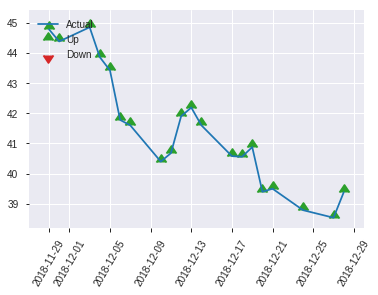


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2524227615450636
RMSE: 0.5024169200425714
LogLoss: 0.6979921963315648
Null degrees of freedom: 250
Residual degrees of freedom: -272
Null deviance: 349.04545729516275
Residual deviance: 350.39208255844557
AIC: 1396.3920825584455
AUC: 0.4450108321651587
pr_auc: 0.4738571360481886
Gini: -0.10997833566968263
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46169511762779514: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    127  0.9549   (127.0/133.0)
1      2    116  0.0169   (2.0/118.0)
Total  8    243  0.5139   (129.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.461695     0.642659  242
max f2                       0.443497     0.816044  250
max f0point5                 0.461695     0.53211   242
max accuracy                 0.54544      0.557769  10
max precision                0.56492      1         0
max recall                   0.443497     1         250
max specificity              0.56492      1         0
max absolute_mcc             0.485239     0.17535   193
max min_per_class_accuracy   0.501081     0.443609  126
max mean_per_class_accuracy  0.536635     0.53444   26

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 50.34 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.557092           1.41808   1.41808            0.666667         0.560274  0.666667                    0.560274            0.0169492       0.0169492                  41.8079   41.8079
    2        0.0239044                   0.554022           1.41808   1.41808            0.666667         0.555487  0.666667                    0.557881            0.0169492       0.0338983                  41.8079   41.8079
    3        0.0318725                   0.550266           2.12712   1.59534            1                0.552888  0.75                        0.556632            0.0169492       0.0508475                  112.712   59.5339
    4        0.0438247                   0.54544            2.12712   1.74037            1                0.546991  0.818182                    0.554003            0.0254237       0.0762712                  112.712   74.037
    5        0.0517928                   0.544207           0         1.47262            0                0.54464   0.692308                    0.552562            0               0.0762712                  -100      47.2621
    6        0.103586                    0.53675            1.14537   1.309              0.538462         0.539437  0.615385                    0.546               0.059322        0.135593                   14.5372   30.8996
    7        0.151394                    0.533994           0.53178   1.06356            0.25             0.535279  0.5                         0.542614            0.0254237       0.161017                   -46.822   6.35593
    8        0.203187                    0.528487           0.654498  0.959289           0.307692         0.531417  0.45098                     0.53976             0.0338983       0.194915                   -34.5502  -4.07112
    9        0.302789                    0.51419            0.850847  0.923617           0.4              0.520387  0.434211                    0.533387            0.0847458       0.279661                   -14.9153  -7.63827
    10       0.40239                     0.507397           0.850847  0.905605           0.4              0.510865  0.425743                    0.527813            0.0847458       0.364407                   -14.9153  -9.4395
    11       0.501992                    0.501661           0.765763  0.877858           0.36             0.504806  0.412698                    0.523248            0.0762712       0.440678                   -23.4237  -12.2142
    12       0.601594                    0.493699           1.02102   0.90156            0.48             0.497148  0.423841                    0.518926            0.101695        0.542373                   2.10169   -9.84398
    13       0.701195                    0.489815           0.935932  0.906443           0.44             0.491676  0.426136                    0.515056            0.0932203       0.635593                   -6.40678  -9.35574
    14       0.800797                    0.483093           1.1061    0.931276           0.52             0.4862    0.437811                    0.511467            0.110169        0.745763                   10.6102   -6.87242
    15       0.900398                    0.473331           1.19119   0.960027           0.56             0.477603  0.451327                    0.507721            0.118644        0.864407                   19.1186   -3.9973
    16       1                           0.443497           1.36136   1                  0.64             0.464222  0.47012                     0.503388    

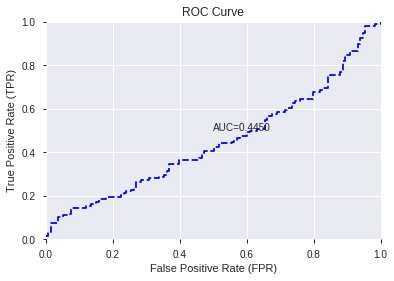

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


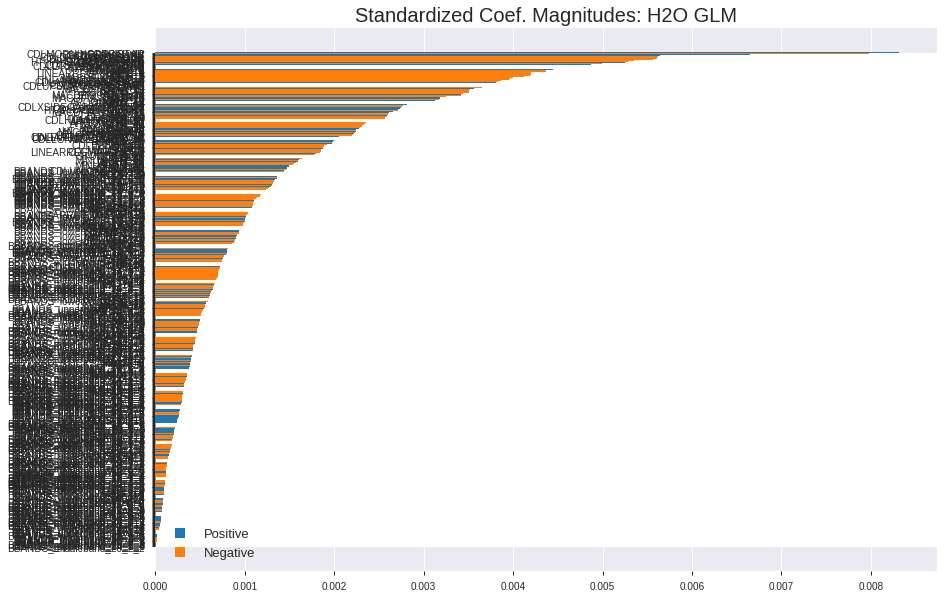

'log_likelihood'
--2019-08-27 17:31:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.115.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.115.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190827_173051_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190827_173051_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CORREL_12',
 'CDLMORNINGDOJISTAR',
 'CDLBREAKAWAY',
 'CDLLONGLINE',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLADVANCEBLOCK',
 'CDLHIGHWAVE',
 'STOCHRSI_fastd',
 'HT_PHASOR_quadrature',
 'CDLDOJISTAR',
 'CDLONNECK',
 'CDLSHOOTINGSTAR',
 'CDLGRAVESTONEDOJI',
 'STOCH_slowd',
 'MACDFIX_hist_8',
 'CDL3INSIDE',
 'aroondown_8',
 'aroonup_12',
 'MFI_14',
 'LINEARREG_SLOPE_8',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'MACDFIX_hist_12',
 'MOM_8',
 'LINEARREG_ANGLE_8',
 'MACDFIX_hist_14',
 'AROONOSC_8',
 'CDLABANDONEDBABY',
 'CORREL_14',
 'STOCHRSI_fastk',
 'BOP',
 'CDLMORNINGSTAR',
 'CDLUPSIDEGAP2CROWS',
 'BETA_24',
 'MACDFIX_hist_20',
 'TRANGE',
 'ROC_14',
 'ROCR100_14',
 'ROCR_14',
 'ROCP_14',
 'STOCHF_fastd',
 'MACDFIX_signal_24',
 'NATR_8',
 'ATR_8',
 'MACDFIX_signal_20',
 'TRIX_14',
 'NATR_12',
 'aroonup_14',
 'AROONOSC_12',
 'NATR_14',
 'MOM_14',
 'ATR_14',
 'ADX_24',
 'aroondown_30',
 'CDLXSIDEGAP3METHODS',
 'STDDEV_12',
 'CDLEVENINGSTAR',
 'HT_PHASOR_inphase',
 'PLUS_DM_8',
 'MACDF

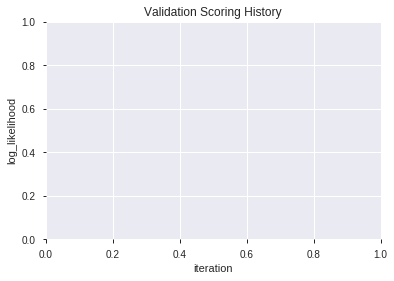

In [53]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190827_173213_model_4  0.498280  0.704246              0.492481  0.505349  0.255377
1  XGBoost_grid_1_AutoML_20190827_173213_model_1  0.489040  0.711096              0.485440  0.508450  0.258521
2  XGBoost_grid_1_AutoML_20190827_173213_model_6  0.473111  0.717257              0.500000  0.511356  0.261485
3  XGBoost_grid_1_AutoML_20190827_173213_model_2  0.470753  0.711653              0.489200  0.508932  0.259012
4               XGBoost_2_AutoML_20190827_173213  0.464764  0.715923              0.500000  0.510891  0.261009
5  XGBoost_grid_1_AutoML_20190827_173213_model_3  0.464063  0.730691              0.492481  0.516945  0.267233
6               XGBoost_3_AutoML_20190827_173213  0.463744  0.714640              0.500000  0.510232  0.260337
7  XGBoost_grid_1_AutoML_20190827_173213_model_5  0.458009  0.761479              0.496241  0.529836  0.280726
8               XGBoost_1_AutoML_20190827_173213  0.446476  0.743376              0.492959  0.523168  0.273704
9  XGBoost_grid_1_AutoML_20190827_173213_model_7  0.425385  0.751649              0.492481  0.527168  0.277906

variable  relative_importance  scaled_importance  percentage
0                     TRANGE            89.125168           1.000000    0.027140
1                  CORREL_24            88.731262           0.995580    0.027020
2                     MFI_14            75.492004           0.847034    0.022988
3       HT_PHASOR_quadrature            74.706604           0.838221    0.022749
4             STOCHRSI_fastd            72.950584           0.818518    0.022215
..                       ...                  ...                ...         ...
162                   MFI_30             5.427348           0.060896    0.001653
163  BBANDS_upperband_30_7_2             5.005597           0.056164    0.001524
164                aroonup_8             4.820587           0.054088    0.001468
165       LINEARREG_ANGLE_20             4.757751           0.053383    0.001449
166  BBANDS_lowerband_30_7_3             1.244039           0.013958    0.000379

[167 rows x 4 columns]

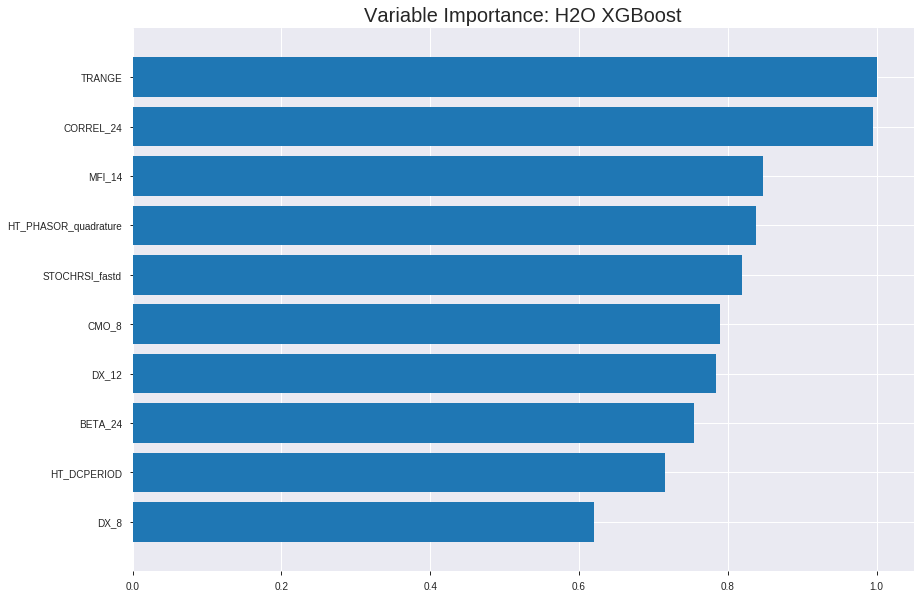

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190827_173213_model_4


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21412178033771812
RMSE: 0.4627329471063392
LogLoss: 0.6201828433678219
Mean Per-Class Error: 0.26074254626746673
AUC: 0.8165435994174064
pr_auc: 0.822966894471821
Gini: 0.6330871988348128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49389101068178815: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      534  317   0.3725   (317.0/851.0)
1      143  759   0.1585   (143.0/902.0)
Total  677  1076  0.2624   (460.0/1753.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.493891     0.767442  230
max f2                       0.434737     0.865062  303
max f0point5                 0.529288     0.751618  176
max accuracy                 0.499482     0.741586  221
max precision                0.706817     1         0
max recall                   0.387441     1         355
max specificity              0.706817     1         0
max absolute_mcc             0.499482     0.485721  221
max min_per_class_accuracy   0.514813     0.730599  196
max mean_per_class_accuracy  0.499482     0.739257  221

Gains/Lift Table: Avg response rate: 51.45 %, avg score: 51.41 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102681                   0.669467           1.94346    1.94346            1                0.680516  1                           0.680516            0.0199557       0.0199557                  94.3459   94.3459
    2        0.0205362                   0.658657           1.94346    1.94346            1                0.662873  1                           0.671695            0.0199557       0.0399113                  94.3459   94.3459
    3        0.0302339                   0.645559           1.82914    1.90679            0.941176         0.651703  0.981132                    0.665282            0.0177384       0.0576497                  82.9138   90.679
    4        0.040502                    0.638598           1.94346    1.91609            1                0.64124   0.985915                    0.659187            0.0199557       0.0776053                  94.3459   91.6086
    5        0.0501997                   0.632417           1.82914    1.89929            0.941176         0.635361  0.977273                    0.654584            0.0177384       0.0953437                  82.9138   89.9289
    6        0.100399                    0.610024           1.85512    1.8772             0.954545         0.619939  0.965909                    0.637262            0.0931264       0.18847                    85.512    87.7205
    7        0.150029                    0.597102           1.60838    1.78828            0.827586         0.603173  0.920152                    0.625985            0.0798226       0.268293                   60.838    78.8278
    8        0.200228                    0.583421           1.5901     1.73859            0.818182         0.590589  0.894587                    0.617111            0.0798226       0.348115                   59.0103   73.8593
    9        0.300057                    0.559526           1.34376    1.60723            0.691429         0.571407  0.826996                    0.601905            0.134146        0.482262                   34.3763   60.7233
    10       0.399886                    0.538613           1.28824    1.5276             0.662857         0.549055  0.78602                     0.588712            0.128603        0.610865                   28.8236   52.7598
    11       0.500285                    0.514982           1.12632    1.44707            0.579545         0.526961  0.744584                    0.576319            0.113082        0.723947                   12.6323   44.7068
    12       0.600114                    0.496404           1.03281    1.37816            0.531429         0.5064    0.709125                    0.564688            0.103104        0.827051                   3.28096   37.8156
    13       0.699943                    0.472196           0.699645   1.28138            0.36             0.484569  0.659332                    0.553261            0.0698448       0.896896                   -30.0355  28.1384
    14       0.799772                    0.44563            0.566379   1.19214            0.291429         0.459321  0.613409                    0.541535            0.056541        0.953437                   -43.3621  19.2136
    15       0.899601                    0.412177           0.366481   1.10051            0.188571         0.428804  0.566265                    0.529026            0.0365854       0.990022                   -63.3519  10.0513
    16       1                           0.278731           0.0993814  1                  0.0511364        0.380391  0.514546                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24998858920164618
RMSE: 0.4999885890714369
LogLoss: 0.693212885685051
Mean Per-Class Error: 0.4605263157894737
AUC: 0.5402387707609424
pr_auc: 0.5284342497958515
Gini: 0.0804775415218848
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37718161940574646: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   232  0.9393   (232.0/247.0)
1      2    252  0.0079   (2.0/254.0)
Total  17   484  0.4671   (234.0/501.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.377182     0.682927  383
max f2                       0.377182     0.84      383
max f0point5                 0.39839      0.578947  360
max accuracy                 0.421382     0.542914  334
max precision                0.665118     0.666667  5
max recall                   0.345217     1         396
max specificity              0.720203     0.995951  0
max absolute_mcc             0.377182     0.145949  383
max min_per_class_accuracy   0.499547     0.527559  194
max mean_per_class_accuracy  0.509957     0.539474  178

Gains/Lift Table: Avg response rate: 50.70 %, avg score: 49.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.011976                    0.665118           1.31496   1.31496            0.666667         0.680786  0.666667                    0.680786            0.015748        0.015748                   31.4961   31.4961
    2        0.0219561                   0.643982           0.788976  1.07588            0.4              0.648781  0.545455                    0.666238            0.00787402      0.023622                   -21.1024  7.58769
    3        0.0319361                   0.63632            0.788976  0.98622            0.4              0.638761  0.5                         0.657652            0.00787402      0.0314961                  -21.1024  -1.37795
    4        0.0419162                   0.629214           0.788976  0.939258           0.4              0.631823  0.47619                     0.651502            0.00787402      0.0393701                  -21.1024  -6.07424
    5        0.0518962                   0.626208           1.18346   0.98622            0.6              0.627376  0.5                         0.646862            0.011811        0.0511811                  18.3465   -1.37795
    6        0.101796                    0.595094           0.867874  0.928208           0.44             0.608238  0.470588                    0.627929            0.0433071       0.0944882                  -13.2126  -7.17925
    7        0.151697                    0.574736           1.18346   1.01217            0.6              0.58541   0.513158                    0.613943            0.0590551       0.153543                   18.3465   1.21736
    8        0.201597                    0.559691           1.42016   1.11316            0.72             0.566744  0.564356                    0.60226             0.0708661       0.224409                   42.0157   11.316
    9        0.301397                    0.536474           1.02567   1.08419            0.52             0.548963  0.549669                    0.584612            0.102362        0.326772                   2.56693   8.41894
    10       0.401198                    0.520189           0.946772  1.05001            0.48             0.528171  0.532338                    0.570572            0.0944882       0.42126                    -5.32283  5.00059
    11       0.500998                    0.499277           1.06512   1.05302            0.54             0.511366  0.533865                    0.558778            0.106299        0.527559                   6.51181   5.30163
    12       0.600798                    0.47785            1.02567   1.04847            0.52             0.488637  0.531561                    0.547126            0.102362        0.629921                   2.56693   4.84736
    13       0.700599                    0.458212           0.828425  1.01713            0.42             0.467769  0.51567                     0.535822            0.0826772       0.712598                   -17.1575  1.71277
    14       0.800399                    0.43558            1.02567   1.01819            0.52             0.446567  0.516209                    0.524693            0.102362        0.814961                   2.56693   1.81927
    15       0.9002                      0.40275            1.14402   1.03214            0.58             0.421184  0.523282                    0.513217            0.114173        0.929134                   14.4016   3.2142
    16       1                           0.332157           0.710079  1                  0.36             0.378807  0.506986                    0.499803       


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-27 17:32:31  7.807 sec   0                  0.5              0.693147            0.5             0                  1                0.485454                         0.5                0.693147              0.5               0                    1                  0.493014
    2019-08-27 17:32:32  8.454 sec   5                  0.494927         0.683044            0.682078        0.676313           1.72752          0.415288                         0.499243           0.691632              0.532413          0.5416               0.98622            0.489022
    2019-08-27 17:32:32  8.650 sec   10                 0.490271         0.673829            0.717246        0.70906            1.83549          0.373075                         0.498221           0.689589              0.553317          0.547177             0.98622            0.479042
    2019-08-27 17:32:32  8.863 sec   15                 0.486203         0.665826            0.742346        0.739793           1.83549          0.322305                         0.498703           0.690542              0.535704          0.542376             1.6437             0.481038
    2019-08-27 17:32:32  9.079 sec   20                 0.482005         0.657598            0.760184        0.756752           1.83549          0.333143                         0.498148           0.689419              0.546025          0.54452              0.98622            0.47505
    2019-08-27 17:32:32  9.316 sec   25                 0.47874          0.65122             0.775128        0.773314           1.94346          0.318882                         0.499047           0.691238              0.539314          0.535887             0.98622            0.481038
    2019-08-27 17:32:33  9.541 sec   30                 0.475596         0.645109            0.78705         0.78608            1.83549          0.312037                         0.499143           0.691434              0.537497          0.533499             0.98622            0.479042
    2019-08-27 17:32:33  9.745 sec   35                 0.472468         0.638992            0.789282        0.79117            1.83549          0.2915                           0.499576           0.69232               0.539251          0.530399             0.98622            0.471058
    2019-08-27 17:32:33  9.979 sec   40                 0.469096         0.632442            0.797669        0.800082           1.83549          0.296634                         0.500138           0.693463              0.533576          0.526054             0.65748            0.467066
    2019-08-27 17:32:33  10.224 sec  45                 0.46597          0.626438            0.809094        0.813443           1.94346          0.286937                         0.499793           0.692795              0.539904          0.53006              0.98622            0.461078
    2019-08-27 17:32:34  10.472 sec  50                 0.462733         0.620183            0.816544        0.822967           1.94346          0.262407                         0.499989           0.693213              0.540239          0.528434             1.31496            0.467066

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ---------------------
TRANGE                   89.12516784667969      1.0                   0.02713992388314132
CORREL_24                88.73126220703125      0.9955803097019007    0.027019973824863847
MFI_14                   75.49200439453125      0.8470335172260062    0.02298842518398328
HT_PHASOR_quadrature     74.70660400390625      0.8382211872231488    0.022749259218472605
STOCHRSI_fastd           72.9505844116211       0.8185183397030632    0.022214525436496345
---                      ---                    ---                   ---
MFI_30                   5.4273481369018555     0.06089579709110246   0.0016527072978557394
BBANDS_upperband_30_7_2  5.00559663772583       0.056163671369874574  0.0015242777659761593
aroonup_8                4.820587158203125      0.0540878325917533    0.0014679396595442748
LINEARREG_ANGLE_20       4.757750511169434      0.0533827944016229    0.001448804976729428
BBANDS_lowerband_30_7_3  1.2440390586853027     0.013958336222439426  0.0003788281826123004


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5378486055776892)

('F1', 0.6430517711171662)

('auc', 0.49827959729833055)

('logloss', 0.7042455393457455)

('mean_per_class_error', 0.4742576780935389)

('rmse', 0.5053486070281233)

('mse', 0.2553772146252646)

xgboost prediction progress: |████████████████████████████████████████████| 100%


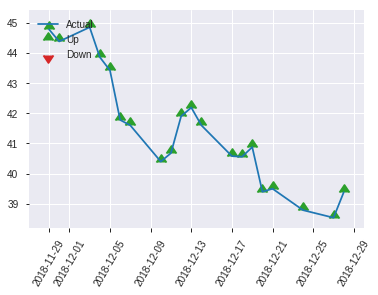


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2553772146252646
RMSE: 0.5053486070281233
LogLoss: 0.7042455393457455
Mean Per-Class Error: 0.4742576780935389
AUC: 0.49827959729833055
pr_auc: 0.46169315105634057
Gini: -0.003440805403338909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3460281789302826: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    131  0.985    (131.0/133.0)
1      0    118  0        (0.0/118.0)
Total  2    249  0.5219   (131.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.346028     0.643052  248
max f2                       0.346028     0.818308  248
max f0point5                 0.346028     0.529623  248
max accuracy                 0.6749       0.537849  1
max precision                0.698473     1         0
max recall                   0.346028     1         248
max specificity              0.698473     1         0
max absolute_mcc             0.593826     0.110627  25
max min_per_class_accuracy   0.493957     0.5       124
max mean_per_class_accuracy  0.512202     0.525742  90

Gains/Lift Table: Avg response rate: 47.01 %, avg score: 49.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.665354           1.41808   1.41808            0.666667         0.679862  0.666667                    0.679862            0.0169492       0.0169492                  41.8079   41.8079
    2        0.0239044                   0.660205           0         0.70904            0                0.661761  0.333333                    0.670812            0               0.0169492                  -100      -29.096
    3        0.0318725                   0.644556           1.06356   0.797669           0.5              0.650063  0.375                       0.665624            0.00847458      0.0254237                  6.35593   -20.2331
    4        0.0438247                   0.63142            1.41808   0.966872           0.666667         0.638984  0.454545                    0.658359            0.0169492       0.0423729                  41.8079   -3.31279
    5        0.0517928                   0.625325           1.06356   0.981747           0.5              0.628447  0.461538                    0.653757            0.00847458      0.0508475                  6.35593   -1.82529
    6        0.103586                    0.593826           0.327249  0.654498           0.153846         0.612     0.307692                    0.632879            0.0169492       0.0677966                  -67.2751  -34.5502
    7        0.151394                    0.567538           1.41808   0.895629           0.666667         0.57959   0.421053                    0.616051            0.0677966       0.135593                   41.8079   -10.4371
    8        0.203187                    0.54964            1.14537   0.959289           0.538462         0.559036  0.45098                     0.601517            0.059322        0.194915                   14.5372   -4.07112
    9        0.302789                    0.524299           1.1061    1.00758            0.52             0.535347  0.473684                    0.579751            0.110169        0.305085                   10.6102   0.758252
    10       0.40239                     0.502477           1.02102   1.01091            0.48             0.513499  0.475248                    0.563352            0.101695        0.40678                    2.10169   1.09079
    11       0.501992                    0.493558           0.935932  0.996032           0.44             0.497615  0.468254                    0.550309            0.0932203       0.5                        -6.40678  -0.396825
    12       0.601594                    0.472714           1.27627   1.04243            0.6              0.483346  0.490066                    0.539222            0.127119        0.627119                   27.6271   4.2429
    13       0.701195                    0.458871           0.595593  0.978958           0.28             0.464669  0.460227                    0.528632            0.059322        0.686441                   -40.4407  -2.1042
    14       0.800797                    0.438396           1.19119   1.00535            0.56             0.449598  0.472637                    0.518802            0.118644        0.805085                   19.1186   0.535458
    15       0.900398                    0.41573            0.935932  0.997675           0.44             0.428829  0.469027                    0.508849            0.0932203       0.898305                   -6.40678  -0.232488
    16       1                           0.326843           1.02102   1                  0.48             0.382646  0.47012                     0.4962

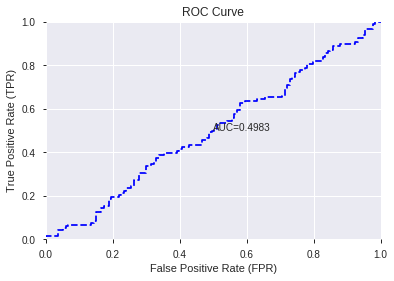

This function is available for GLM models only


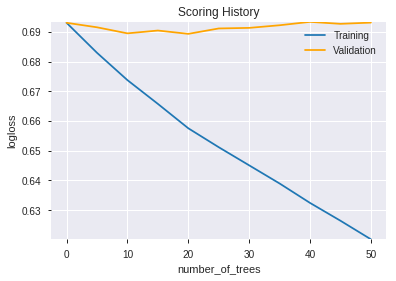

--2019-08-27 17:32:55--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.160.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.160.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190827_173213_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190827_173213_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_985e',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['TRANGE',
 'CORREL_24',
 'MFI_14',
 'HT_PHASOR_quadrature',
 'STOCHRSI_fastd',
 'CMO_8',
 'DX_12',
 'BETA_24',
 'HT_DCPERIOD',
 'DX_8',
 'ROC_12',
 'CORREL_14',
 'CORREL_20',
 'BETA_8',
 'ADOSC',
 'DX_24',
 'DX_30',
 'STDDEV_14',
 'MINUS_DM_12',
 'MOM_12',
 'MINUS_DM_8',
 'ADXR_8',
 'AROONOSC_20',
 'HT_PHASOR_inphase',
 'CCI_8',
 'STOCHRSI_fastk',
 'ROC_14',
 'STDDEV_8',
 'PLUS_DI_8',
 'BETA_20',
 'NATR_12',
 'STDDEV_20',
 'NATR_8',
 'BBANDS_lowerband_12_5_4',
 'ADX_24',
 'KAMA_20',
 'STOCH_slowd',
 'MACDFIX_signal_8',
 'CCI_20',
 'BBANDS_upperband_14_6_5',
 'aroonup_12',
 'BBANDS_upperband_30_7_5',
 'PLUS_DI_12',
 'LINEARREG_ANGLE_8',
 'ROC_20',
 'MACDFIX_hist_8',
 'CORREL_12',
 'WILLR_30',
 'BBANDS_lowerband_12_4_3',
 'MINUS_DM_30',
 'MFI_24',
 'BOP',
 'ADX_8',
 'BBANDS_upperband_12_6_5',
 'PLUS_DI_20',
 'aroondown_12',
 'MACDFIX_hist_20',
 'aroondown_30',
 'BBANDS_upperband_30_0_2',
 'BBANDS_upperband_14_3_2',
 'AROONOSC_24',
 'AROONOSC_8',
 'BBANDS_upperband_20_6_4',
 'MINUS_DI_12

In [54]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [55]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.570
GLM             0.558
XGBoost         0.550
dtype: float64

DeepLearning    GLM  XGBoost
All          0.570  0.554    0.550
DLF          0.562  0.542    0.538
Fwe          0.542  0.554    0.550
RFE          0.538  0.558    0.538
XGBF         0.554  0.542    0.538





F1


DeepLearning    0.648
GLM             0.643
XGBoost         0.643
dtype: float64

DeepLearning    GLM  XGBoost
All          0.643  0.640    0.640
DLF          0.640  0.640    0.640
Fwe          0.646  0.640    0.640
RFE          0.648  0.643    0.643
XGBF         0.641  0.640    0.640





auc


DeepLearning    0.549
GLM             0.460
XGBoost         0.503
dtype: float64

DeepLearning    GLM  XGBoost
All          0.549  0.458    0.503
DLF          0.487  0.460    0.476
Fwe          0.513  0.458    0.503
RFE          0.498  0.445    0.498
XGBF         0.504  0.460    0.476





logloss


DeepLearning    6.483
GLM             2.663
XGBoost         0.724
dtype: float64

DeepLearning    GLM  XGBoost
All          3.411  2.524    0.710
DLF          6.483  2.663    0.724
Fwe          4.880  2.524    0.710
RFE          1.141  0.698    0.704
XGBF         1.372  2.663    0.724





mean_per_class_error


DeepLearning    0.477
GLM             0.483
XGBoost         0.488
dtype: float64

DeepLearning    GLM  XGBoost
All          0.428  0.472    0.464
DLF          0.462  0.483    0.488
Fwe          0.474  0.472    0.464
RFE          0.477  0.466    0.474
XGBF         0.464  0.483    0.488





rmse


DeepLearning    0.686
GLM             0.563
XGBoost         0.515
dtype: float64

DeepLearning    GLM  XGBoost
All          0.662  0.559    0.508
DLF          0.612  0.563    0.515
Fwe          0.686  0.559    0.508
RFE          0.599  0.502    0.505
XGBF         0.530  0.563    0.515





mse


DeepLearning    0.470
GLM             0.318
XGBoost         0.265
dtype: float64

DeepLearning    GLM  XGBoost
All          0.438  0.313    0.258
DLF          0.375  0.318    0.265
Fwe          0.470  0.313    0.258
RFE          0.359  0.252    0.255
XGBF         0.281  0.318    0.265

{'F1':       DeepLearning    GLM  XGBoost
 All          0.643    NaN      NaN
 DLF          0.640    NaN      NaN
 DLF            NaN  0.640      NaN
 DLF            NaN    NaN    0.640
 All            NaN  0.640      NaN
 All            NaN    NaN    0.640
 XGBF         0.641    NaN      NaN
 XGBF           NaN  0.640      NaN
 XGBF           NaN    NaN    0.640
 Fwe          0.646    NaN      NaN
 Fwe            NaN  0.640      NaN
 Fwe            NaN    NaN    0.640
 RFE          0.648    NaN      NaN
 RFE            NaN  0.643      NaN
 RFE            NaN    NaN    0.643,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.570    NaN      NaN
 DLF          0.562    NaN      NaN
 DLF            NaN  0.542      NaN
 DLF            NaN    NaN    0.538
 All            NaN  0.554      NaN
 All            NaN    NaN    0.550
 XGBF         0.554    NaN      NaN
 XGBF           NaN  0.542      NaN
 XGBF           NaN    NaN    0.538
 Fwe          0.542    NaN      NaN
 Fwe     